# Top European Soccer leagues - match dataset

Data Analysis module / Capstone project @TuringCollege

## Intro

The dataset used in this notebook contains a range of match, team and player statistics for the major European Football Leagues.

The main goal of the project is to analyse this dataset and provide anything that could give a competitive advantage for betting company entering European football (soccer) market. 

### Key project requirements

- Perfom exploratory data analysis
- Perform statistical inference
- Predict match outcome
- Predict number of goals for each team

### Approach

- perform league-level analysis
- choose two top leagues
- compare features between chosen leagues using inferential statistics
- compare statistics between successful and less successful teams in chosen leagues
- apply basic ML models to predict match outcome
- apply basic ML models to predict goals that each team will score during the match

### Data structure

7 tables are used to perform EDA, statistical inference and machine learning:

**Player** table contains general information about player, such as name, surname, date of bearth, height, weight.  
**Player Attributes** table contains measurements on player characteristics, such as preffered foot, speed, agility, etc. and overall player rating. Measurements provided cover the period from 2007 to 2016.   
**Country** and **League** tables contain information about country in which particular league is organized.  
**Team** table contains general information about teams (clubs): name and short name.  
**Team Attributes** table contains measurements on various team characteristics, such as team speed, passing, defence pressure, etc. Measurements provided cover the period from 2010 to 2015.   
**Match** table contains data about matches in all leagues during 2008/2009 - 2015/2016 seasons.

## Setup

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, median_test
import statsmodels.stats.api as sms
import statsmodels.api as sm
from functions import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    confusion_matrix,
)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import (
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
    StandardScaler,
    PowerTransformer,
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.utils import class_weight

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import scipy.stats as stats

import collections
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams["figure.dpi"] = 200
sns.set_palette("icefire")

In [2]:
RANDOM = 101

In [3]:
con = sqlite3.connect("database.sqlite")

In [4]:
player_attributes = pd.read_sql_query("select * from Player_Attributes;", con)
player = pd.read_sql_query("select * from Player;", con)
match = pd.read_sql_query("select * from Match;", con)
country = pd.read_sql_query("select * from Country;", con)
league = pd.read_sql_query("select * from League;", con)
team_attributes = pd.read_sql_query("select * from Team_Attributes;", con)
team = pd.read_sql_query("select * from Team;", con)

### Queries

In [5]:
query = """
SELECT
    m.country_id, 
    c.name AS country,
    l.name AS league,
    m.season, 
    m.stage, 
    m.date, 
    m.match_api_id, 
    m.home_team_api_id, 
    t.team_long_name AS home_team_name,
    m.away_team_api_id,
    tm.team_long_name AS away_team_name,
    m.home_team_goal,
    m.away_team_goal,
    m.home_team_goal + m.away_team_goal AS goals_per_match, 
    ABS(m.home_team_goal - m.away_team_goal) AS difference,
    CASE
        WHEN m.home_team_goal < m.away_team_goal THEN
            'Away'
        WHEN m.home_team_goal > m.away_team_goal THEN 'Home'
        ELSE
        'Draw'
        END outcome,
    CASE
        WHEN m.home_team_goal < m.away_team_goal THEN
            tm.team_long_name
        WHEN m.home_team_goal > m.away_team_goal THEN 
            t.team_long_name
        ELSE
        'Draw'
        END winner    
FROM Match m
JOIN Team t
ON m.home_team_api_id = t.team_api_id 
JOIN Team tm
ON m.away_team_api_id = tm.team_api_id
JOIN Country c
ON m.country_id = c.id
JOIN League l
ON m.country_id = l.id
"""

match_info = pd.read_sql(sql=query, con=con)
match_info.head(3)

country_id  country                  league     season  stage  \
0           1  Belgium  Belgium Jupiler League  2008/2009      1   
1           1  Belgium  Belgium Jupiler League  2008/2009      1   
2           1  Belgium  Belgium Jupiler League  2008/2009      1   

                  date  match_api_id  home_team_api_id     home_team_name  \
0  2008-08-17 00:00:00        492473              9987           KRC Genk   
1  2008-08-16 00:00:00        492474             10000   SV Zulte-Waregem   
2  2008-08-16 00:00:00        492475              9984  KSV Cercle Brugge   

   away_team_api_id    away_team_name  home_team_goal  away_team_goal  \
0              9993      Beerschot AC               1               1   
1              9994  Sporting Lokeren               0               0   
2              8635    RSC Anderlecht               0               3   

   goals_per_match  difference outcome          winner  
0                2           0    Draw            Draw  
1                0           0    Draw            Draw  
2                3           3    Away  RSC Anderlecht

In [6]:
match_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   country_id        25979 non-null  int64 
 1   country           25979 non-null  object
 2   league            25979 non-null  object
 3   season            25979 non-null  object
 4   stage             25979 non-null  int64 
 5   date              25979 non-null  object
 6   match_api_id      25979 non-null  int64 
 7   home_team_api_id  25979 non-null  int64 
 8   home_team_name    25979 non-null  object
 9   away_team_api_id  25979 non-null  int64 
 10  away_team_name    25979 non-null  object
 11  home_team_goal    25979 non-null  int64 
 12  away_team_goal    25979 non-null  int64 
 13  goals_per_match   25979 non-null  int64 
 14  difference        25979 non-null  int64 
 15  outcome           25979 non-null  object
 16  winner            25979 non-null  object
dtypes: int64(9),

In [7]:
query = """
SELECT
    m.country_id, 
    c.name AS country,
    l.name AS league,
    ta.team_api_id,
    t.team_long_name AS team_name,
    AVG(ta.buildUpPlaySpeed) AS avg_play_speed,
    AVG(ta.buildUpPlayPassing) AS avg_play_passing,
    AVG(ta.chanceCreationPassing) AS avg_chance_creation_passing,
    AVG(ta.chanceCreationCrossing) AS avg_chance_creation_crossing,
    AVG(ta.chanceCreationShooting) AS avg_chance_creation_shooting,
    AVG(ta.defencePressure) AS avg_defence_pressure,
    AVG(ta.defenceAggression) AS avg_defence_aggression,
    AVG(ta.defenceTeamWidth) AS avg_defence_team_width
FROM team_attributes ta
JOIN Match m
ON ta.team_api_id = m.home_team_api_id
JOIN Team t
ON ta.team_api_id = t.team_api_id 
JOIN Country c
ON m.country_id = c.id
JOIN League l
ON m.country_id = l.id
GROUP BY ta.team_api_id
"""

team_info = pd.read_sql(sql=query, con=con)
team_info.head()

country_id   country                    league  team_api_id  \
0       15722    Poland        Poland Ekstraklasa         1601   
1           1   Belgium    Belgium Jupiler League         1773   
2       15722    Poland        Poland Ekstraklasa         1957   
3       17642  Portugal  Portugal Liga ZON Sagres         2033   
4       15722    Poland        Poland Ekstraklasa         2182   

               team_name  avg_play_speed  avg_play_passing  \
0           Ruch Chorzów       47.333333         46.166667   
1    Oud-Heverlee Leuven       52.000000         50.000000   
2  Jagiellonia Białystok       47.166667         52.666667   
3         S.C. Olhanense       49.000000         48.400000   
4            Lech Poznań       60.333333         49.000000   

   avg_chance_creation_passing  avg_chance_creation_crossing  \
0                    55.500000                     60.333333   
1                    50.000000                     53.000000   
2                    50.833333                     36.333333   
3                    51.800000                     44.200000   
4                    56.666667                     57.333333   

   avg_chance_creation_shooting  avg_defence_pressure  avg_defence_aggression  \
0                          53.5             47.166667               47.333333   
1                          54.0             43.000000               44.000000   
2                          67.0             49.333333               56.333333   
3                          48.2             42.200000               33.800000   
4                          68.0             51.666667               48.500000   

   avg_defence_team_width  
0               49.333333  
1               50.000000  
2               53.666667  
3               45.400000  
4               54.500000

In [8]:
team_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country_id                    288 non-null    int64  
 1   country                       288 non-null    object 
 2   league                        288 non-null    object 
 3   team_api_id                   288 non-null    int64  
 4   team_name                     288 non-null    object 
 5   avg_play_speed                288 non-null    float64
 6   avg_play_passing              288 non-null    float64
 7   avg_chance_creation_passing   288 non-null    float64
 8   avg_chance_creation_crossing  288 non-null    float64
 9   avg_chance_creation_shooting  288 non-null    float64
 10  avg_defence_pressure          288 non-null    float64
 11  avg_defence_aggression        288 non-null    float64
 12  avg_defence_team_width        288 non-null    float64
dtypes: fl

In [9]:
query = """
SELECT
    c.name AS country,
    m.stage, 
    m.date, 
    m.match_api_id, 
    m.home_team_api_id, 
    m.away_team_api_id,
    m.home_team_goal,
    m.away_team_goal,
    CASE
        WHEN m.home_team_goal < m.away_team_goal THEN
            'away'
        WHEN m.home_team_goal > m.away_team_goal THEN 'home'
        ELSE
        'draw'
        END outcome,
    m.home_player_1,
    m.home_player_2,
    m.home_player_3,
    m.home_player_4,
    m.home_player_5,
    m.home_player_6,
    m.home_player_7,
    m.home_player_8,
    m.home_player_9,
    m.home_player_10,
    m.home_player_11,
    m.away_player_1,
    m.away_player_2,
    m.away_player_3,
    m.away_player_4,
    m.away_player_5,
    m.away_player_6,
    m.away_player_7,
    m.away_player_8,
    m.away_player_9,
    m.away_player_10,
    m.away_player_11
FROM Match m
JOIN Team t
ON m.home_team_api_id = t.team_api_id 
JOIN Team tm
ON m.away_team_api_id = tm.team_api_id
JOIN Country c
ON m.country_id = c.id
JOIN League l
ON m.country_id = l.id
"""

match_player = pd.read_sql(sql=query, con=con)
match_player.head()

country  stage                 date  match_api_id  home_team_api_id  \
0  Belgium      1  2008-08-17 00:00:00        492473              9987   
1  Belgium      1  2008-08-16 00:00:00        492474             10000   
2  Belgium      1  2008-08-16 00:00:00        492475              9984   
3  Belgium      1  2008-08-17 00:00:00        492476              9991   
4  Belgium      1  2008-08-16 00:00:00        492477              7947   

   away_team_api_id  home_team_goal  away_team_goal outcome  home_player_1  \
0              9993               1               1    draw            NaN   
1              9994               0               0    draw            NaN   
2              8635               0               3    away            NaN   
3              9998               5               0    home            NaN   
4              9985               1               3    away            NaN   

   ...  away_player_2  away_player_3  away_player_4  away_player_5  \
0  ...            NaN            NaN            NaN            NaN   
1  ...            NaN            NaN            NaN            NaN   
2  ...            NaN            NaN            NaN            NaN   
3  ...            NaN            NaN            NaN            NaN   
4  ...            NaN            NaN            NaN            NaN   

   away_player_6  away_player_7  away_player_8  away_player_9  away_player_10  \
0            NaN            NaN            NaN            NaN             NaN   
1            NaN            NaN            NaN            NaN             NaN   
2            NaN            NaN            NaN            NaN             NaN   
3            NaN            NaN            NaN            NaN             NaN   
4            NaN            NaN            NaN            NaN             NaN   

   away_player_11  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 31 columns]

### Sumplementary match data

In [10]:
import import_ipynb

In [11]:
import supplementary_match_info as sp

importing Jupyter notebook from supplementary_match_info.ipynb


In [12]:
match_attr = match_info.merge(
    sp.match_attr, how="left", left_on="match_api_id", right_on="match_api_id"
)

In [13]:
match_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country_id                 25979 non-null  int64  
 1   country                    25979 non-null  object 
 2   league                     25979 non-null  object 
 3   season                     25979 non-null  object 
 4   stage                      25979 non-null  int64  
 5   date                       25979 non-null  object 
 6   match_api_id               25979 non-null  int64  
 7   home_team_api_id           25979 non-null  int64  
 8   home_team_name             25979 non-null  object 
 9   away_team_api_id           25979 non-null  int64  
 10  away_team_name             25979 non-null  object 
 11  home_team_goal             25979 non-null  int64  
 12  away_team_goal             25979 non-null  int64  
 13  goals_per_match            25979 non-null  int

In [14]:
match_attr = match_attr.drop(columns=["possession_home_team", "possession_away_team"])

In [15]:
sp.goals_by_player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29900 entries, 0 to 29899
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   match_id   29900 non-null  object
 1   player_id  29900 non-null  object
 2   goals      29900 non-null  object
 3   team_id    29900 non-null  object
dtypes: object(4)
memory usage: 934.5+ KB


In [16]:
goals_by_player = sp.goals_by_player.apply(pd.to_numeric)

In [17]:
player_team_goals = goals_by_player.merge(
    team_info[["country", "league", "team_api_id", "team_name"]],
    how="left",
    left_on="team_id",
    right_on="team_api_id",
)

In [18]:
player_goals = player_team_goals.merge(
    player[["player_api_id", "player_name"]],
    how="left",
    left_on="player_id",
    right_on="player_api_id",
)

In [19]:
player_goals = player_goals.drop(columns=["team_api_id", "player_api_id"])

In [20]:
player_goals.head()

match_id  player_id  goals  team_id  country                  league  \
0    489042      37799      1    10261  England  England Premier League   
1    489042      24148      1    10260  England  England Premier League   
2    489043      26181      1     9825  England  England Premier League   
3    489044      30853      1     8650  England  England Premier League   
4    489045      23139      2     8654  England  England Premier League   

           team_name      player_name  
0   Newcastle United  Obafemi Martins  
1  Manchester United  Darren Fletcher  
2            Arsenal      Samir Nasri  
3          Liverpool  Fernando Torres  
4    West Ham United      Dean Ashton

***

## Data cleaning

### Players

In [21]:
player.head(3)

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163

In [22]:
player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


In [23]:
player = player.rename(columns=lambda x: x.strip())

In [24]:
player.isnull().sum()

id                    0
player_api_id         0
player_name           0
player_fifa_api_id    0
birthday              0
height                0
weight                0
dtype: int64

In [25]:
player[player["player_api_id"].duplicated()]

Empty DataFrame
Columns: [id, player_api_id, player_name, player_fifa_api_id, birthday, height, weight]
Index: []

In [26]:
player[player["player_fifa_api_id"].duplicated()]

Empty DataFrame
Columns: [id, player_api_id, player_name, player_fifa_api_id, birthday, height, weight]
Index: []

In [27]:
player = player.set_index("id")

In [28]:
player["player_api_id"].nunique()

11060

In [29]:
player["player_fifa_api_id"].nunique()

11060

### Player attributes

In [30]:
player_attributes.head(3)

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   

   finishing  heading_accuracy  short_passing  volleys  dribbling  curve  \
0       44.0              71.0           61.0     44.0       51.0   45.0   
1       44.0              71.0           61.0     44.0       51.0   45.0   
2       44.0              71.0           61.0     44.0       51.0   45.0   

   free_kick_accuracy  long_passing  ball_control  acceleration  sprint_speed  \
0                39.0          64.0          49.0          60.0          64.0   
1                39.0          64.0          49.0          60.0          64.0   
2                39.0          64.0          49.0          60.0          64.0   

   agility  reactions  balance  shot_power  jumping  stamina  strength  \
0     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
1     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
2     59.0       47.0     65.0        55.0     58.0     54.0      76.0   

   long_shots  aggression  interceptions  positioning  vision  penalties  \
0        35.0        71.0           70.0         45.0    54.0       48.0   
1        35.0        71.0           70.0         45.0    54.0       48.0   
2        35.0        63.0           41.0         45.0    54.0       48.0   

   marking  standing_tackle  sliding_tackle  gk_diving  gk_handling  \
0     65.0             69.0            69.0        6.0         11.0   
1     65.0             69.0            69.0        6.0         11.0   
2     65.0             66.0            69.0        6.0         11.0   

   gk_kicking  gk_positioning  gk_reflexes  
0        10.0             8.0          8.0  
1        10.0             8.0          8.0  
2        10.0             8.0          8.0

In [31]:
player_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

In [32]:
player_attributes.isnull().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [33]:
player_attributes["player_fifa_api_id"].nunique()

11062

In [34]:
player_attributes["player_api_id"].nunique()

11060

In [35]:
player_attributes = player_attributes.set_index("id")

### Teams

In [36]:
team.head()

id  team_api_id  team_fifa_api_id     team_long_name team_short_name
0   1         9987             673.0           KRC Genk             GEN
1   2         9993             675.0       Beerschot AC             BAC
2   3        10000           15005.0   SV Zulte-Waregem             ZUL
3   4         9994            2007.0   Sporting Lokeren             LOK
4   5         9984            1750.0  KSV Cercle Brugge             CEB

In [37]:
team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


In [38]:
team[team["team_api_id"].duplicated(keep=False)].head()

Empty DataFrame
Columns: [id, team_api_id, team_fifa_api_id, team_long_name, team_short_name]
Index: []

In [39]:
team[team["team_fifa_api_id"].duplicated(keep=False)].head()

id  team_api_id  team_fifa_api_id        team_long_name  \
8        9         7947               NaN         FCV Dender EH   
14      15         4049               NaN                Tubize   
15      16         9996          111560.0  Royal Excel Mouscron   
24    2510       274581          111560.0  Royal Excel Mouscron   
170  26561         6601               NaN           FC Volendam   

    team_short_name  
8               DEN  
14              TUB  
15              MOU  
24              MOP  
170             VOL

In [40]:
team = team.drop(columns="team_fifa_api_id")

In [41]:
team = team.set_index("id")

In [42]:
team.head()

team_api_id     team_long_name team_short_name
id                                                
1          9987           KRC Genk             GEN
2          9993       Beerschot AC             BAC
3         10000   SV Zulte-Waregem             ZUL
4          9994   Sporting Lokeren             LOK
5          9984  KSV Cercle Brugge             CEB

### Team attributes

In [43]:
team_attributes.head(3)

id  team_fifa_api_id  team_api_id                 date  buildUpPlaySpeed  \
0   1               434         9930  2010-02-22 00:00:00                60   
1   2               434         9930  2014-09-19 00:00:00                52   
2   3               434         9930  2015-09-10 00:00:00                47   

  buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
0              Balanced                   NaN                    Little   
1              Balanced                  48.0                    Normal   
2              Balanced                  41.0                    Normal   

   buildUpPlayPassing buildUpPlayPassingClass buildUpPlayPositioningClass  \
0                  50                   Mixed                   Organised   
1                  56                   Mixed                   Organised   
2                  54                   Mixed                   Organised   

   chanceCreationPassing chanceCreationPassingClass  chanceCreationCrossing  \
0                     60                     Normal                      65   
1                     54                     Normal                      63   
2                     54                     Normal                      63   

  chanceCreationCrossingClass  chanceCreationShooting  \
0                      Normal                      55   
1                      Normal                      64   
2                      Normal                      64   

  chanceCreationShootingClass chanceCreationPositioningClass  defencePressure  \
0                      Normal                      Organised               50   
1                      Normal                      Organised               47   
2                      Normal                      Organised               47   

  defencePressureClass  defenceAggression defenceAggressionClass  \
0               Medium                 55                  Press   
1               Medium                 44                  Press   
2               Medium                 44                  Press   

   defenceTeamWidth defenceTeamWidthClass defenceDefenderLineClass  
0                45                Normal                    Cover  
1                54                Normal                    Cover  
2                54                Normal                    Cover

In [44]:
team_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

In [45]:
team_attributes.columns = pd.Series(team_attributes.columns).apply(convert_col_name)

In [46]:
team_attributes["team_api_id"].nunique()

288

In [47]:
team_attributes["team_fifa_api_id"].nunique()

285

In [48]:
team_attributes = team_attributes.drop(columns="team_fifa_api_id")

In [49]:
team_attributes = team_attributes.set_index("id")

In [50]:
team_attributes.describe(include="object")

date build_up_play_speed_class  \
count                  1458                      1458   
unique                    6                         3   
top     2015-09-10 00:00:00                  Balanced   
freq                    245                      1184   

       build_up_play_dribbling_class build_up_play_passing_class  \
count                           1458                        1458   
unique                             3                           3   
top                           Little                       Mixed   
freq                            1004                        1236   

       build_up_play_positioning_class chance_creation_passing_class  \
count                             1458                          1458   
unique                               2                             3   
top                          Organised                        Normal   
freq                              1386                          1231   

       chance_creation_crossing_class chance_creation_shooting_class  \
count                            1458                           1458   
unique                              3                              3   
top                            Normal                         Normal   
freq                             1195                           1224   

       chance_creation_positioning_class defence_pressure_class  \
count                               1458                   1458   
unique                                 2                      3   
top                            Organised                 Medium   
freq                                1309                   1243   

       defence_aggression_class defence_team_width_class  \
count                      1458                     1458   
unique                        3                        3   
top                       Press                   Normal   
freq                       1274                     1286   

       defence_defender_line_class  
count                         1458  
unique                           2  
top                          Cover  
freq                          1362

### Leagues

In [51]:
league.head(3)

id  country_id                    name
0     1           1  Belgium Jupiler League
1  1729        1729  England Premier League
2  4769        4769          France Ligue 1

In [52]:
league.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11 non-null     int64 
 1   country_id  11 non-null     int64 
 2   name        11 non-null     object
dtypes: int64(2), object(1)
memory usage: 392.0+ bytes


In [53]:
league["id"].nunique()

11

In [54]:
league = league.rename(columns={"name": "league"})

### Countries

In [55]:
country.head(3)

id     name
0     1  Belgium
1  1729  England
2  4769   France

In [56]:
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11 non-null     int64 
 1   name    11 non-null     object
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


In [57]:
country["id"].nunique()

11

In [58]:
country = country.rename(columns={"name": "country"})

### Matches

In [59]:
match.head(3)

id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0        492473              9987              9993               1   
1        492474             10000              9994               0   
2        492475              9984              8635               0   

   away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0               1             NaN             NaN             NaN   
1               0             NaN             NaN             NaN   
2               3             NaN             NaN             NaN   

   home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   

   home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0             NaN             NaN              NaN              NaN   
1             NaN             NaN              NaN              NaN   
2             NaN             NaN              NaN              NaN   

   away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   

   away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   

   away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
0             NaN              NaN              NaN             NaN   
1             NaN              NaN              NaN             NaN   
2             NaN              NaN              NaN             NaN   

   home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   

   home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   

   home_player_Y10  home_player_Y11  away_player_Y1  away_player_Y2  \
0              NaN              NaN             NaN             NaN   
1              NaN              NaN             NaN             NaN   
2              NaN              NaN             NaN             NaN   

   away_player_Y3  away_player_Y4  away_player_Y5  away_player_Y6  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   

   away_player_Y7  away_player_Y8  away_player_Y9  away_player_Y10  \
0             NaN             NaN             NaN              NaN   
1             NaN             NaN             NaN              NaN   
2             NaN             NaN             NaN              NaN   

   away_player_Y11  home_player_1  home_player_2  home_player_3  \
0              NaN            NaN            NaN            NaN   
1              NaN            NaN            NaN            NaN   
2              NaN            NaN            NaN            NaN   

   home_player_4  home_player_5  home_player_6  home_player_7  home_player_8  \
0        

In [60]:
# match.info(verbose=True, null_counts=True)

In [61]:
match["home_team_api_id"].nunique()

299

In [62]:
match["away_team_api_id"].nunique()

299

In [63]:
match[match["match_api_id"].duplicated()]

Empty DataFrame
Columns: [id, country_id, league_id, season, stage, date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal, home_player_X1, home_player_X2, home_player_X3, home_player_X4, home_player_X5, home_player_X6, home_player_X7, home_player_X8, home_player_X9, home_player_X10, home_player_X11, away_player_X1, away_player_X2, away_player_X3, away_player_X4, away_player_X5, away_player_X6, away_player_X7, away_player_X8, away_player_X9, away_player_X10, away_player_X11, home_player_Y1, home_player_Y2, home_player_Y3, home_player_Y4, home_player_Y5, home_player_Y6, home_player_Y7, home_player_Y8, home_player_Y9, home_player_Y10, home_player_Y11, away_player_Y1, away_player_Y2, away_player_Y3, away_player_Y4, away_player_Y5, away_player_Y6, away_player_Y7, away_player_Y8, away_player_Y9, away_player_Y10, away_player_Y11, home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11, goal, shoton, shotoff, foulcommit, card, cross, corner, possession, B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA, PSH, PSD, PSA, ...]
Index: []

In [64]:
match["date"] = pd.to_datetime(match["date"])

In [65]:
percent_missing = (
    (match.isnull().sum() * 100 / len(match))
    .to_frame()
    .rename(columns={0: "percent_missing"})
    .round(2)
)
pd.set_option("display.max_rows", match.shape[0] + 1)

percent_missing.tail(10)

percent_missing
SJA            34.19
VCH            13.13
VCD            13.13
VCA            13.13
GBH            45.49
GBD            45.49
GBA            45.49
BSH            45.49
BSD            45.49
BSA            45.49

In [66]:
match.groupby("league_id").count()[["shoton", "foulcommit", "card"]]

shoton  foulcommit  card
league_id                          
1               0           0     0
1729         3040        3040  3040
4769         2026        2026  2026
7809         2448        2448  2448
10257        3014        3014  3014
13274         530         530   530
15722           7           7     7
17642           0           0     0
19694          13          13    13
21518        3039        3039  3039
24558         100         100   100

In [67]:
match.groupby(["league_id"]).count()[["B365H", "B365D", "B365A", "PSH", "PSD", "PSA"]]

B365H  B365D  B365A   PSH   PSD   PSA
league_id                                       
1           1706   1706   1706   710   710   710
1729        3040   3040   3040  1519  1519  1519
4769        3036   3036   3036  1519  1519  1519
7809        2447   2447   2447  1223  1223  1223
10257       3011   3011   3011  1514  1514  1514
13274       2445   2445   2445  1194  1194  1194
15722          0      0      0     0     0     0
17642       2044   2044   2044  1074  1074  1074
19694       1824   1824   1824   898   898   898
21518       3039   3039   3039  1517  1517  1517
24558          0      0      0     0     0     0

**Insights**

1. Match table contains data about almost 26000 matches: league, home team, away team, goals, players and their positions, match statistics and odds from several betting companies.
1. Data structure of 'match' table provides some useful information for analysis and predictions: 
    - data about events during the match, for example shot on/off targets, fouls, yellow and red cards, is available not for all leagues and some leagues have only several records. It seems that detail match data is gathered only for major European football leagues.
    - not all leagues have betting odds. It may be the case that these leagues are quite small and have low engagement therefore major betting companies don't see the value providing an option to bet on them. This is a good reference for project business case - there is no need to focus on all soccer leagues in the beggining while entering a new market.

***

## Exploratory data analysis

### Which leagues are in which countries?

In [68]:
league.head()

id  country_id                  league
0      1           1  Belgium Jupiler League
1   1729        1729  England Premier League
2   4769        4769          France Ligue 1
3   7809        7809   Germany 1. Bundesliga
4  10257       10257           Italy Serie A

In [69]:
leagues_in_countries = (
    country.set_index("id").join(league.set_index("country_id")["league"]).reset_index()
)

leagues_in_countries

id      country                    league
0       1      Belgium    Belgium Jupiler League
1    1729      England    England Premier League
2    4769       France            France Ligue 1
3    7809      Germany     Germany 1. Bundesliga
4   10257        Italy             Italy Serie A
5   13274  Netherlands    Netherlands Eredivisie
6   15722       Poland        Poland Ekstraklasa
7   17642     Portugal  Portugal Liga ZON Sagres
8   19694     Scotland   Scotland Premier League
9   21518        Spain           Spain LIGA BBVA
10  24558  Switzerland  Switzerland Super League

In [70]:
num_of_leagues_by_team = match_info.groupby(["home_team_name"]).agg(
    num_of_leagues=("league", "nunique")
)

num_of_leagues_by_team[num_of_leagues_by_team["num_of_leagues"] > 1]

Empty DataFrame
Columns: [num_of_leagues]
Index: []

**Insights**

1. This dataset contains the top professional football leagues by country with the relation: one country - one football league.
1. Teams play internally in the league but doesn't play with the teams from the other league. 
1. During a season each team plays each other team twice, home and away.

Source: https://www.bundesliga.com/en/faq/what-are-the-rules-and-regulations-of-soccer/__trashed-10568

### Which leagues score the most/fewest goals throughout all 8 seasons?

In [71]:
goals_by_league = match_info.groupby("league").agg(goals=("goals_per_match", "sum"))

goals_by_league.sort_values(by="goals", ascending=False)

goals
league                         
Spain LIGA BBVA            8412
England Premier League     8240
Italy Serie A              7895
Netherlands Eredivisie     7542
France Ligue 1             7427
Germany 1. Bundesliga      7103
Portugal Liga ZON Sagres   5201
Belgium Jupiler League     4841
Scotland Premier League    4804
Poland Ekstraklasa         4656
Switzerland Super League   4166

**Insights**

- While not necessarily an indicator of quality, total number of goals gives an impression of which leagues give fans the best entertainment on a regular basis.
- Spain league scored the most goals throughout all 8 seasons while Switzerland league scored the fewest.
- Hovewer it is difficult to evaluate/analyze leagues based solely total number of goals, because:
     - the number of teams differs in the leagues
     - the number of matches differs throughout the seasons
     - need to take into consideration different skillset, strategies and player capabilities in each league (it may be the case that teams in Switzerland Super League are focused more on defence and as a result score less goals)


### League stats by season

In [72]:
league_stats_per_season = match_info.groupby(["league", "season"]).agg(
    goals=("goals_per_match", "sum"),
    num_of_teams=("home_team_api_id", "nunique"),
    num_of_matches=("match_api_id", "count"),
    avg_diff=("difference", "mean"),
)

league_stats_per_season["avg_goals_per_match"] = (
    league_stats_per_season["goals"] / league_stats_per_season["num_of_matches"]
)

league_stats_per_season.drop(("Belgium Jupiler League", "2013/2014"), inplace=True)

In [73]:
league_stats = (
    league_stats_per_season.reset_index()
    .groupby("league")
    .agg(
        avg_goals_per_season=("goals", "mean"),
        avg_num_of_teams=("num_of_teams", "mean"),
        avg_num_of_matches=("num_of_matches", "mean"),
        avg_goals_per_match=("avg_goals_per_match", "mean"),
        avg_diff_per_match=("avg_diff", "mean"),
    )
)

league_stats[
    ["avg_goals_per_season", "avg_num_of_teams", "avg_num_of_matches"]
] = league_stats[
    ["avg_goals_per_season", "avg_num_of_teams", "avg_num_of_matches"]
].round()
league_stats[["avg_goals_per_match", "avg_diff_per_match"]] = league_stats[
    ["avg_goals_per_match", "avg_diff_per_match"]
].round(2)

league_stats

avg_goals_per_season  avg_num_of_teams  \
league                                                             
Belgium Jupiler League                   687.0              16.0   
England Premier League                  1030.0              20.0   
France Ligue 1                           928.0              20.0   
Germany 1. Bundesliga                    888.0              18.0   
Italy Serie A                            987.0              20.0   
Netherlands Eredivisie                   943.0              18.0   
Poland Ekstraklasa                       582.0              16.0   
Portugal Liga ZON Sagres                 650.0              16.0   
Scotland Premier League                  600.0              12.0   
Spain LIGA BBVA                         1052.0              20.0   
Switzerland Super League                 521.0              10.0   

                          avg_num_of_matches  avg_goals_per_match  \
league                                                              
Belgium Jupiler League                 245.0                 2.80   
England Premier League                 380.0                 2.71   
France Ligue 1                         380.0                 2.44   
Germany 1. Bundesliga                  306.0                 2.90   
Italy Serie A                          377.0                 2.62   
Netherlands Eredivisie                 306.0                 3.08   
Poland Ekstraklasa                     240.0                 2.42   
Portugal Liga ZON Sagres               256.0                 2.53   
Scotland Premier League                228.0                 2.63   
Spain LIGA BBVA                        380.0                 2.77   
Switzerland Super League               178.0                 2.93   

                          avg_diff_per_match  
league                                        
Belgium Jupiler League                  1.37  
England Premier League                  1.36  
France Ligue 1                          1.22  
Germany 1. Bundesliga                   1.45  
Italy Serie A                           1.26  
Netherlands Eredivisie                  1.56  
Poland Ekstraklasa                      1.24  
Portugal Liga ZON Sagres                1.30  
Scotland Premier League                 1.37  
Spain LIGA BBVA                         1.45  
Switzerland Super League                1.45

#### Avg number of goals per season

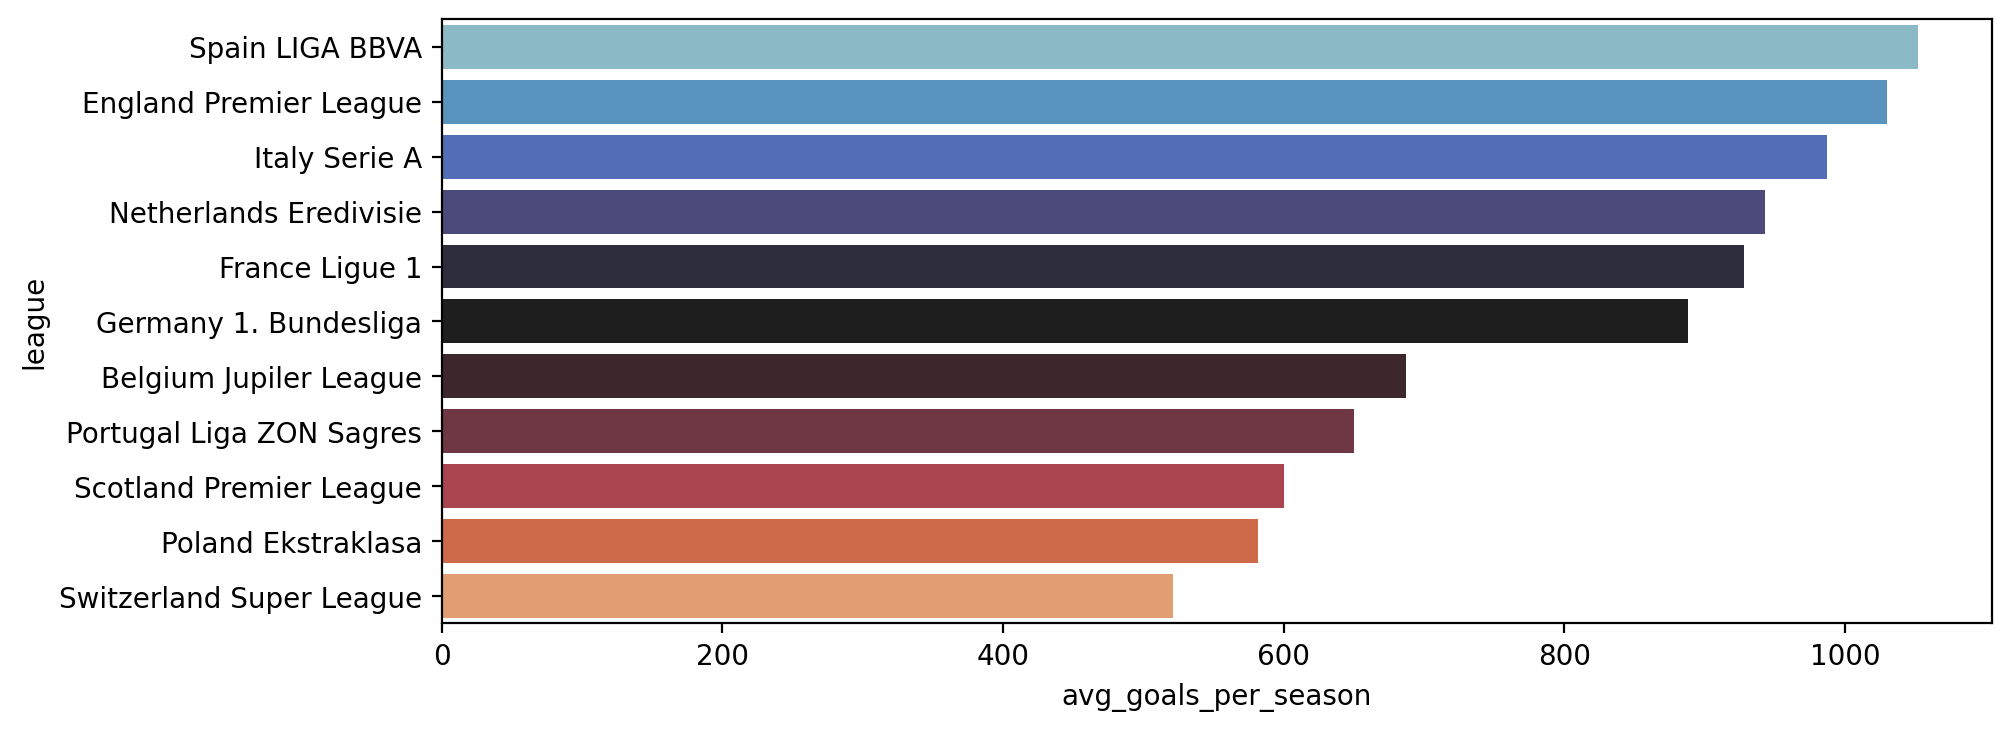

In [74]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    y=league_stats.index,
    x="avg_goals_per_season",
    data=league_stats,
    palette="icefire",
    order=league_stats["avg_goals_per_season"].sort_values(ascending=False).index,
)

plt.show()

**Insight**

Spain scores the most goals per season while Switzerland the least goals per season.

#### Avg number of teams per season

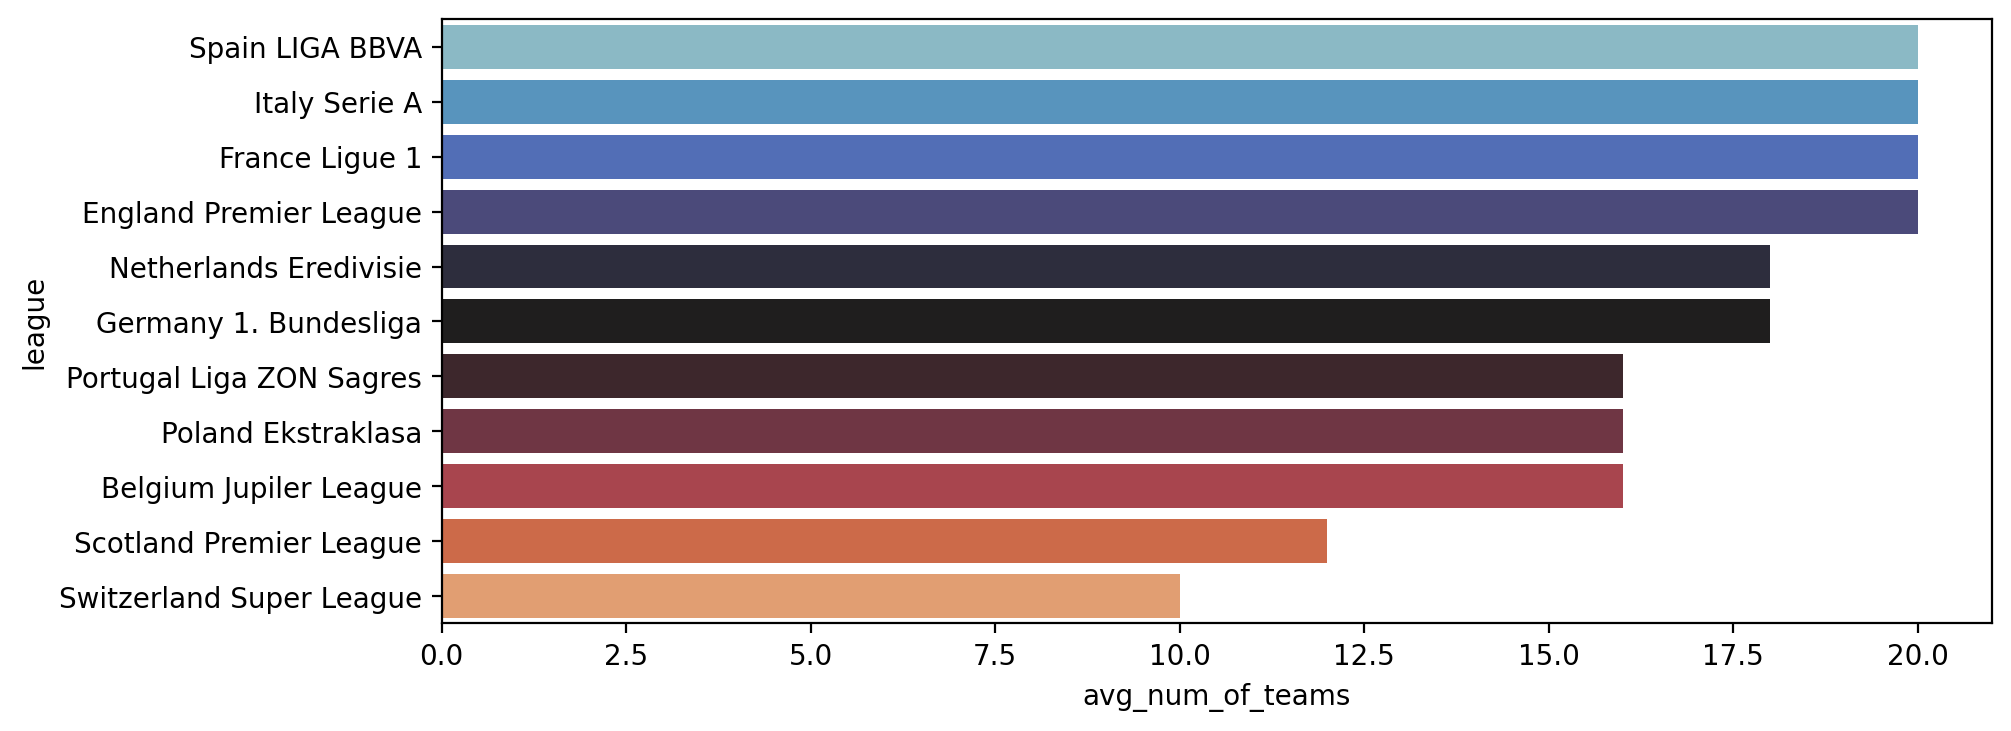

In [75]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    y=league_stats.index,
    x="avg_num_of_teams",
    data=league_stats,
    palette="icefire",
    order=league_stats["avg_num_of_teams"].sort_values(ascending=False).index,
)

plt.show()

**Insights**

1. Spain LIGA BBVA, Italy Serie A, France Liga 1 and England Premier League have, on average, 20 teams playing in one season.
1. On the other hand, Switzerland Super league has the lowest avg number of teams per season - 10, and this explains the lowest number of avg goals per season.

#### Avg number of matches per season

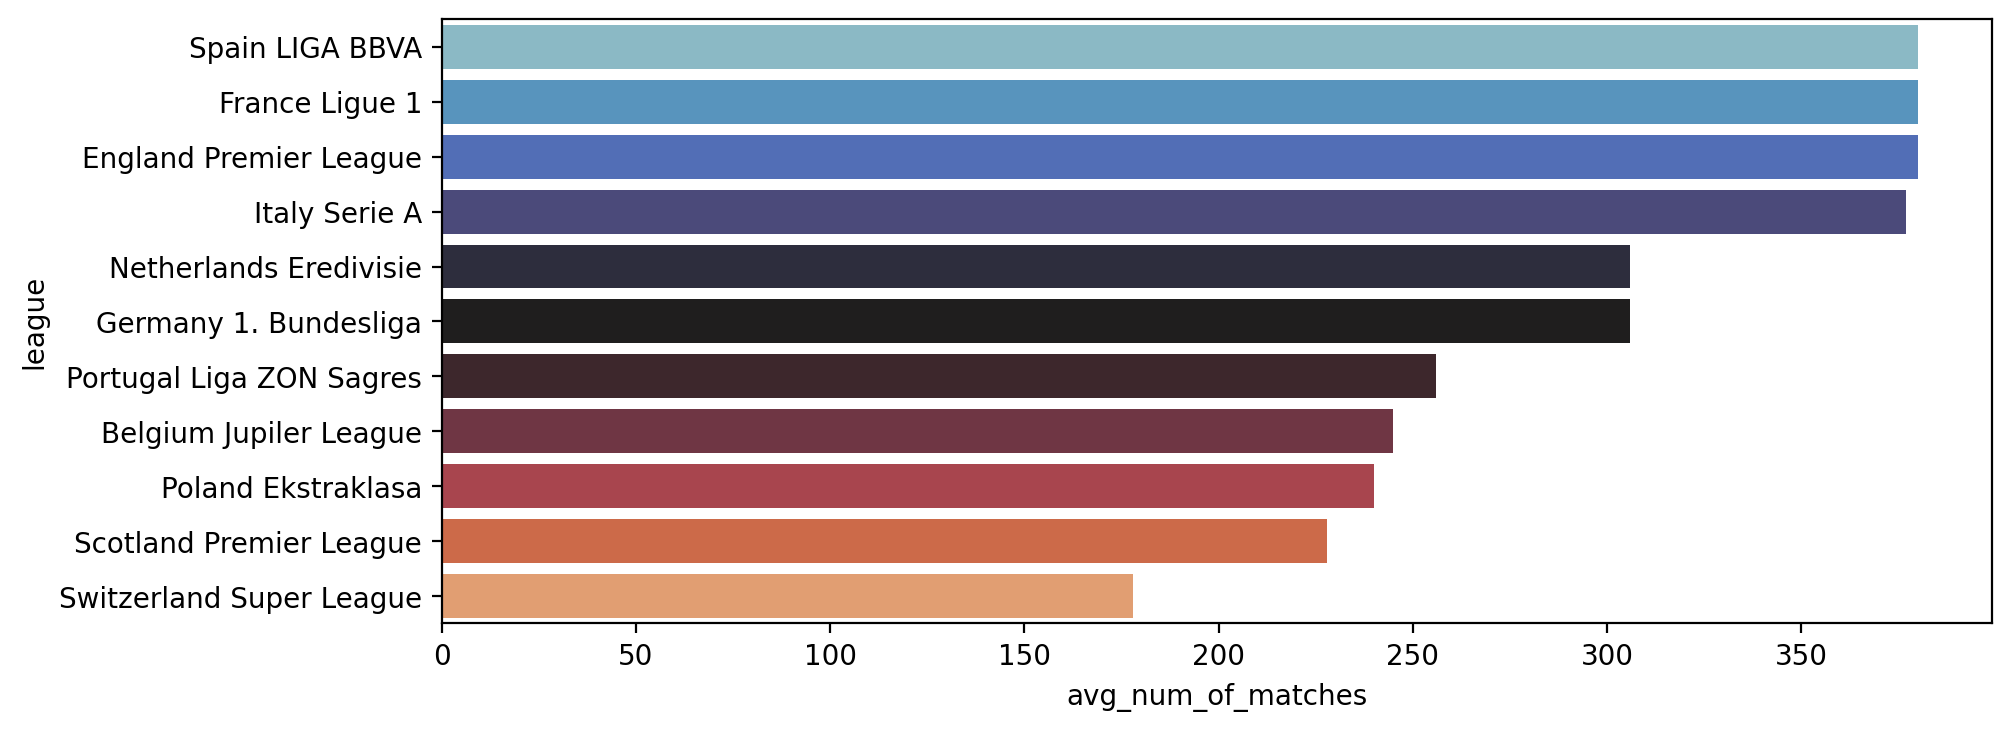

In [76]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    y=league_stats.index,
    x="avg_num_of_matches",
    data=league_stats,
    palette="icefire",
    order=league_stats["avg_num_of_matches"].sort_values(ascending=False).index,
)

plt.show()

**Insights**

1. Seems that number of matches correlates with number of teams - the higher number of teams in the league per season, the more matches.
1. Spain league has the most matches per season - 380 while Switzerland league has only 178 matches.

#### Avg number of goals per match

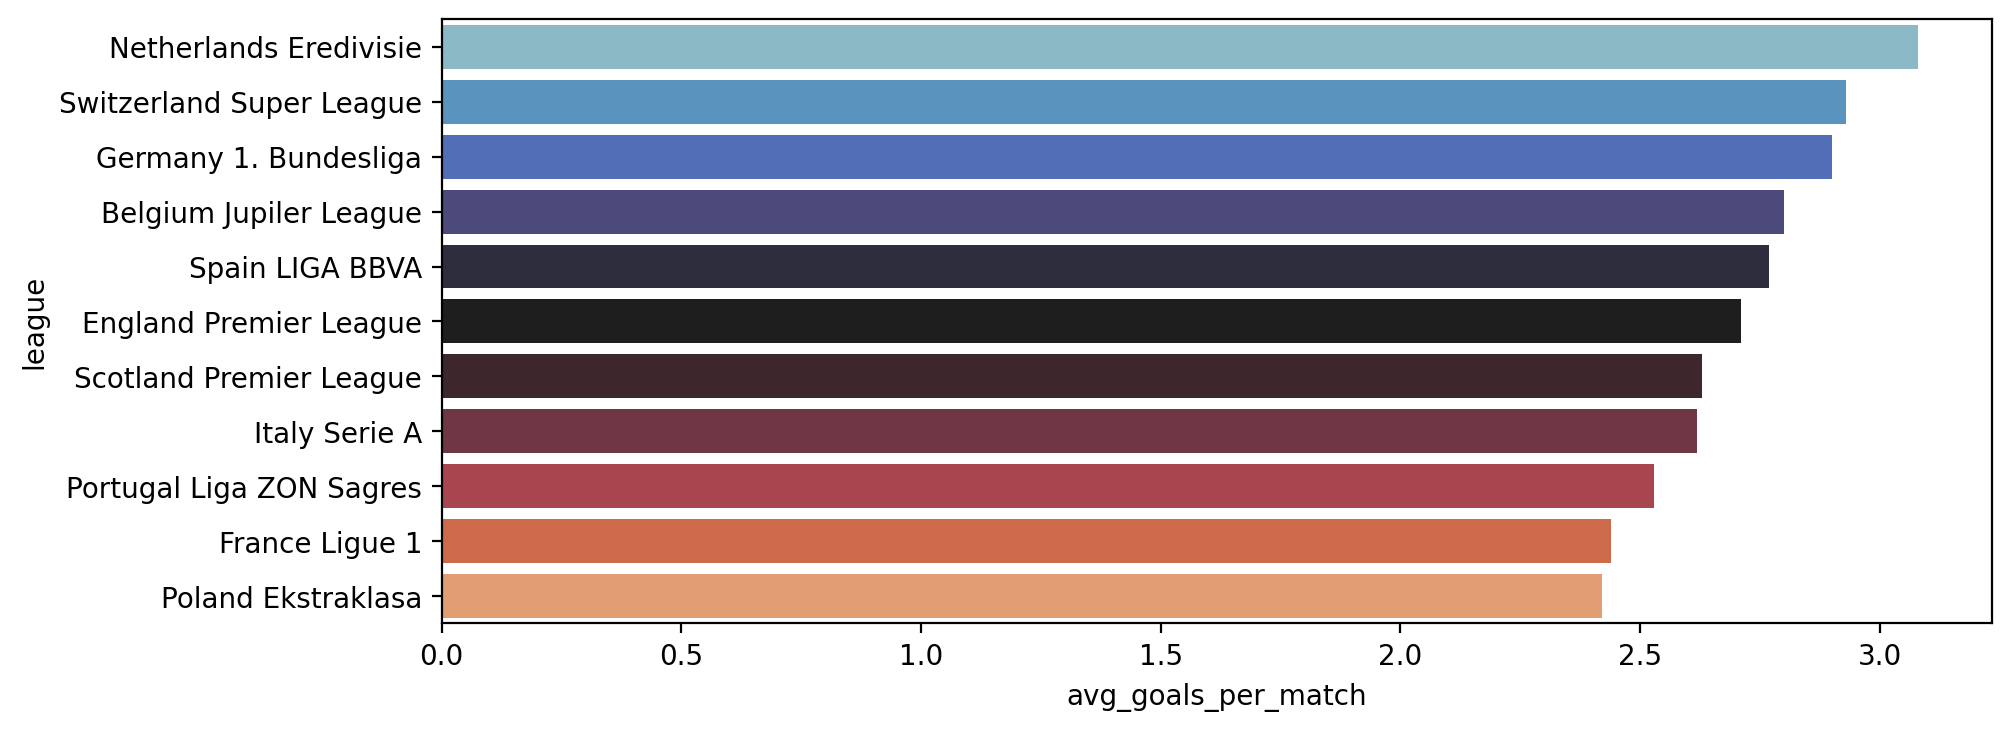

In [77]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    y=league_stats.index,
    x="avg_goals_per_match",
    data=league_stats,
    palette="icefire",
    order=league_stats["avg_goals_per_match"].sort_values(ascending=False).index,
)

plt.show()

**Insights**

1. Suprisingly, Netherlands Eredivisie is the clear leader in average number of goals per match - 3.08 
1. France and Poland leagues share the lowest average number of goals per match - a bit more than 2.4 

#### Avg goal difference per match

Goal difference per match could indicate how different from each other are the teams in the league:
- The higher avg goal difference in match, the higher the difference among teams regarding the level of skills or the strategy of the game.
- The lower the difference, the more similar teams are in the league.

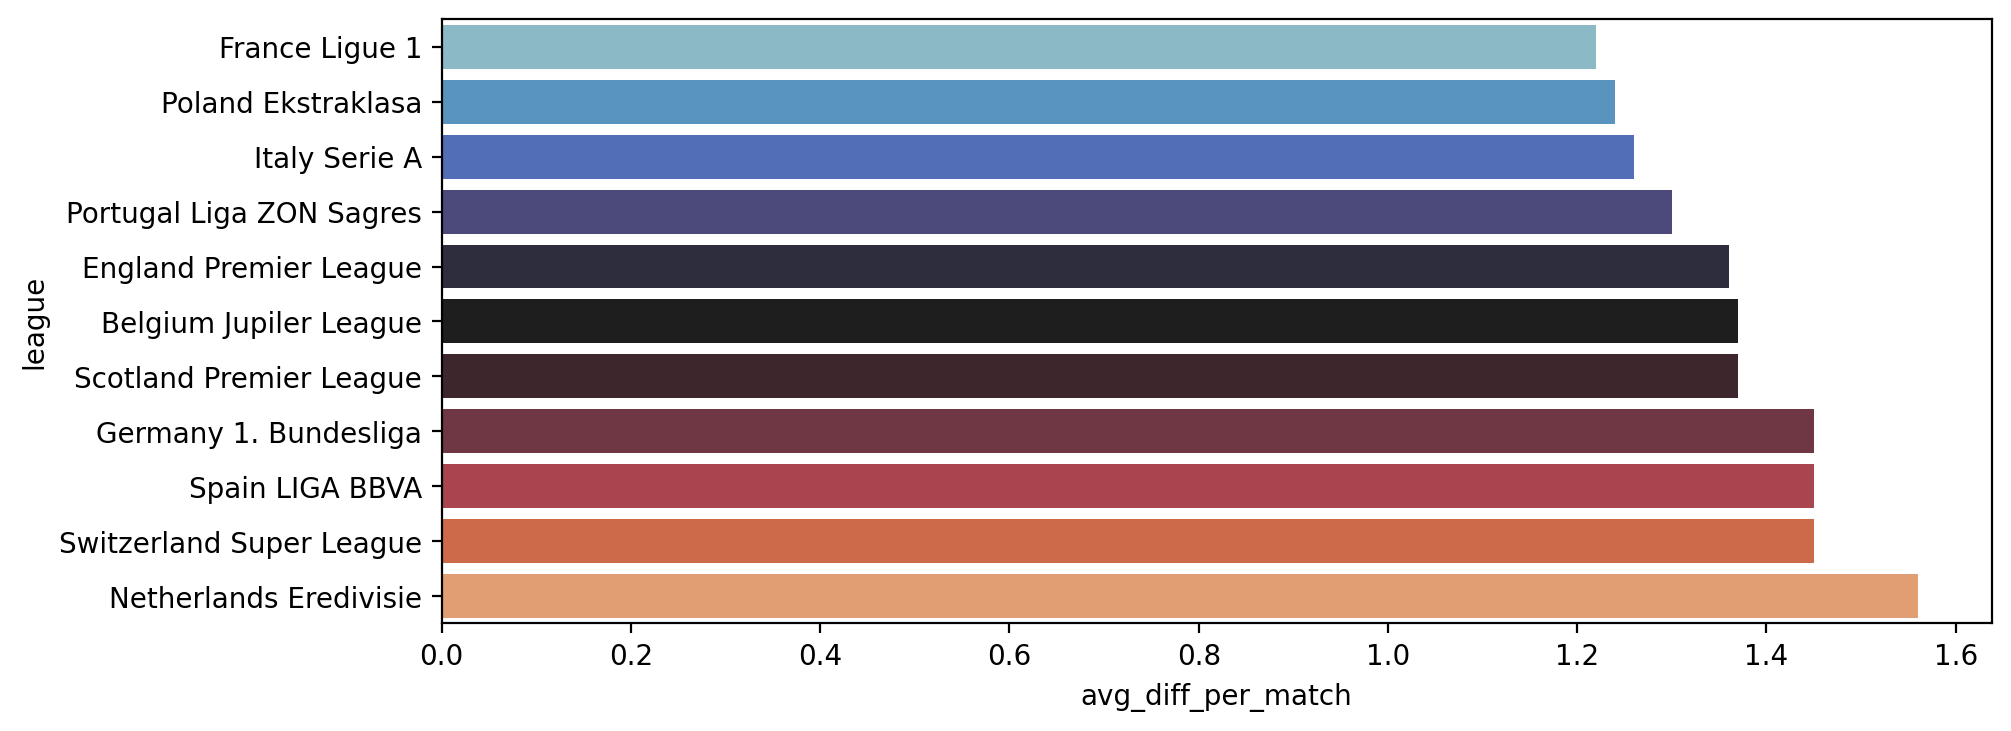

In [78]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    y=league_stats.index,
    x="avg_diff_per_match",
    data=league_stats,
    palette="icefire",
    order=league_stats["avg_diff_per_match"].sort_values().index,
)

plt.show()

**Insight**

1. France league has the lowest average goal difference meaning that teams in the league are probably at the same or very similar level.
1. Netherlands league has the the highest average goal difference indicating that one or couple of teams are really strong comparing with other teams in the league.

### Is there such a thing as home advantage?

In [79]:
goals_home_vs_away = match_info.groupby("league").agg(
    total_home_goals=("home_team_goal", "sum"),
    total_away_goals=("away_team_goal", "sum"),
)
goals_home_vs_away

total_home_goals  total_away_goals
league                                                      
Belgium Jupiler League                2781              2060
England Premier League                4715              3525
France Ligue 1                        4265              3162
Germany 1. Bundesliga                 3982              3121
Italy Serie A                         4528              3367
Netherlands Eredivisie                4357              3185
Poland Ekstraklasa                    2678              1978
Portugal Liga ZON Sagres              2890              2311
Scotland Premier League               2607              2197
Spain LIGA BBVA                       4959              3453
Switzerland Super League              2365              1801

In [80]:
home_vs_away_per_season = match_info.groupby("season").agg(
    home_goals=("home_team_goal", "sum"),
    away_goals=("away_team_goal", "sum"),
    total_goals=("goals_per_match", "sum"),
)

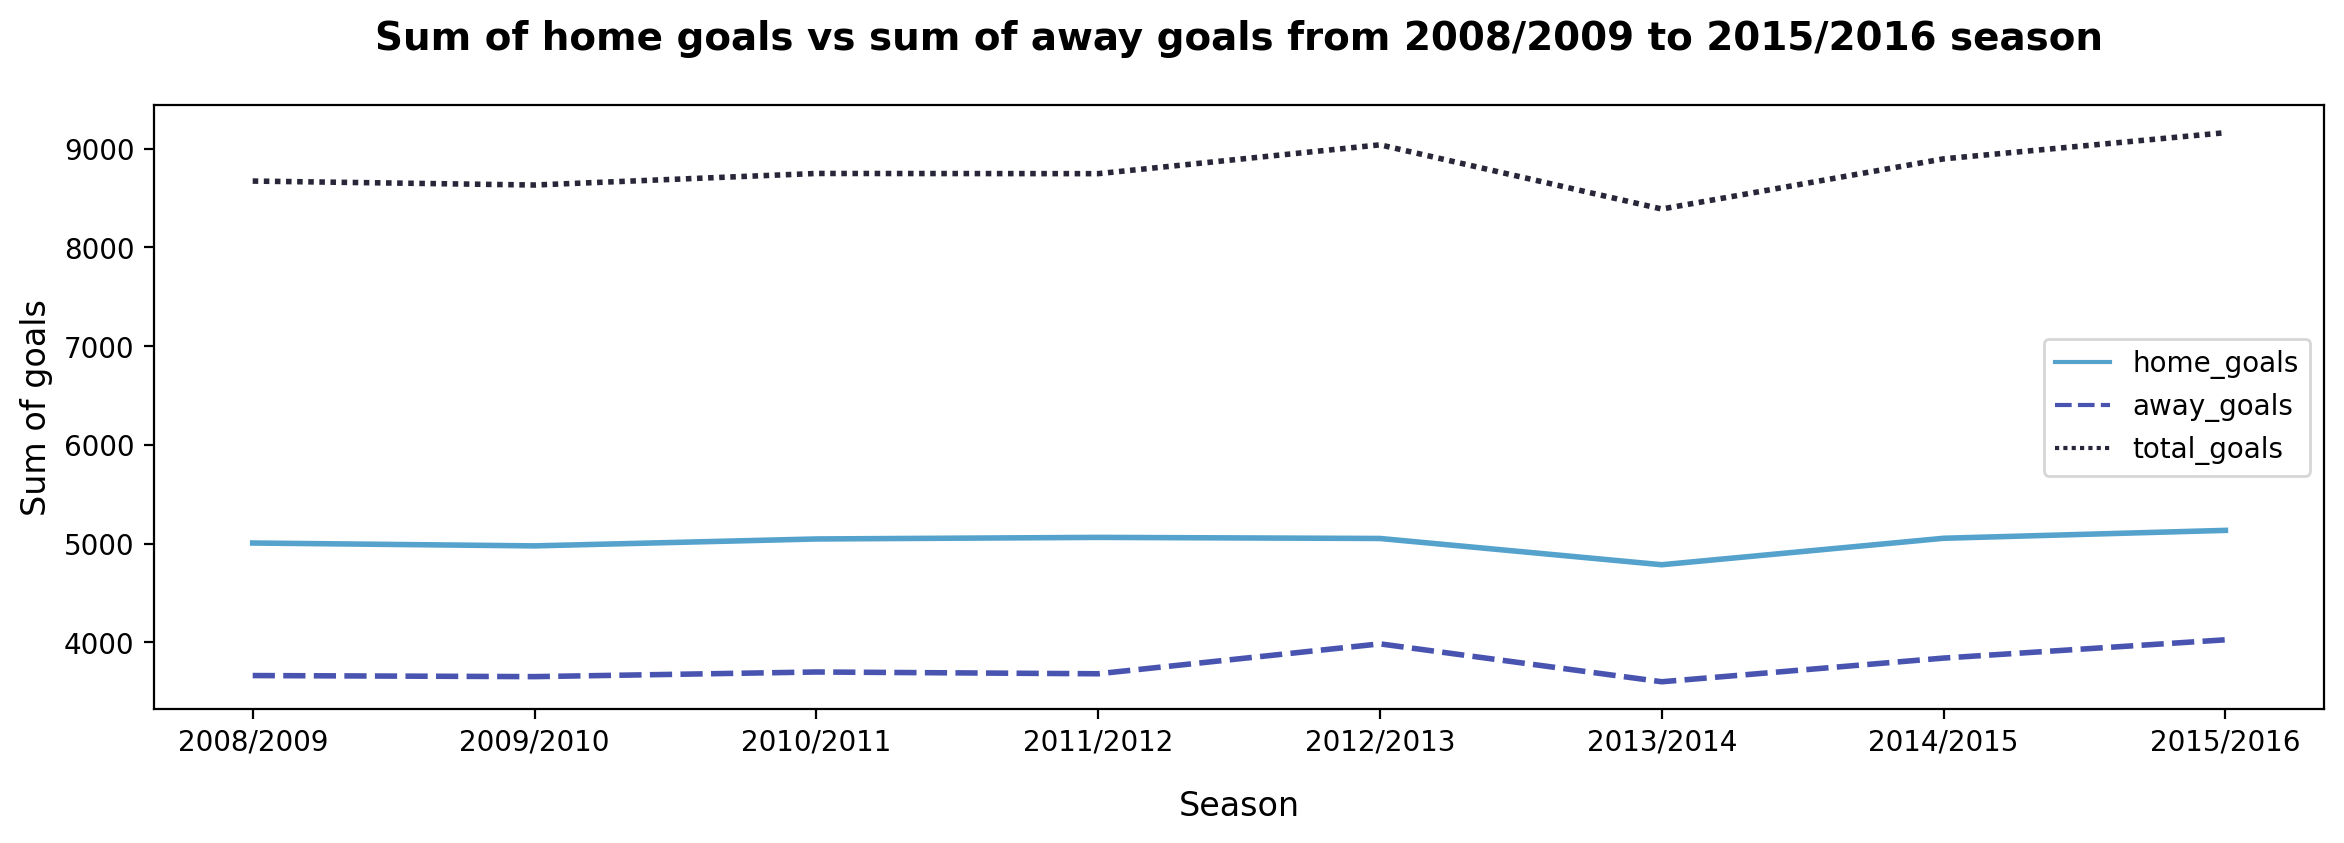

In [81]:
fig, ax = plt.subplots(figsize=(14, 4))

ax = sns.lineplot(data=home_vs_away_per_season, linewidth=2)
set_labels(
    ax,
    "Sum of home goals vs sum of away goals from 2008/2009 to 2015/2016 season",
    "season",
    "sum of goals",
)

plt.show()

In [82]:
outcome_by_league = (
    match_info.groupby(["league"])["outcome"]
    .value_counts(normalize=True)
    .to_frame()
    .rename(columns={"outcome": "percent"})
)
outcome_by_league["percent"] = outcome_by_league["percent"].apply(
    lambda x: round(x * 100, 1)
)

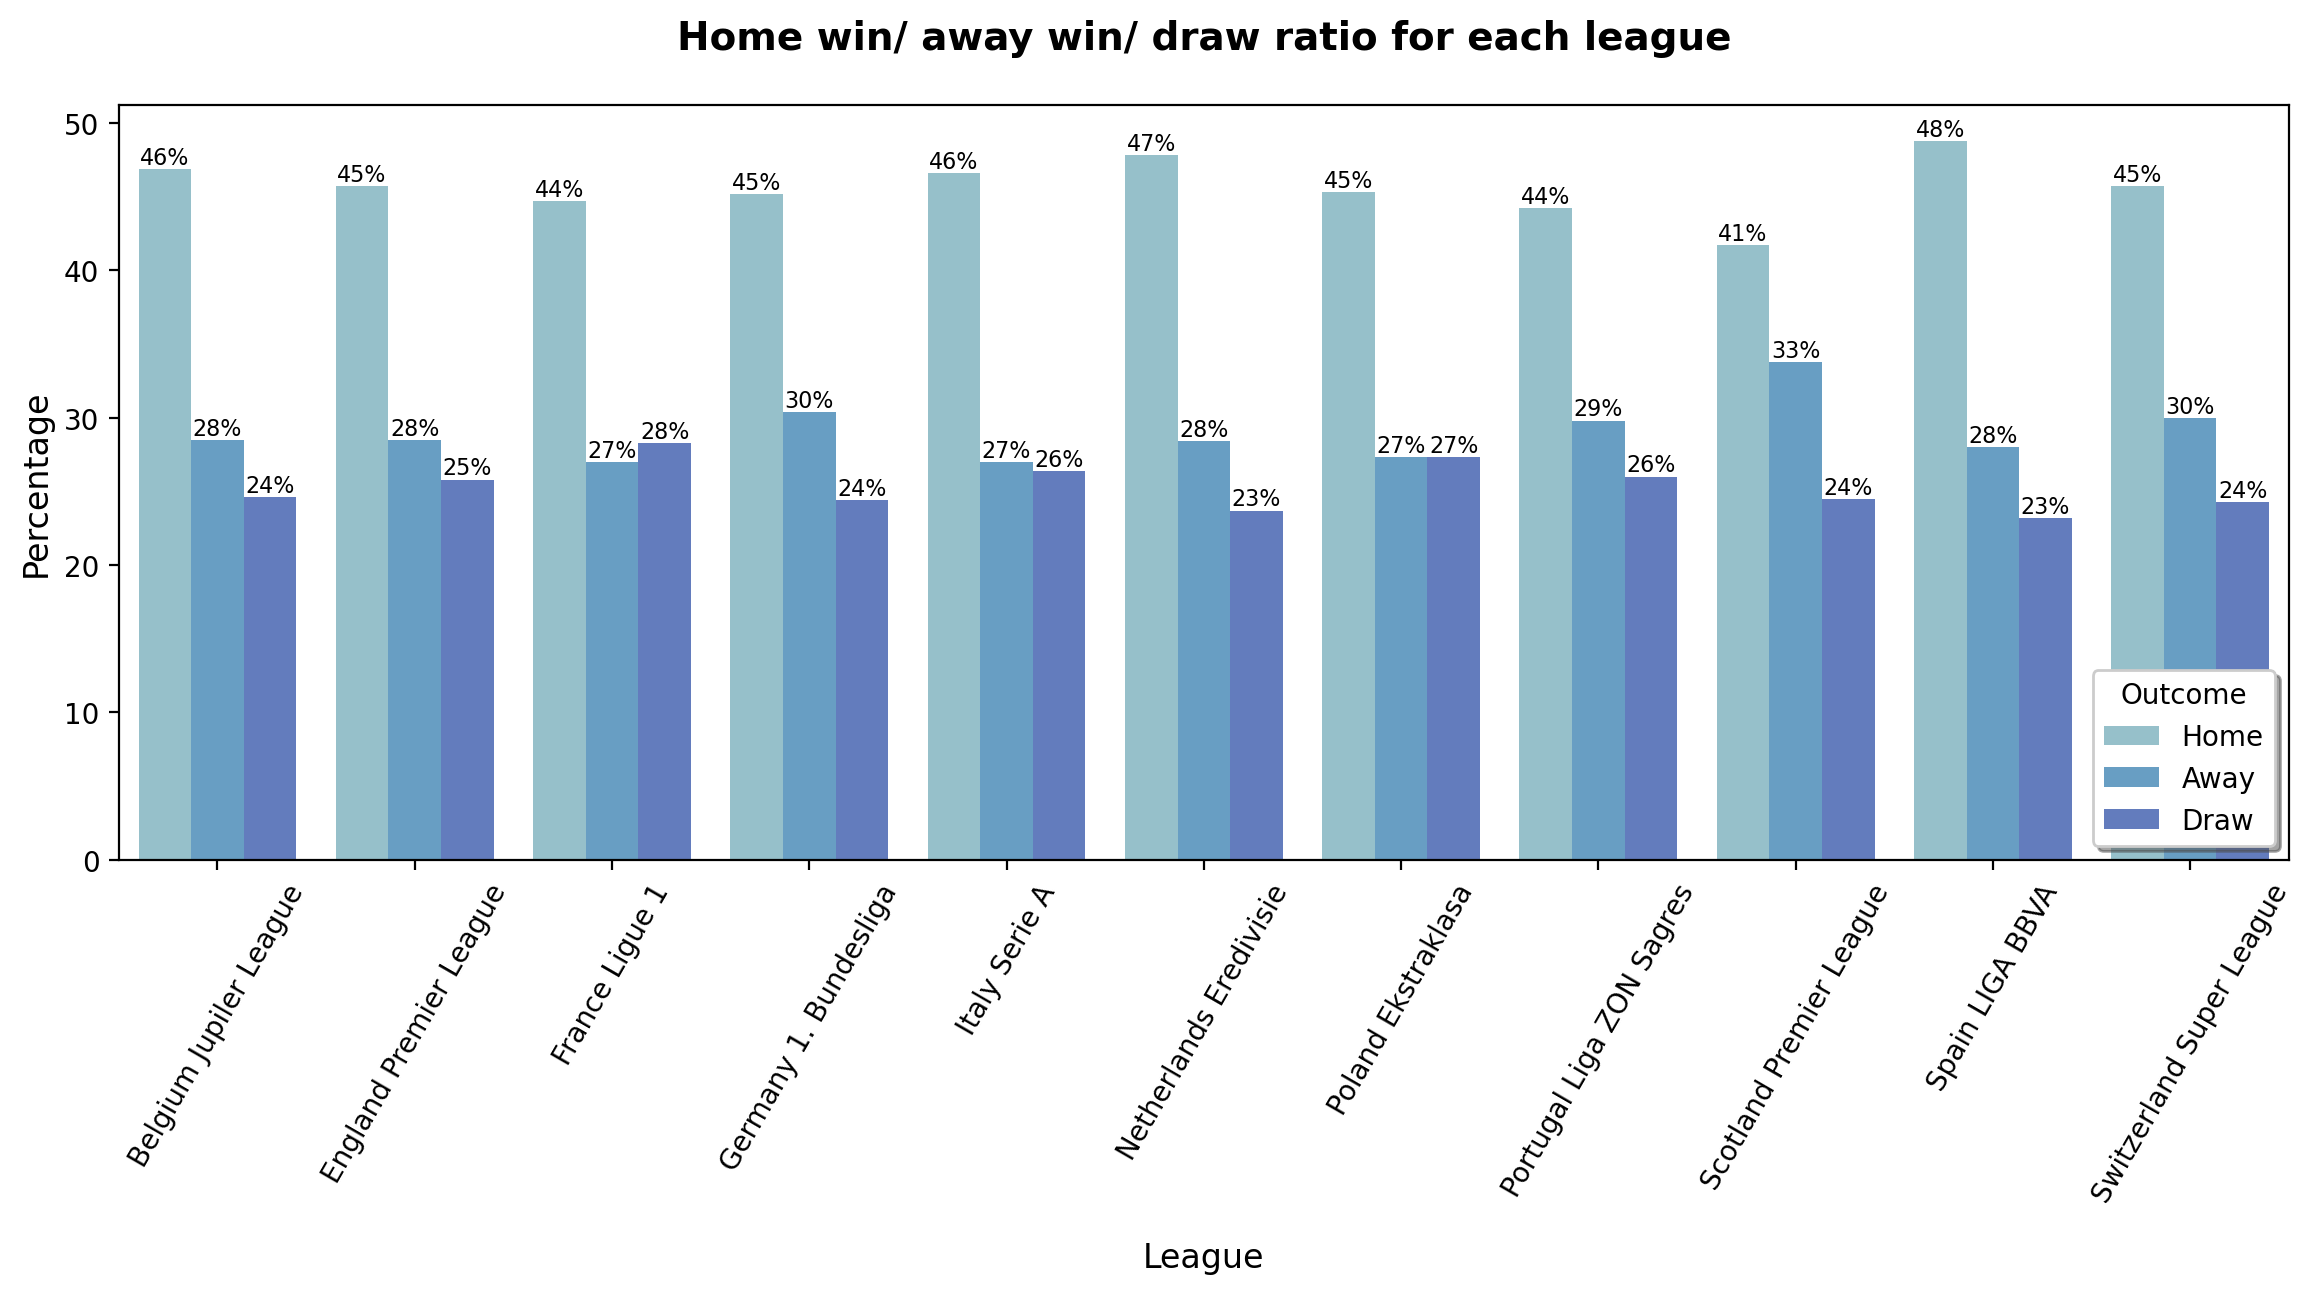

In [83]:
fig, ax = plt.subplots(figsize=(14, 5))

sns.barplot(
    x="league",
    y="percent",
    hue="outcome",
    data=outcome_by_league.reset_index(),
    palette=sns.set_palette("icefire", 11),
    alpha=0.9,
)
set_bar_pct(ax, 8)
set_labels(ax, "Home win/ Away win/ Draw ratio for each league", "League", "Percentage")

ax.legend(loc="lower right", facecolor="white", shadow=True, title="Outcome")

plt.xticks(rotation=60)
plt.show()

**Insight**

Without a doubt, teams playing at home score more goals than playing away and it is a clear pattern in all leagues throughout all seasons.

https://www.theguardian.com/science/2021/mar/31/football-teams-retain-home-advantage-no-crowd-study

### Findings of league-level EDA
1. Different leagues excel at different statistics (parameters) - the ‘strength’ of each league is not a straight forward evaluation and it makes tricky to choose leagues to focus on in the beggining while entering a new market (as per project business case).
2. My proposal is to have several iterations of entering the European football market:
    - starting with the leagues that have the highest number of goals, highest number of teams and matches per season:
        - Spain LIGA BBVA
        - England Premier League 
        - Italy Serie A
        - France Ligue 1
        - Germany 1. Bundesliga,   
     following the reasoning that the most popular leagues with the high engagement have the budget to sponsor more teams per season, attract the best scorers, organize more matches and invest in data collection which is the essential part for betting predictions (source: https://www.statista.com/statistics/261218/big-five-european-soccer-leagues-revenue/ and source: https://www.statista.com/statistics/271636/revenue-distribution-of-top-20-european-soccer-clubs/)
    - expanding the list of leagues as well as adjusting types of bets accordingly with each iteration      
3. Before launching betting possibilities for European football, it is important to get a better overview of each league (make league profile): strengths, weaknesses, distinctive features, top teams and top players, what differs between succesfull and unsuccseful teams. 
4. Due to the excessive scope of comparing and analysing all leagues, I decided to choose the top two:
    - Spain LIGA BBVA
    - England Premier League 

***

### Goal stats between Spain LIGA BBVA and England Premier League

#### Spain LIGA BBVA - goal stats

In [84]:
spain_match_info = match_info[match_info["country"] == "Spain"]

In [85]:
spain_match_info[
    ["home_team_goal", "away_team_goal", "goals_per_match", "difference"]
].describe().round(2)

home_team_goal  away_team_goal  goals_per_match  difference
count         3040.00         3040.00          3040.00     3040.00
mean             1.63            1.14             2.77        1.45
std              1.39            1.16             1.73        1.30
min              0.00            0.00             0.00        0.00
25%              1.00            0.00             1.75        1.00
50%              1.00            1.00             3.00        1.00
75%              2.00            2.00             4.00        2.00
max             10.00            8.00            12.00        8.00

#### England Premier League - goal stats

In [86]:
england_match_info = match_info[match_info["country"] == "England"]

In [87]:
england_match_info[
    ["home_team_goal", "away_team_goal", "goals_per_match", "difference"]
].describe().round(2)

home_team_goal  away_team_goal  goals_per_match  difference
count         3040.00         3040.00          3040.00     3040.00
mean             1.55            1.16             2.71        1.36
std              1.31            1.14             1.69        1.23
min              0.00            0.00             0.00        0.00
25%              1.00            0.00             1.00        0.00
50%              1.00            1.00             3.00        1.00
75%              2.00            2.00             4.00        2.00
max              9.00            6.00            10.00        8.00

#### Hypothesis testing and Confidence intervals

Considering 2008-2016 (8 seasons) soccer data for Spain LIGA BBVA and England Premier League, does Spain LIGA BBVA have significantly different mean of goals per match and mean of goal difference per match than England Premier League?

**Population**: match results in Spain LIGA BBVA  and match results in England Premier League   
**Parameter of Interest**: difference in means ($\mu_1 - \mu_2$)  
**Null Hypothesis:** there is no difference in mean of goals per match and mean of goal difference per match between Spain LIGA BBVA and England Premier League ($\mu_1 = \mu_2$)  
**Alternative Hypthosis:** there is a significant difference in mean of goals per match and mean of goal difference per match between Spain LIGA BBVA and England Premier League ($\mu_1 \neq \mu_2$)

**Significance level (alfa):** 0.05

In [88]:
spain_match_info.shape[0]

3040

In [89]:
england_match_info.shape[0]

3040

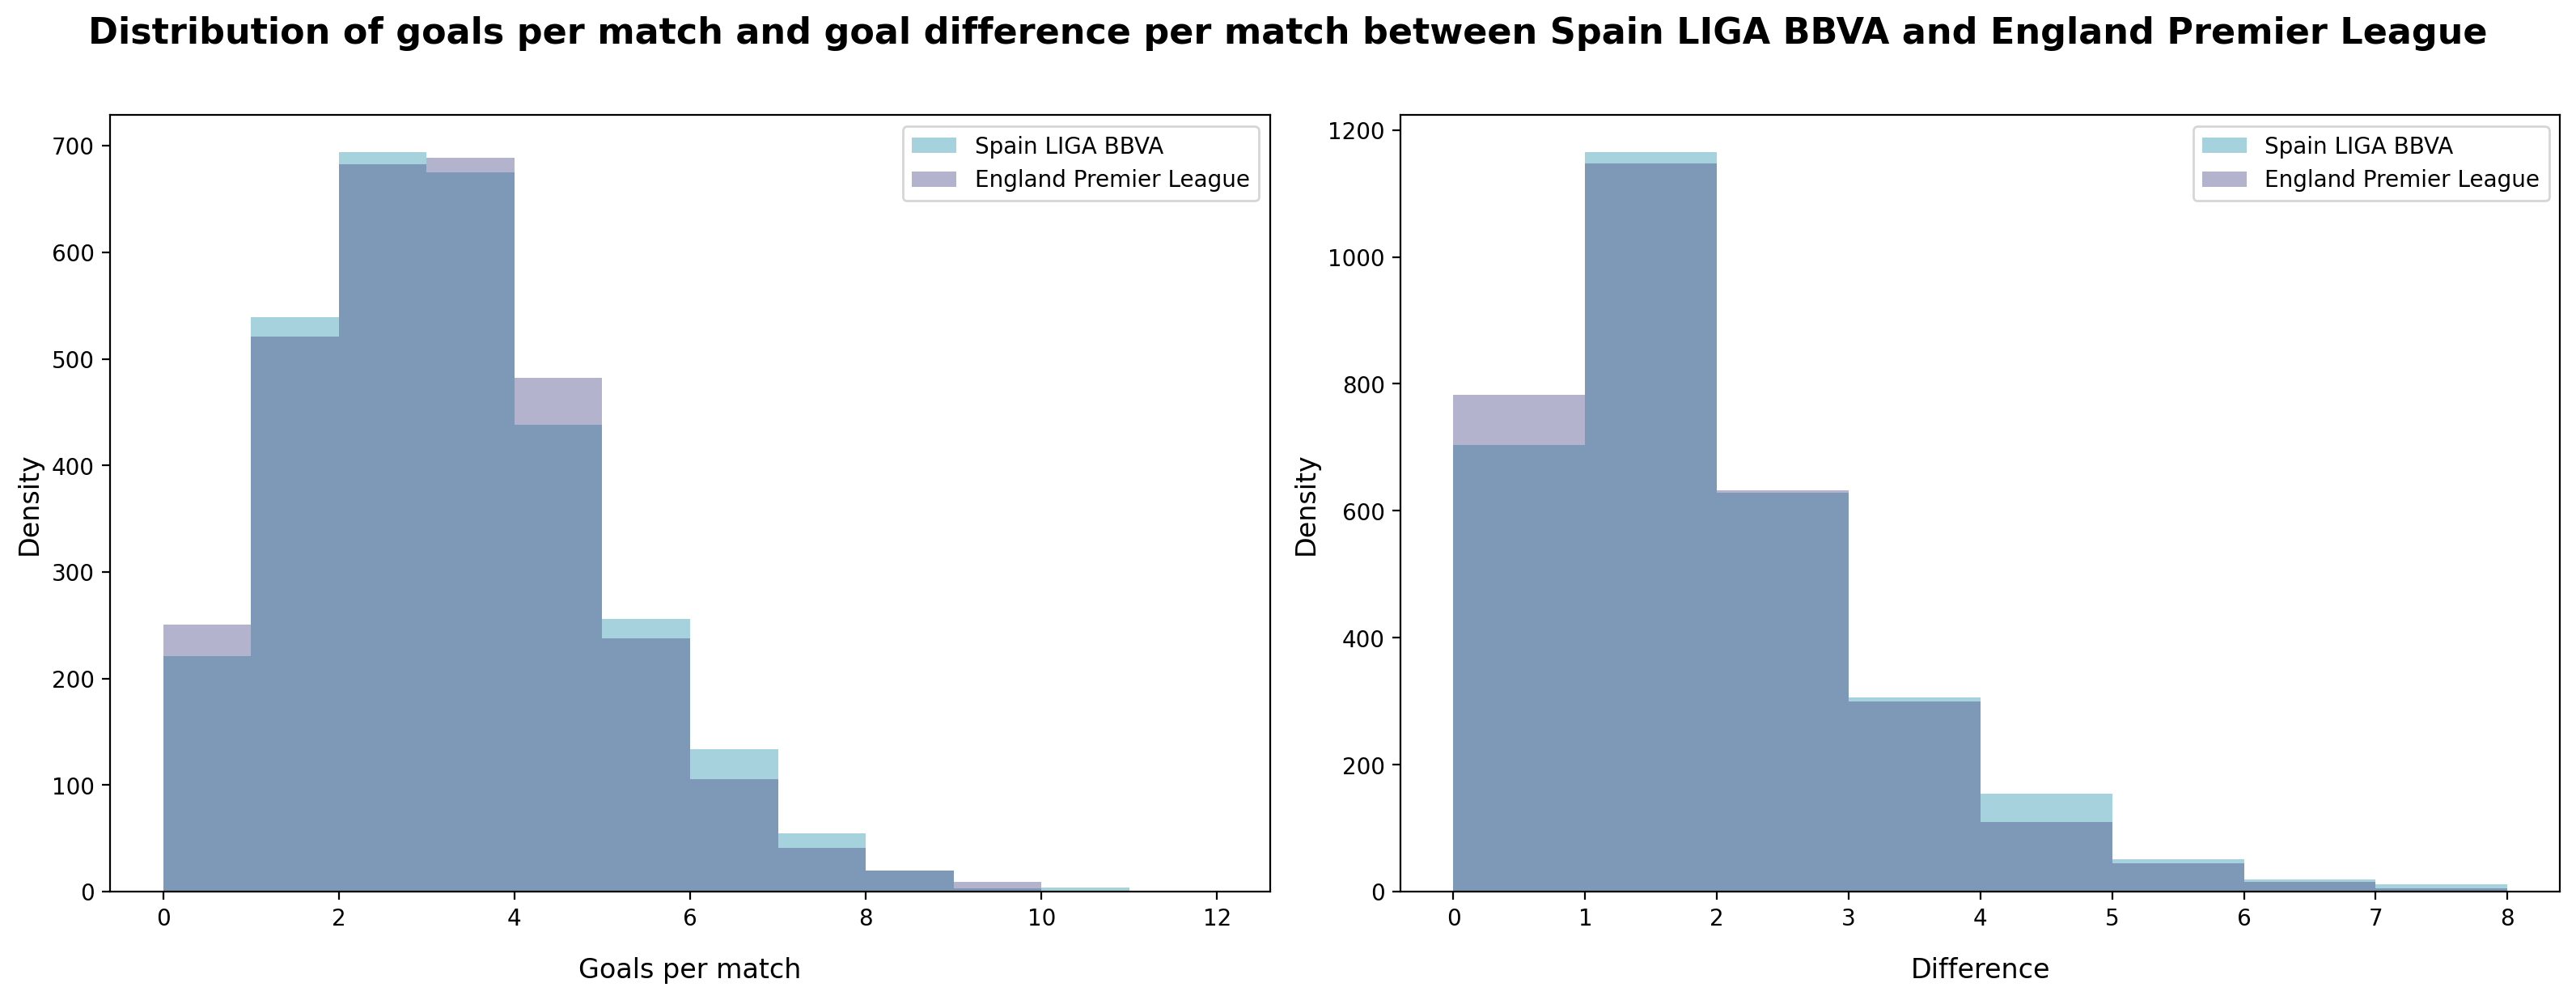

In [90]:
display_step_hists(
    spain_match_info,
    england_match_info,
    ["goals_per_match", "difference"],
    "Distribution of goals per match and goal difference per match between Spain LIGA BBVA and England Premier League",
    "Spain LIGA BBVA",
    "England Premier League",
)

In [91]:
sp_en_goals_diff = compare_means_z(
    spain_match_info, england_match_info, ["goals_per_match", "difference"]
).round(3)

In [92]:
sp_en_goals_diff["significance"] = sp_en_goals_diff["p-value"].apply(evaluate_pvalue)

In [93]:
sp_en_goals_diff

p-value  z-statistic  CI lower  CI upper  \
feature                                                     
goals_per_match    0.197        1.289    -0.029     0.143   
difference         0.003        3.019     0.034     0.162   

                                 significance  
feature                                        
goals_per_match           Not enough evidence  
difference       Stat. significant difference

In [94]:
spain_match_info["outcome"].value_counts()

Home    1485
Away     851
Draw     704
Name: outcome, dtype: int64

In [95]:
england_match_info["outcome"].value_counts()

Home    1390
Away     867
Draw     783
Name: outcome, dtype: int64

#### Findings

1. Hypothesis testing showed that there is not enough evidence to say that Spain LIGA BBVA and England Premier League are different in the number of goals scored per match. It makes sense as both leagues have very similar total number of goals and total number of matches throughout all 8 seasons.
1. However there is statistically significant different in the average goal difference per match between Spain LIGA BBVA and England Premier League. This could indicate differences in team features, skills or strategies.
1. England Premier League has a bit more matches with the result 'Draw', meaning that more teams are at similar level in this league comparing with Spain league. 

### Team performance and attributes comparison between Spain LIGA BBVA and England Premier League

#### Description of team attributes

- Build up play speed - the speed in which attacks are put together. Values in range from 1 to 100 (Slow -> Balanced -> Fast)
- Build up play passing - passing distance. Values in range from 1 to 100 (Short -> Mixed -> Long)
- Chance creation passing - amount of risk in pass decision. Values in range from 1 to 100 (Safe -> Normal -> Risky)
- Chance creation crossing - the frequency of crosses into the box (cross is generally airborne pass). Values in range from 1 to 100.
- Chance creation shooting - the frequency of shots taken. Values in range from 1 to 100.
- Defence pressure - affects how high up the pitch the team will start pressuring. Values in range from 1 to 100 (Deep -> Medium -> High)
- Defence aggression - affects the team approach to tackling the ball possessor. Values in range from 1 to 100 (Contain -> Press -> Double)
- Defence team width - affects how much the team will shift to the ball side. Values in range from 1 to 100 (Narrow -> Normal -> Wide)

#### Spain LIGA BBVA - team performance & team attributes

In [96]:
spain_wins_percentage = get_wins_percentage(
    spain_match_info, "home_team_name", "away_team_name", "winner"
)

spain_wins_percentage.head(3)

team  count_of_wins  num_of_matches  wins_percentage
0  Athletic Club de Bilbao            122             304            40.13
1          Atlético Madrid            167             304            54.93
2               CA Osasuna             67             228            29.39

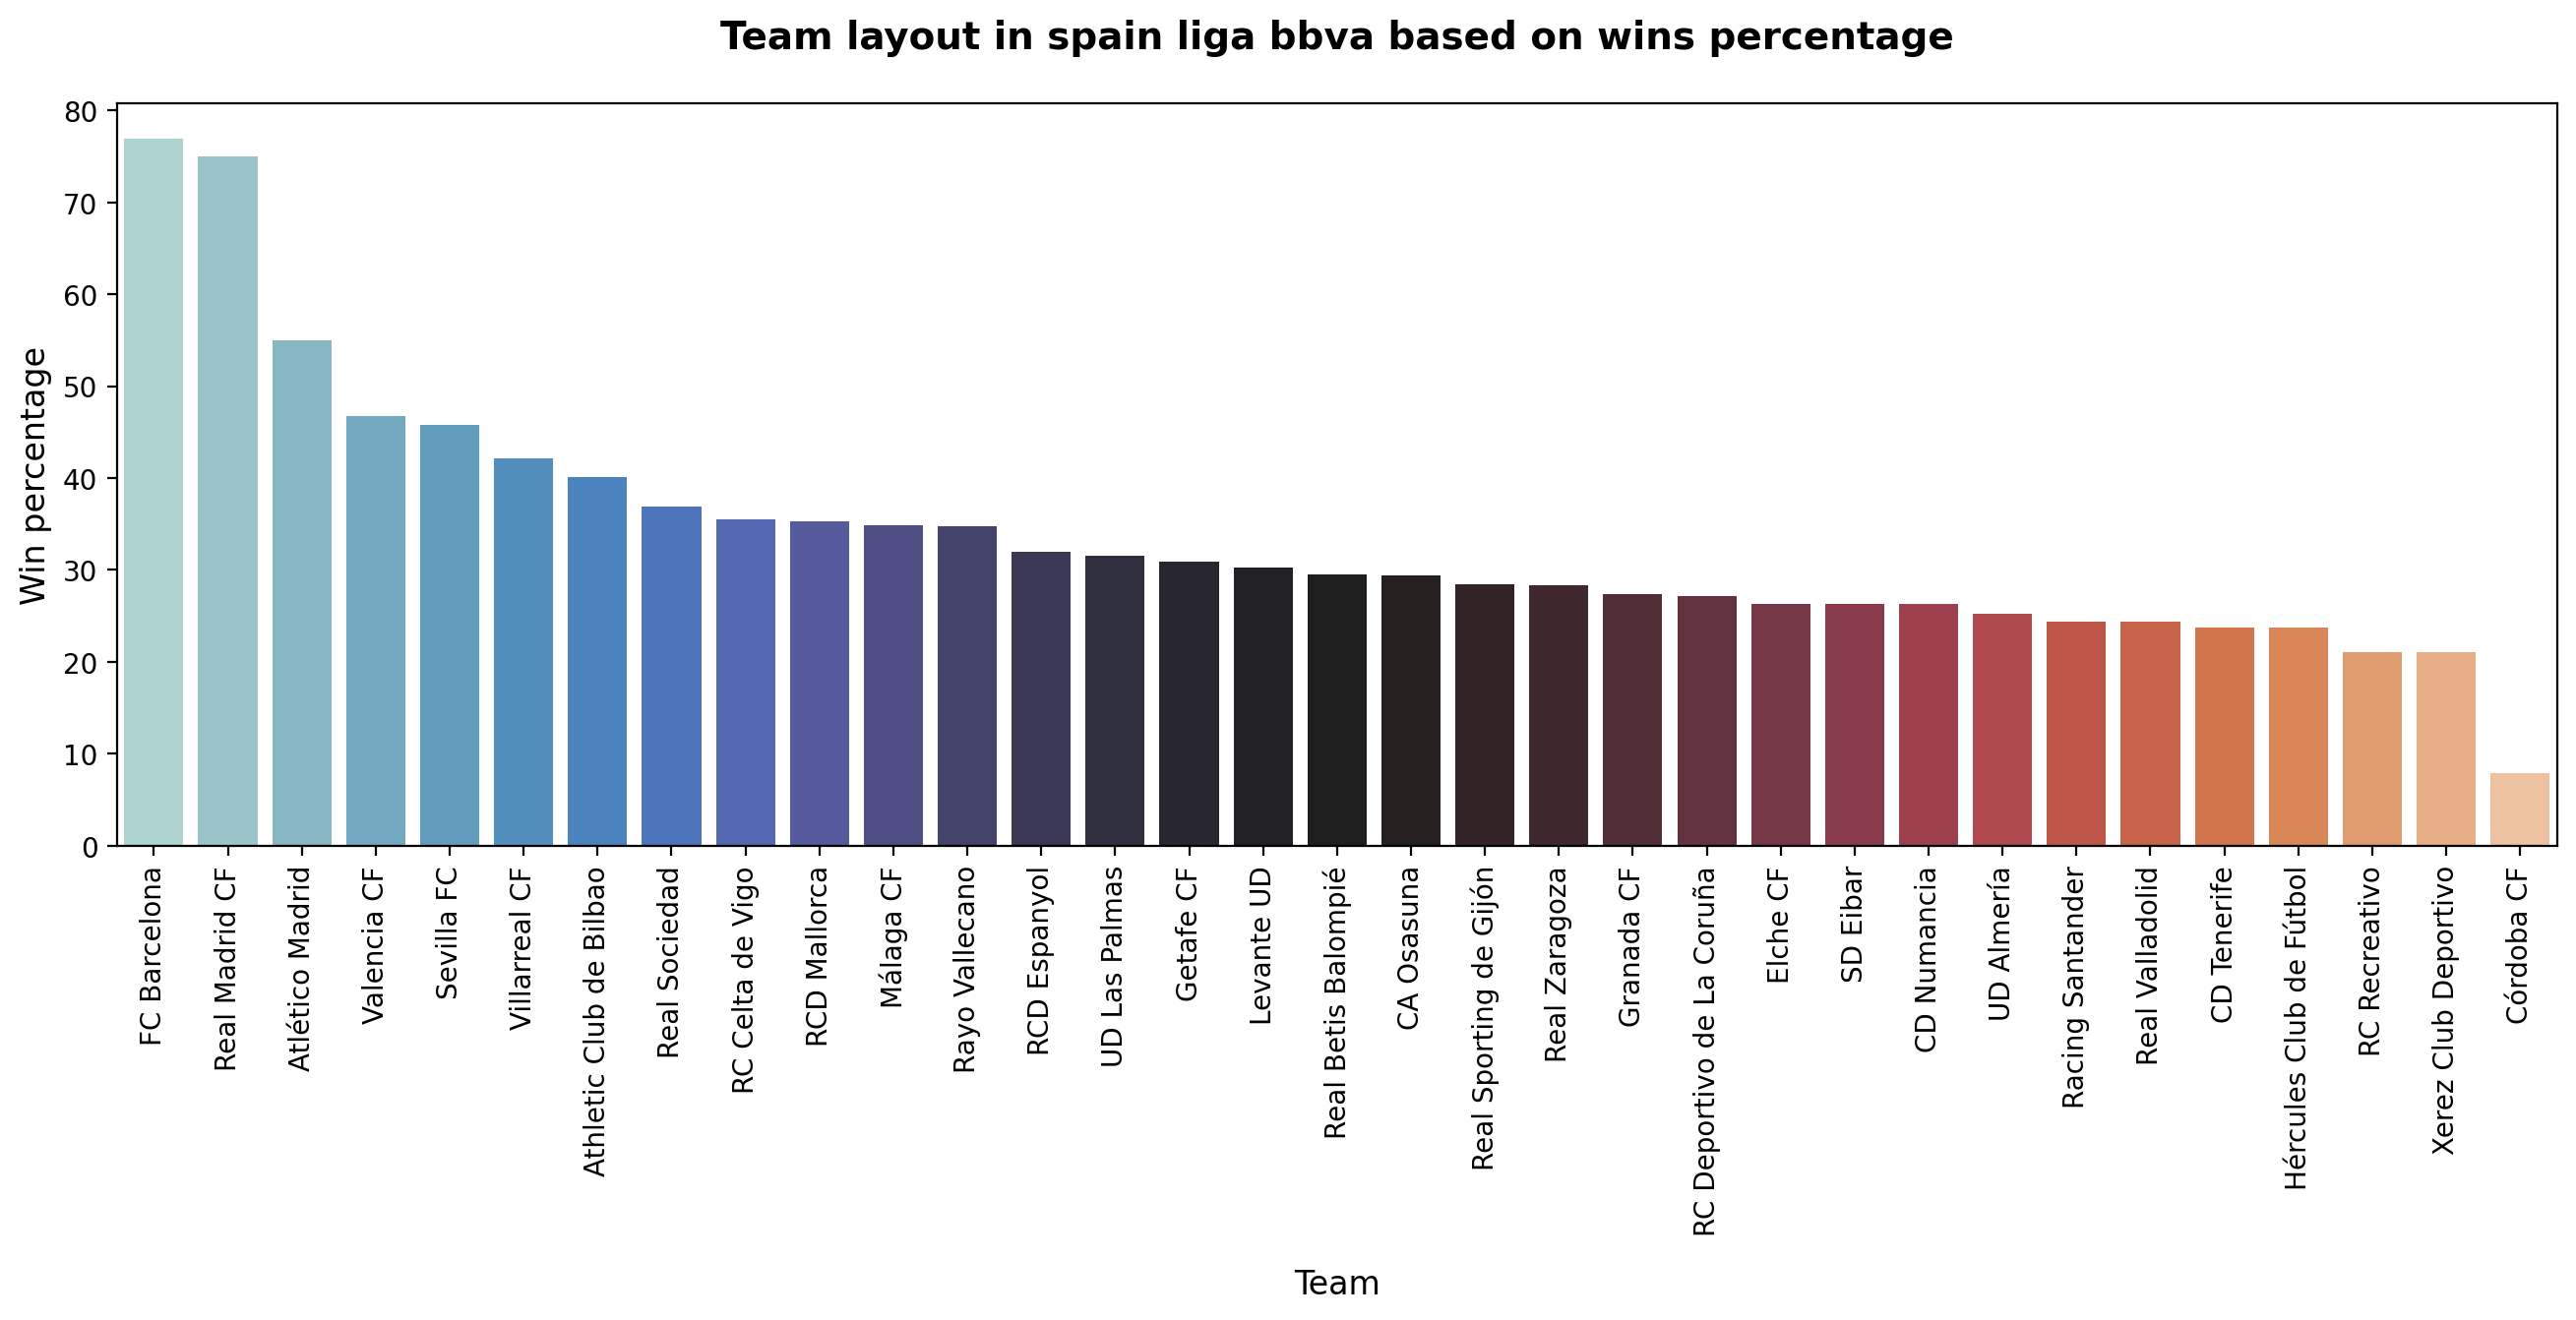

In [97]:
fig, ax = plt.subplots(figsize=(16, 5))

sns.barplot(
    x="team",
    y="wins_percentage",
    data=spain_wins_percentage,
    order=spain_wins_percentage.sort_values(by="wins_percentage", ascending=False)[
        "team"
    ],
    palette="icefire",
)

set_labels(
    ax,
    "Team layout in Spain LIGA BBVA based on wins percentage",
    "team",
    "win percentage",
)

plt.xticks(rotation=90)
plt.show()

In [98]:
spain_team_attr = team_info[team_info["country"] == "Spain"]

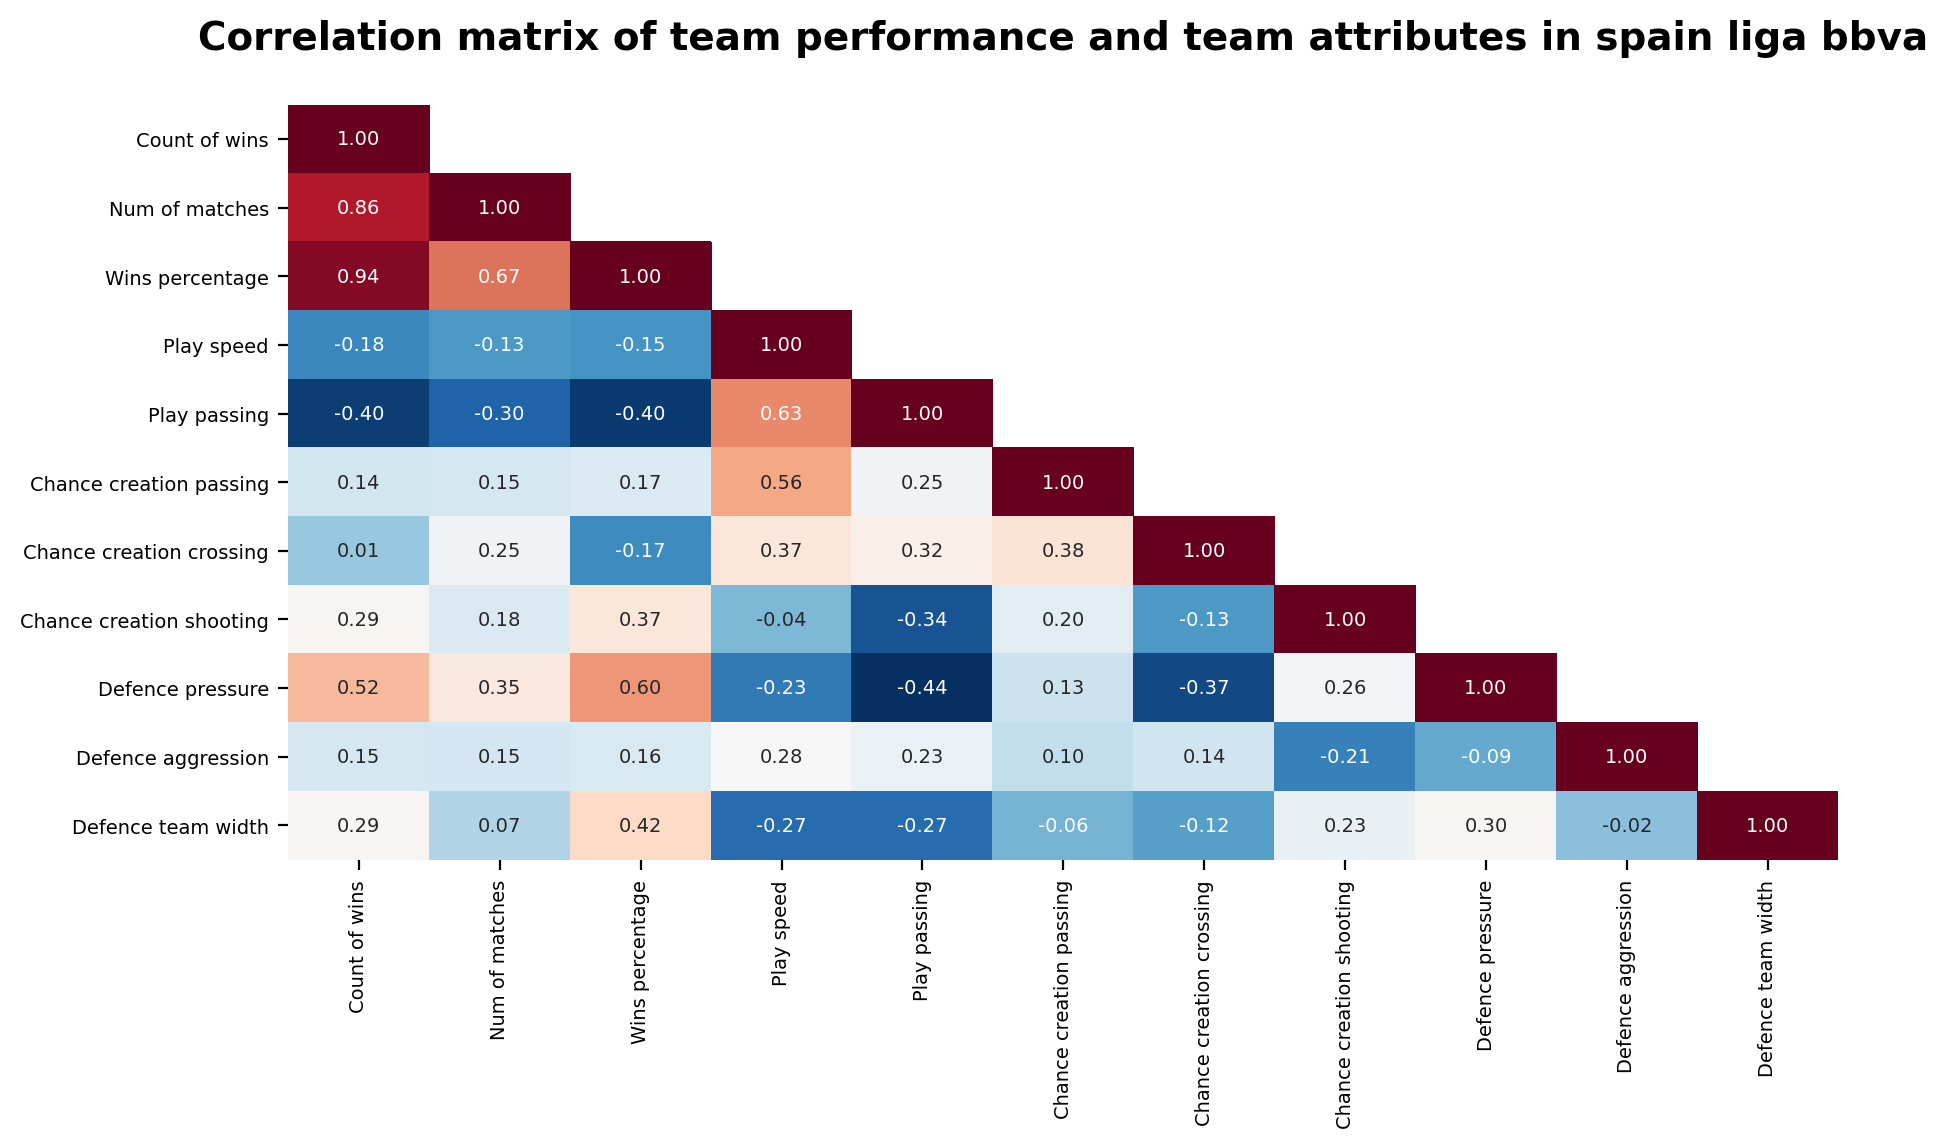

In [99]:
plt.figure(figsize=(10, 5))

spain_corr = spain_wins_percentage.merge(
    spain_team_attr.iloc[:, 4:], left_on="team", right_on="team_name"
).corr()
corr_labels = list(map(replace_corr_labels, spain_corr.columns))

mask = np.triu(spain_corr, 1)
ax = sns.heatmap(
    spain_corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    annot_kws={"fontsize": 7},
    cbar=False,
    xticklabels=corr_labels,
    yticklabels=corr_labels,
)
set_labels(
    ax,
    "Correlation matrix of team performance and team attributes in Spain LIGA BBVA",
    "",
    "",
)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()

In [100]:
sp_corr_wins = (
    spain_corr["wins_percentage"]
    .abs()
    .sort_values(ascending=False)
    .to_frame()
    .rename(columns={"wins_percentage": "coefficient"})
)

sp_corr_wins[(sp_corr_wins["coefficient"] > 0.4) & (sp_corr_wins["coefficient"] < 1)]

coefficient
count_of_wins              0.939217
num_of_matches             0.673613
avg_defence_pressure       0.598934
avg_defence_team_width     0.423294
avg_play_passing           0.404746

- Besides count of wins and number of matches, win percentage of teams in Spain LIGA BBVA has moderate positive correlation with:
    - Defence pressure 
    - Defence team width
- And moderate negative correlation with:
    - Play passing (passing distance)

#### England Premier League - team performance & team attributes

In [101]:
england_wins_percentage = get_wins_percentage(
    england_match_info, "home_team_name", "away_team_name", "winner"
)

england_wins_percentage.head(3)

team  count_of_wins  num_of_matches  wins_percentage
0          Arsenal            170             304            55.92
1      Aston Villa             86             304            28.29
2  Birmingham City             21              76            27.63

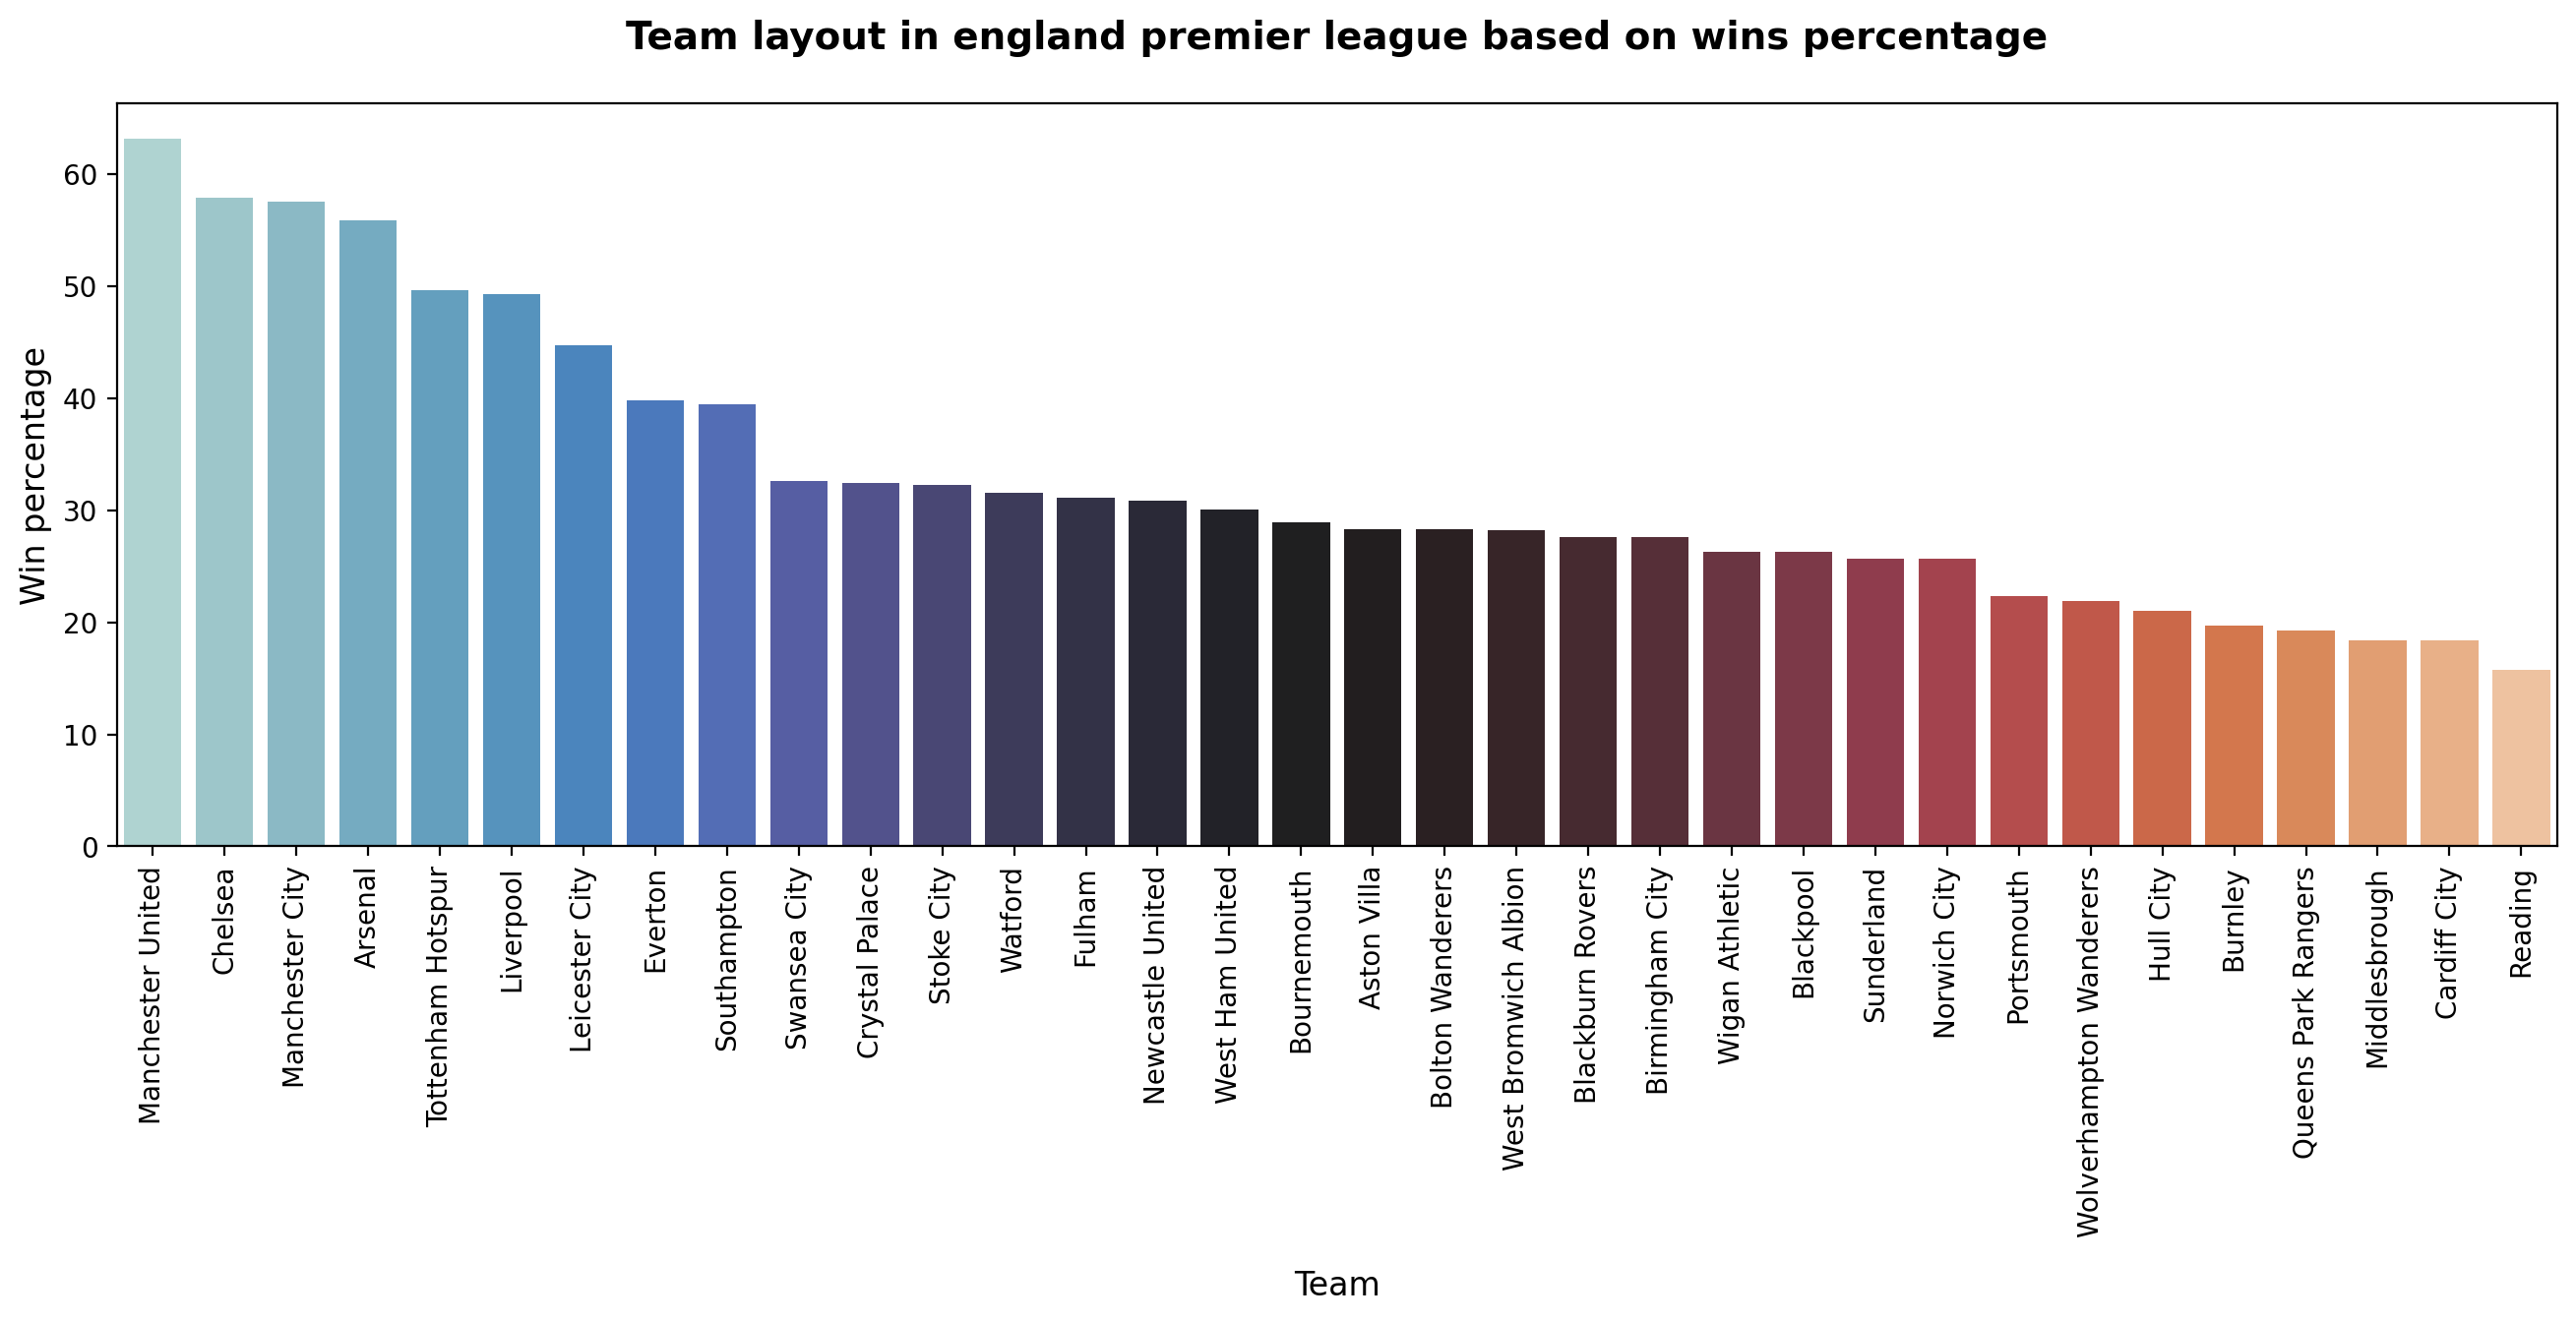

In [102]:
fig, ax = plt.subplots(figsize=(16, 5))

sns.barplot(
    x="team",
    y="wins_percentage",
    data=england_wins_percentage,
    order=england_wins_percentage.sort_values(
        by="wins_percentage",
        ascending=False,
    )["team"],
    palette="icefire",
)

set_labels(
    ax,
    "Team layout in England Premier League based on wins percentage",
    "team",
    "win percentage",
)

plt.xticks(rotation=90)
plt.show()

In [103]:
england_team_attr = team_info[team_info["country"] == "England"]

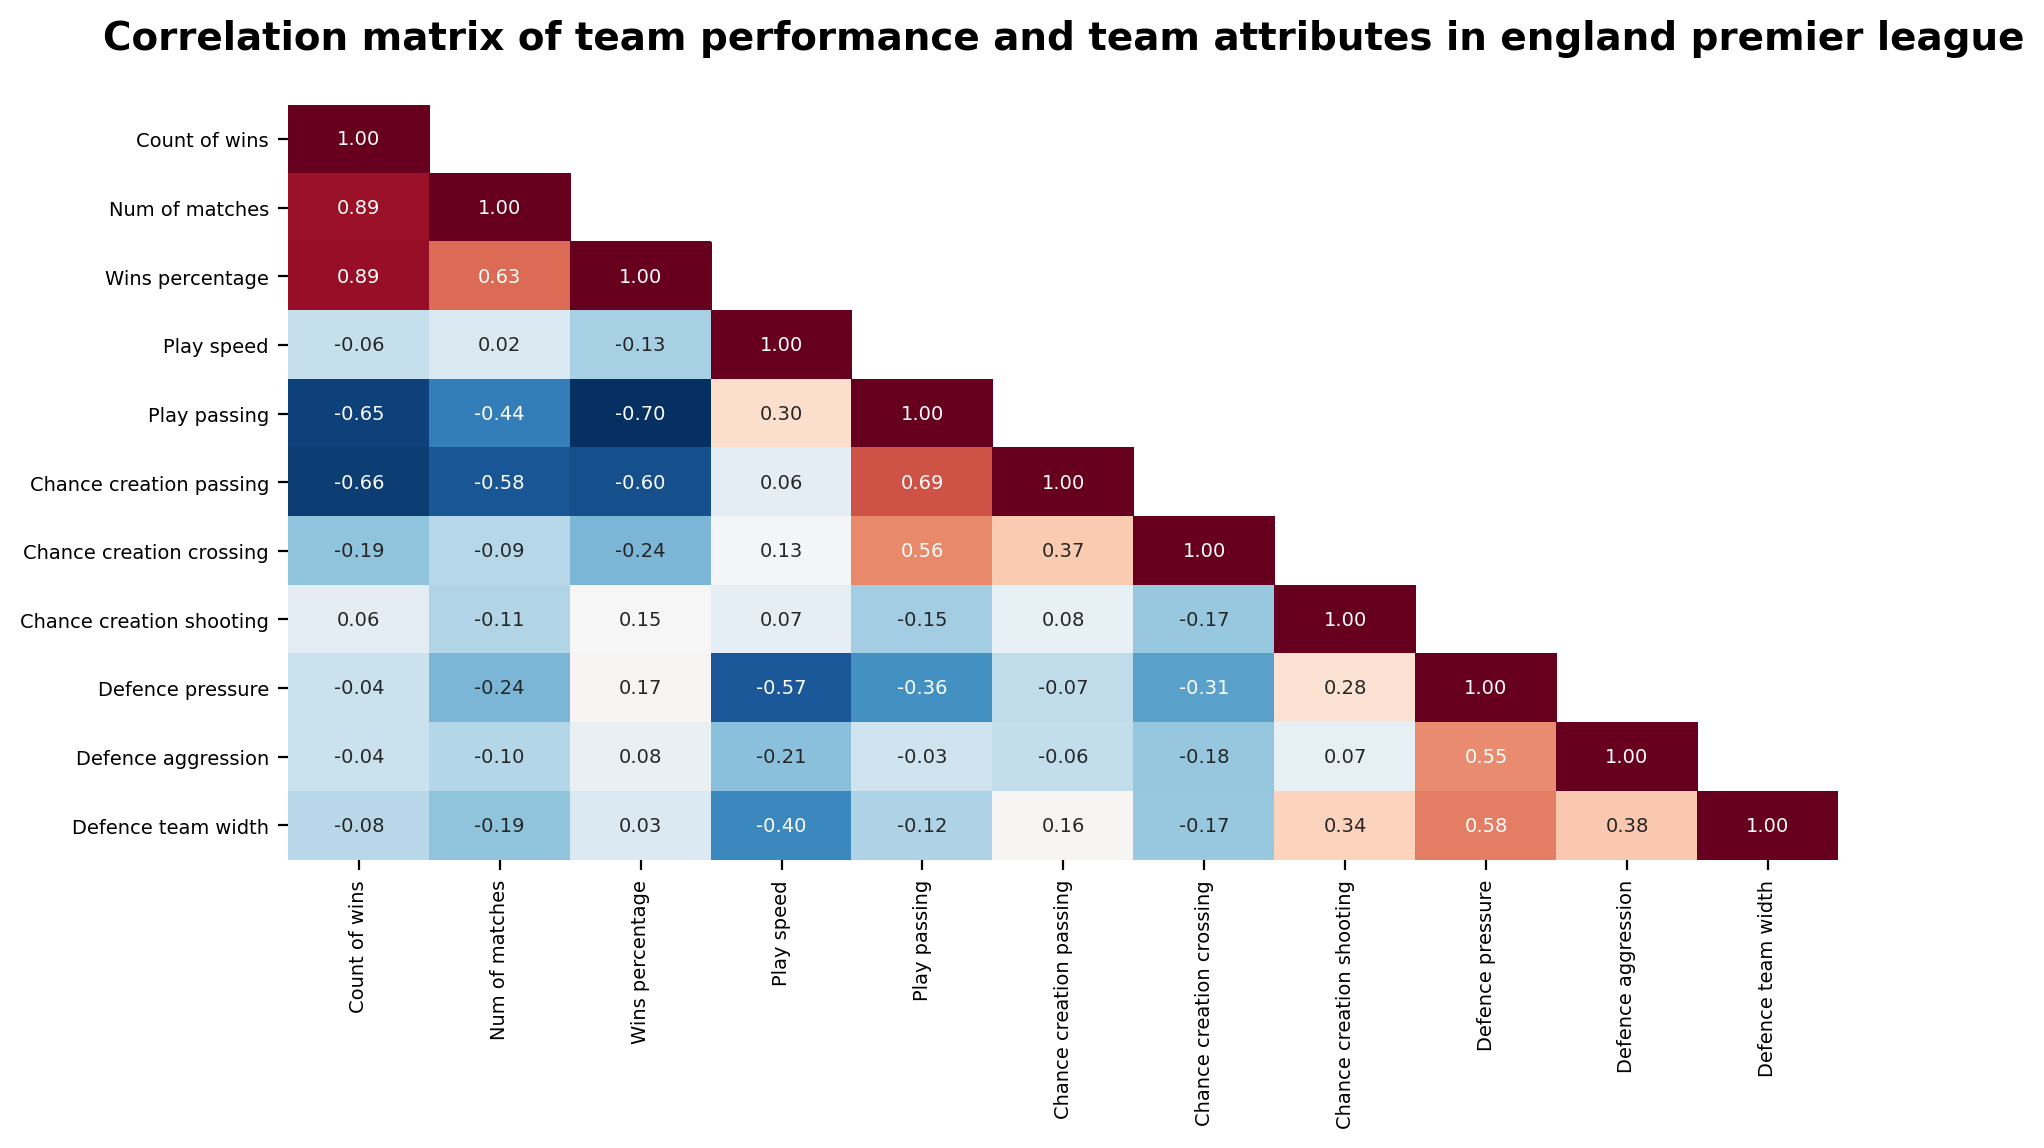

In [104]:
plt.figure(figsize=(10, 5))

eng_corr = england_wins_percentage.merge(
    england_team_attr.iloc[:, 4:], left_on="team", right_on="team_name"
).corr()

mask = np.triu(eng_corr, 1)
ax = sns.heatmap(
    eng_corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    annot_kws={"fontsize": 7},
    cbar=False,
    xticklabels=corr_labels,
    yticklabels=corr_labels,
)

set_labels(
    ax,
    "Correlation matrix of team performance and team attributes in England Premier League",
    "",
    "",
)

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.show()

In [105]:
en_corr_wins = (
    eng_corr["wins_percentage"]
    .abs()
    .sort_values(ascending=False)
    .to_frame()
    .rename(columns={"wins_percentage": "coefficient"})
)

en_corr_wins[(en_corr_wins["coefficient"] > 0.4) & (en_corr_wins["coefficient"] < 1)]

coefficient
count_of_wins                   0.888586
avg_play_passing                0.701996
num_of_matches                  0.632725
avg_chance_creation_passing     0.600845

- Besides count of wins and number of matches, win percentage of teams in England Premier League has moderate to high negative correlation with:
    - Play passing (passing distance)
    - Chance creation passing (amount of risk in pass decision)

#### Insights
1. Based on correlation of win percentage with team attributes for Spain LIGA BBVA and England Premier League, it seems that wins and losses are impacted by different team features in these two leagues.
1. In order to prove if/how these two leagues differ from one another, hypothesis testing is performed using 8 team features (attributes). The original dataframe on team attributes contains measurements from 2010 to 2015 but not all teams there measured each year, therefore averages are used for hypothesis testing.

#### Hypothesis testing and Confidence intervals

Considering 2008-2016 (8 seasons) soccer data for Spain LIGA BBVA and England Premier League, does Spain LIGA BBVA have significantly different mean of teams' attributes than England Premier League?

**Population**: team attributes for each team in Spain LIGA BBVA and team attributes for each team in England Premier League   
**Parameter of Interest**: difference in means ($\mu_1 - \mu_2$)  
**Null Hypothesis:** there is no difference in mean of the same team attribute between Spain LIGA BBVA and England Premier League ($\mu_1 = \mu_2$)  
**Alternative Hypthosis:** there is a statistically significant difference in mean of the same team attribute between Spain LIGA BBVA and England Premier League ($\mu_1 \neq \mu_2$)

**Significance level (alfa):** 0.05

In [106]:
spain_team_attr.shape[0]

33

In [107]:
england_team_attr.shape[0]

34

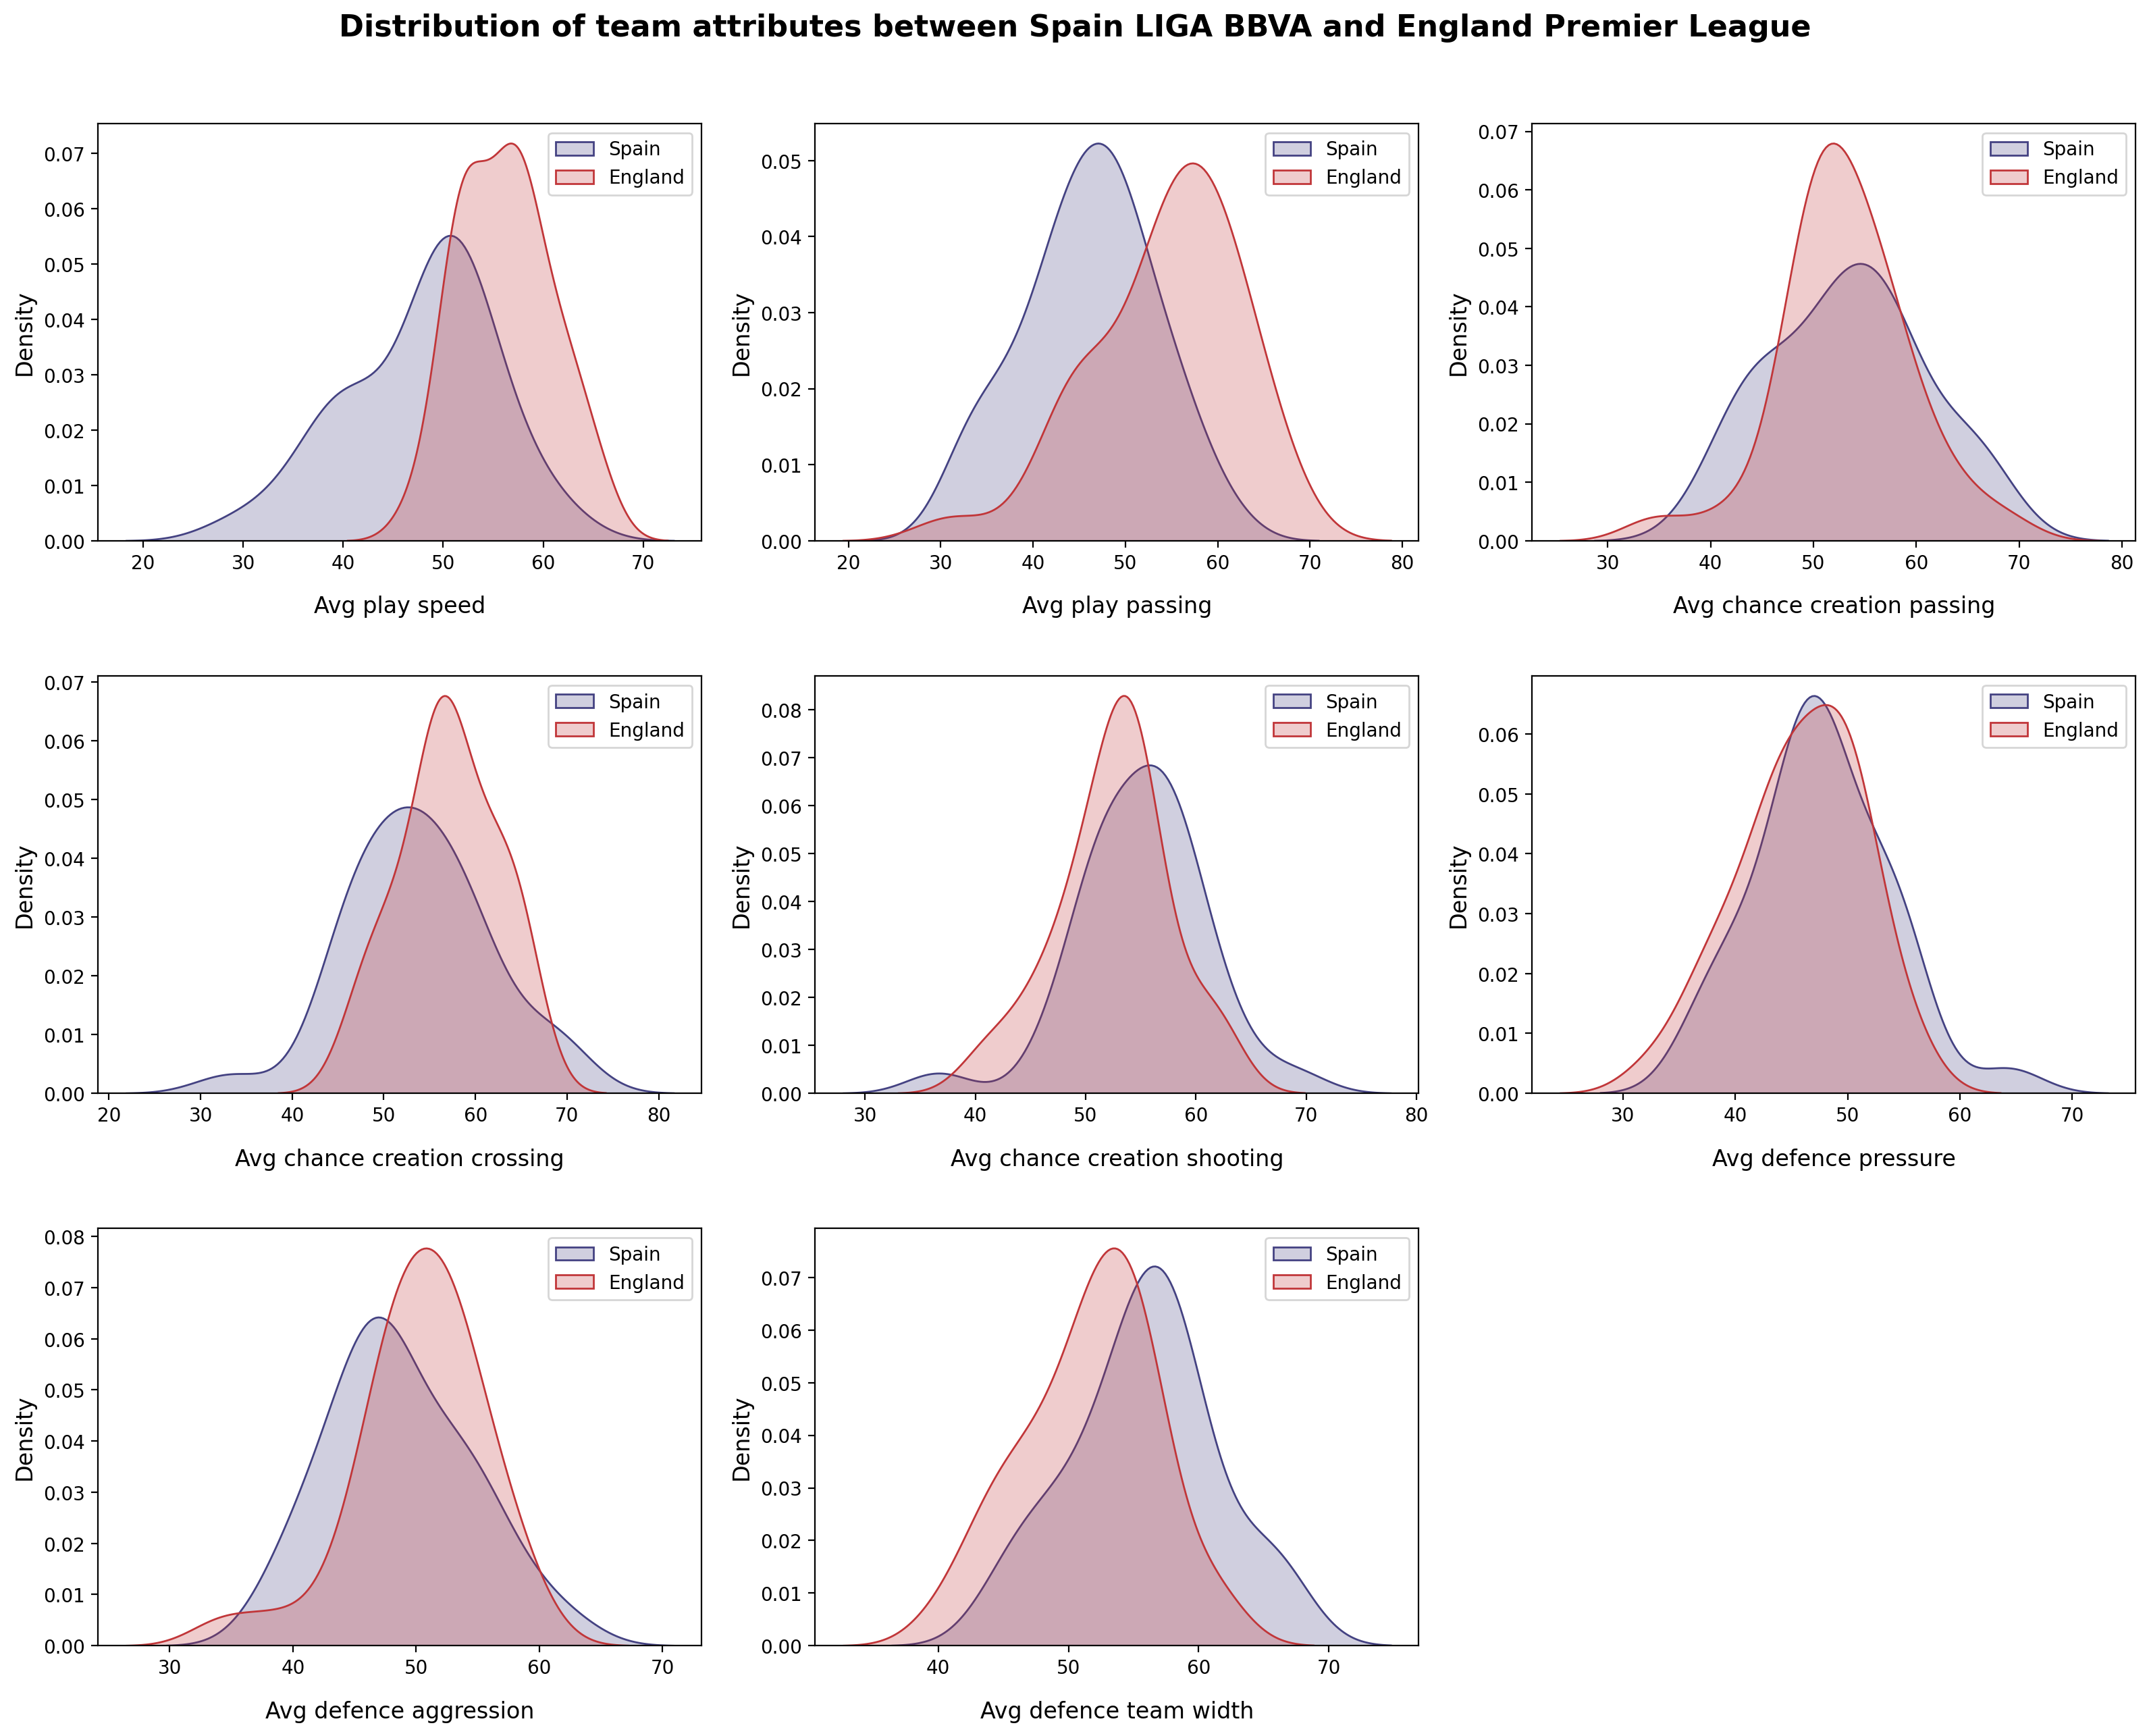

In [108]:
cols = [col for col in team_info if col.startswith("avg")]

display_dists(
    spain_team_attr,
    england_team_attr,
    cols,
    "Distribution of team attributes between Spain LIGA BBVA and England Premier League",
    "Spain",
    "England",
)

In [109]:
sp_en_diff_in_means = compare_means_t(
    spain_team_attr,
    england_team_attr,
    cols,
).round(3)

In [110]:
sp_en_diff_in_means["significance"] = sp_en_diff_in_means["p-value"].apply(
    evaluate_pvalue
)

In [111]:
sp_en_diff_in_means

p-value  t-statistic  CI lower  CI upper  \
feature                                                                  
avg_play_speed                  0.000       -5.604   -11.519    -5.446   
avg_play_passing                0.000       -4.562   -12.021    -4.700   
avg_chance_creation_passing     0.841        0.202    -3.041     3.724   
avg_chance_creation_crossing    0.045       -2.047    -6.589    -0.072   
avg_chance_creation_shooting    0.068        1.855    -0.192     5.158   
avg_defence_pressure            0.185        1.339    -0.921     4.666   
avg_defence_aggression          0.261       -1.135    -4.227     1.165   
avg_defence_team_width          0.002        3.233     1.606     6.800   

                                              significance  
feature                                                     
avg_play_speed                Stat. significant difference  
avg_play_passing              Stat. significant difference  
avg_chance_creation_passing            Not enough evidence  
avg_chance_creation_crossing  Stat. significant difference  
avg_chance_creation_shooting           Not enough evidence  
avg_defence_pressure                   Not enough evidence  
avg_defence_aggression                 Not enough evidence  
avg_defence_team_width        Stat. significant difference

#### Findings

1. Hypothesis testing proved that there are 4 team attributes that have statistically significant difference between Spain LIGA BBVA and England Premier League:
    - Build up play speed - England teams tend to play at higher speed during attacks
    - Build up play passing - England teams tend to use larger passing distance during attacks
    - Chance creation crossing - England teams tend to cross more frequently than Spain teams
    - Defence team width - Spain teams tend to use wider formations during defence
1. In general, seems that these two leagues apply quite a different approaches and techniques:
    - England Premier League favour more of a dynamic style of play based on speed and passes.
    - Spain LIGA BBVA focus on the ability to shield the ball. Defending tends to involve pressing the opponent high up the pitch and forcing mistakes in possession. 
1. Comparison at league level gives a general understanding of distinctive style of the game that each league has but leagues don't have matches between each other. Betting usually is done at match level - which team will win, how much, what is the difference, etc.
1. In order to understand differences and dynamics inside the league but not going through all the teams in the league, teams are organized into two groups: favorites and underdogs based on percentage of wins and analyzed accordingly.

### Favorites vs Underdogs in Spain LIGA BBVA

**Favorites** - teams that won over 50% of played matches.    
**Underdogs** - teams that won equal or less than 50% of played matches. 

Source: https://www.actionnetwork.com/how-to-bet-on-sports/general/sports-betting-for-beginners-10-things-to-know?fbclid=IwAR0xrb52osWTkKGO90GXAUsEsSV4Hku1Fdvvp4Nj1CHWZRV2D0lwfukbscE

In [112]:
spain_favs = spain_wins_percentage[
    spain_wins_percentage["wins_percentage"] > 50
].sort_values(by="wins_percentage", ascending=False)

spain_favs

team  count_of_wins  num_of_matches  wins_percentage
7      FC Barcelona            234             304            76.97
21   Real Madrid CF            228             304            75.00
1   Atlético Madrid            167             304            54.93

In [113]:
spain_top_scorers = (
    player_goals[player_goals["country"] == "Spain"]
    .groupby(["team_name", "player_name"])
    .agg(sum_of_goals=("goals", "sum"))
    .reset_index()
)

spain_top_scorers.nlargest(5, columns="sum_of_goals")

team_name        player_name  sum_of_goals
195             FC Barcelona       Lionel Messi           253
748           Real Madrid CF  Cristiano Ronaldo           216
769           Real Madrid CF      Karim Benzema           111
758           Real Madrid CF    Gonzalo Higuain            94
5    Athletic Club de Bilbao       Aritz Aduriz            64

#### Match stats between Favorites and Underdogs **playing home** in Spain LIGA BBVA

#### Hypothesis testing and Confidence intervals

Considering 2008-2016 (8 seasons) soccer data for Spain LIGA BBVA, does favorites in Spain LIGA BBVA have significantly different mean of match attributes (statistics) playing at home than underdogs in Spain LIGA BBVA?

**Population**: match attributes (statistics) playing at home in Spain LIGA BBVA  
**Parameter of Interest**: difference in means ($\mu_1 - \mu_2$)  
**Null Hypothesis:** there is no difference in mean of the same match statistic between favorites and underdogs in Spain LIGA BBVA ($\mu_1 = \mu_2$)  
**Alternative Hypthosis:** there is a statistically significant difference in mean of the same match statistic between favorites and underdogs in Spain LIGA BBVA ($\mu_1 \neq \mu_2$)

**Significance level (alfa):** 0.05

In [114]:
spain_match = match_attr[match_attr["country"] == "Spain"]

In [115]:
spain_match.head(3)

country_id country           league     season  stage  \
21517       21518   Spain  Spain LIGA BBVA  2008/2009      1   
21518       21518   Spain  Spain LIGA BBVA  2008/2009      1   
21519       21518   Spain  Spain LIGA BBVA  2008/2009      1   

                      date  match_api_id  home_team_api_id  \
21517  2008-08-30 00:00:00        530023             10267   
21518  2008-08-31 00:00:00        530084              8371   
21519  2008-08-31 00:00:00        530085              9783   

                  home_team_name  away_team_api_id  away_team_name  \
21517                Valencia CF              8661    RCD Mallorca   
21518                 CA Osasuna             10205   Villarreal CF   
21519  RC Deportivo de La Coruña              8633  Real Madrid CF   

       home_team_goal  away_team_goal  goals_per_match  difference outcome  \
21517               3               0                3           3    Home   
21518               1               1                2           0    Draw   
21519               2               1                3           1    Home   

                          winner  on_target_shot_home_team  \
21517                Valencia CF                       3.0   
21518                       Draw                       1.0   
21519  RC Deportivo de La Coruña                       2.0   

       on_target_shot_away_team  off_target_shot_home_team  \
21517                       0.0                        8.0   
21518                       1.0                        0.0   
21519                       1.0                        5.0   

       off_target_shot_away_team  foul_home_team  foul_away_team  \
21517                       10.0            16.0            14.0   
21518                        0.0             0.0             0.0   
21519                        5.0            17.0            18.0   

       yellow_card_home_team  yellow_card_away_team  red_card_home_team  \
21517                    4.0                    0.0                 0.0   
21518                    2.0                    1.0                 1.0   
21519                    3.0                    3.0                 0.0   

       red_card_away_team  crosses_home_team  crosses_away_team  \
21517                 0.0               15.0                9.0   
21518                 1.0                0.0                0.0   
21519                 0.0               18.0               16.0   

       corner_home_team  corner_away_team  
21517               5.0               6.0  
21518               0.0               0.0  
21519               6.0               5.0

In [116]:
home_cols = [col for col in spain_match if col.endswith("home_team")]

In [117]:
spain_favs_hm_match = spain_match[
    spain_match["home_team_name"].isin(spain_favs["team"].to_list())
].copy()

spain_favs_hm_match.shape[0]

456

In [118]:
spain_unfavs_hm_match = spain_match[
    ~spain_match["home_team_name"].isin(spain_favs["team"].to_list())
].copy()

spain_unfavs_hm_match = spain_unfavs_hm_match.dropna()

spain_unfavs_hm_match.shape[0]

2583

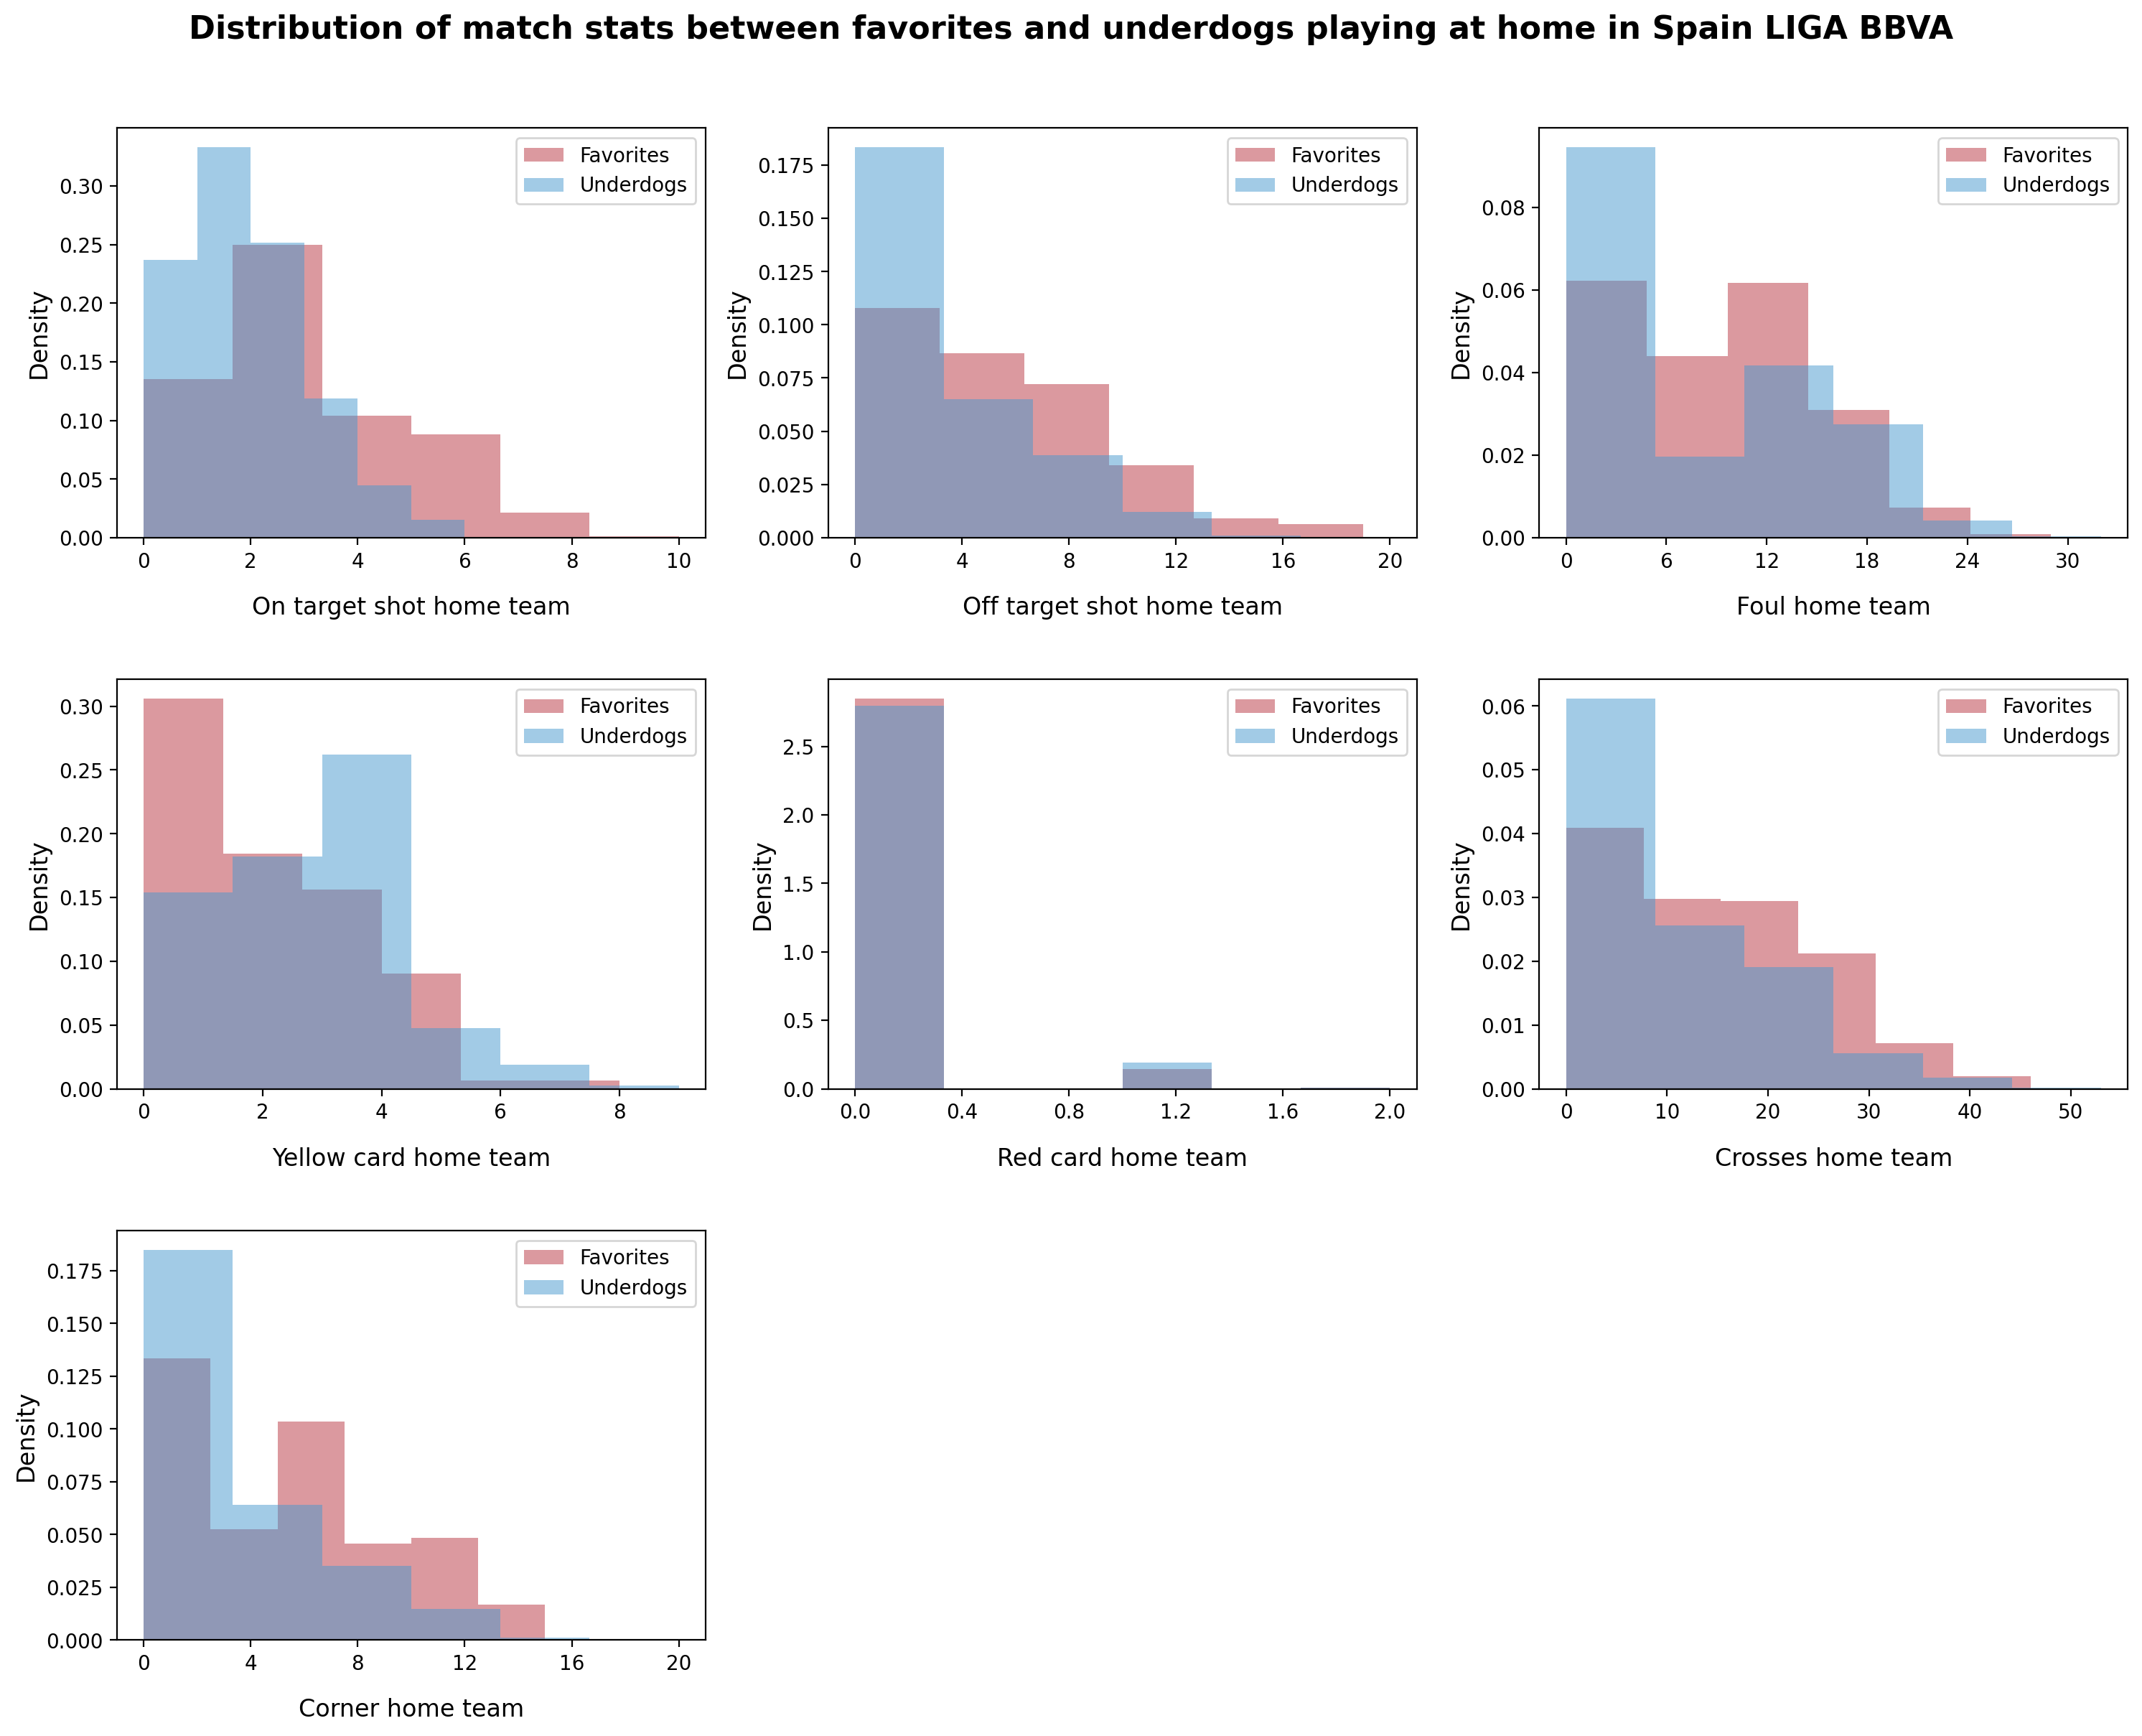

In [119]:
display_hists(
    spain_favs_hm_match,
    spain_unfavs_hm_match,
    home_cols,
    "Distribution of match stats between favorites and underdogs playing at home in Spain LIGA BBVA",
    "Favorites",
    "Underdogs",
)

In [120]:
favs_unfavs_home_diff = compare_means_z(
    spain_favs_hm_match, spain_unfavs_hm_match, home_cols
).round(3)

In [121]:
favs_unfavs_home_diff["significance"] = favs_unfavs_home_diff["p-value"].apply(
    evaluate_pvalue
)

In [122]:
favs_unfavs_home_diff

p-value  z-statistic  CI lower  CI upper  \
feature                                                               
on_target_shot_home_team     0.000       17.516     1.352     1.693   
off_target_shot_home_team    0.000       11.021     1.916     2.746   
foul_home_team               0.000        4.868     1.004     2.362   
yellow_card_home_team        0.000       -8.086    -0.748    -0.456   
red_card_home_team           0.133       -1.502    -0.042     0.006   
crosses_home_team            0.000        8.592     3.718     5.921   
corner_home_team             0.000        9.887     1.612     2.411   

                                           significance  
feature                                                  
on_target_shot_home_team   Stat. significant difference  
off_target_shot_home_team  Stat. significant difference  
foul_home_team             Stat. significant difference  
yellow_card_home_team      Stat. significant difference  
red_card_home_team                  Not enough evidence  
crosses_home_team          Stat. significant difference  
corner_home_team           Stat. significant difference

#### Findings

Hypothesis testing between favorites and underdogs in Spain LIGA BBVA **playing away** could be found in Annex. Results are very similar to the results got from hypothesis testing for match stats **playing at home** so the same conclusions could be applied accordingly.

1. After hypothesis testing, 6 out of 7 match statistics proved to be significantly different between favorites and underdogs in Spain LIGA BBVA playing at home. 
1. The only match event that remain very similar between favorites and underdogs are the number of red cards during the match. This makes sense as the goal is not to receive the red card. A red card prevents a player from playing for the remainder of the match and as a result reduces the number of players that are available to a team.
1. Stat. significant difference for match event statistics remain stable playing away as well. Seems that playing away does not throw favorites out of the winning course.

### Favorites vs Underdogs in England Premier League

In [123]:
england_favs = england_wins_percentage[
    england_wins_percentage["wins_percentage"] > 50
].sort_values(by="wins_percentage", ascending=False)

england_favs

team  count_of_wins  num_of_matches  wins_percentage
17  Manchester United            192             304            63.16
9             Chelsea            176             304            57.89
16    Manchester City            175             304            57.57
0             Arsenal            170             304            55.92

In [124]:
england_top_scorers = (
    player_goals[player_goals["country"] == "England"]
    .groupby(["team_name", "player_name"])
    .agg(sum_of_goals=("goals", "sum"))
    .reset_index()
)

england_top_scorers.nlargest(5, columns="sum_of_goals")

team_name       player_name  sum_of_goals
614  Manchester United      Wayne Rooney           108
558    Manchester City     Sergio Aguero            95
492          Liverpool       Luis Suarez            69
40             Arsenal  Robin van Persie            62
38             Arsenal    Olivier Giroud            55

#### Match stats between Favorites and Underdogs **playing home** in England Premier League

#### Hypothesis testing and Confidence intervals

Considering 2008-2016 (8 seasons) soccer data for England Premier League, does favorites in England Premier League have significantly different mean of home match attributes (statistics) than underdogs in England Premier League?

**Population**: home match attributes (statistics) in  England Premier League  
**Parameter of Interest**: difference in means ($\mu_1 - \mu_2$)  
**Null Hypothesis:** there is no difference in mean of the same match statistic between favorites and underdogs in  England Premier League ($\mu_1 = \mu_2$)  
**Alternative Hypthosis:** there is a statistically significant difference in mean of the same match statistic between favorites and underdogs in  England Premier League ($\mu_1 \neq \mu_2$)

**Significance level (alfa):** 0.05

In [125]:
england_match = match_attr[match_attr["country"] == "England"]

In [126]:
england_match.head(3)

country_id  country                  league     season  stage  \
1728        1729  England  England Premier League  2008/2009      1   
1729        1729  England  England Premier League  2008/2009      1   
1730        1729  England  England Premier League  2008/2009      1   

                     date  match_api_id  home_team_api_id     home_team_name  \
1728  2008-08-17 00:00:00        489042             10260  Manchester United   
1729  2008-08-16 00:00:00        489043              9825            Arsenal   
1730  2008-08-16 00:00:00        489044              8472         Sunderland   

      away_team_api_id        away_team_name  home_team_goal  away_team_goal  \
1728             10261      Newcastle United               1               1   
1729              8659  West Bromwich Albion               1               0   
1730              8650             Liverpool               0               1   

      goals_per_match  difference outcome     winner  \
1728                2           0    Draw       Draw   
1729                1           1    Home    Arsenal   
1730                1           1    Away  Liverpool   

      on_target_shot_home_team  on_target_shot_away_team  \
1728                       1.0                       1.0   
1729                       1.0                       0.0   
1730                       0.0                       1.0   

      off_target_shot_home_team  off_target_shot_away_team  foul_home_team  \
1728                       10.0                        9.0            16.0   
1729                       13.0                        3.0            11.0   
1730                        3.0                        5.0            13.0   

      foul_away_team  yellow_card_home_team  yellow_card_away_team  \
1728            11.0                    3.0                    0.0   
1729             9.0                    0.0                    0.0   
1730            12.0                    0.0                    2.0   

      red_card_home_team  red_card_away_team  crosses_home_team  \
1728                 0.0                 0.0               24.0   
1729                 0.0                 0.0               21.0   
1730                 0.0                 0.0               15.0   

      crosses_away_team  corner_home_team  corner_away_team  
1728                9.0               6.0               6.0  
1729                7.0               7.0               5.0  
1730               19.0               1.0               8.0

In [127]:
england_favs_hm_match = england_match[
    england_match["home_team_name"].isin(england_favs["team"].to_list())
].copy()

england_favs_hm_match.shape[0]

608

In [128]:
england_unfavs_hm_match = england_match[
    ~england_match["home_team_name"].isin(england_favs["team"].to_list())
].copy()

england_unfavs_hm_match.shape[0]

2432

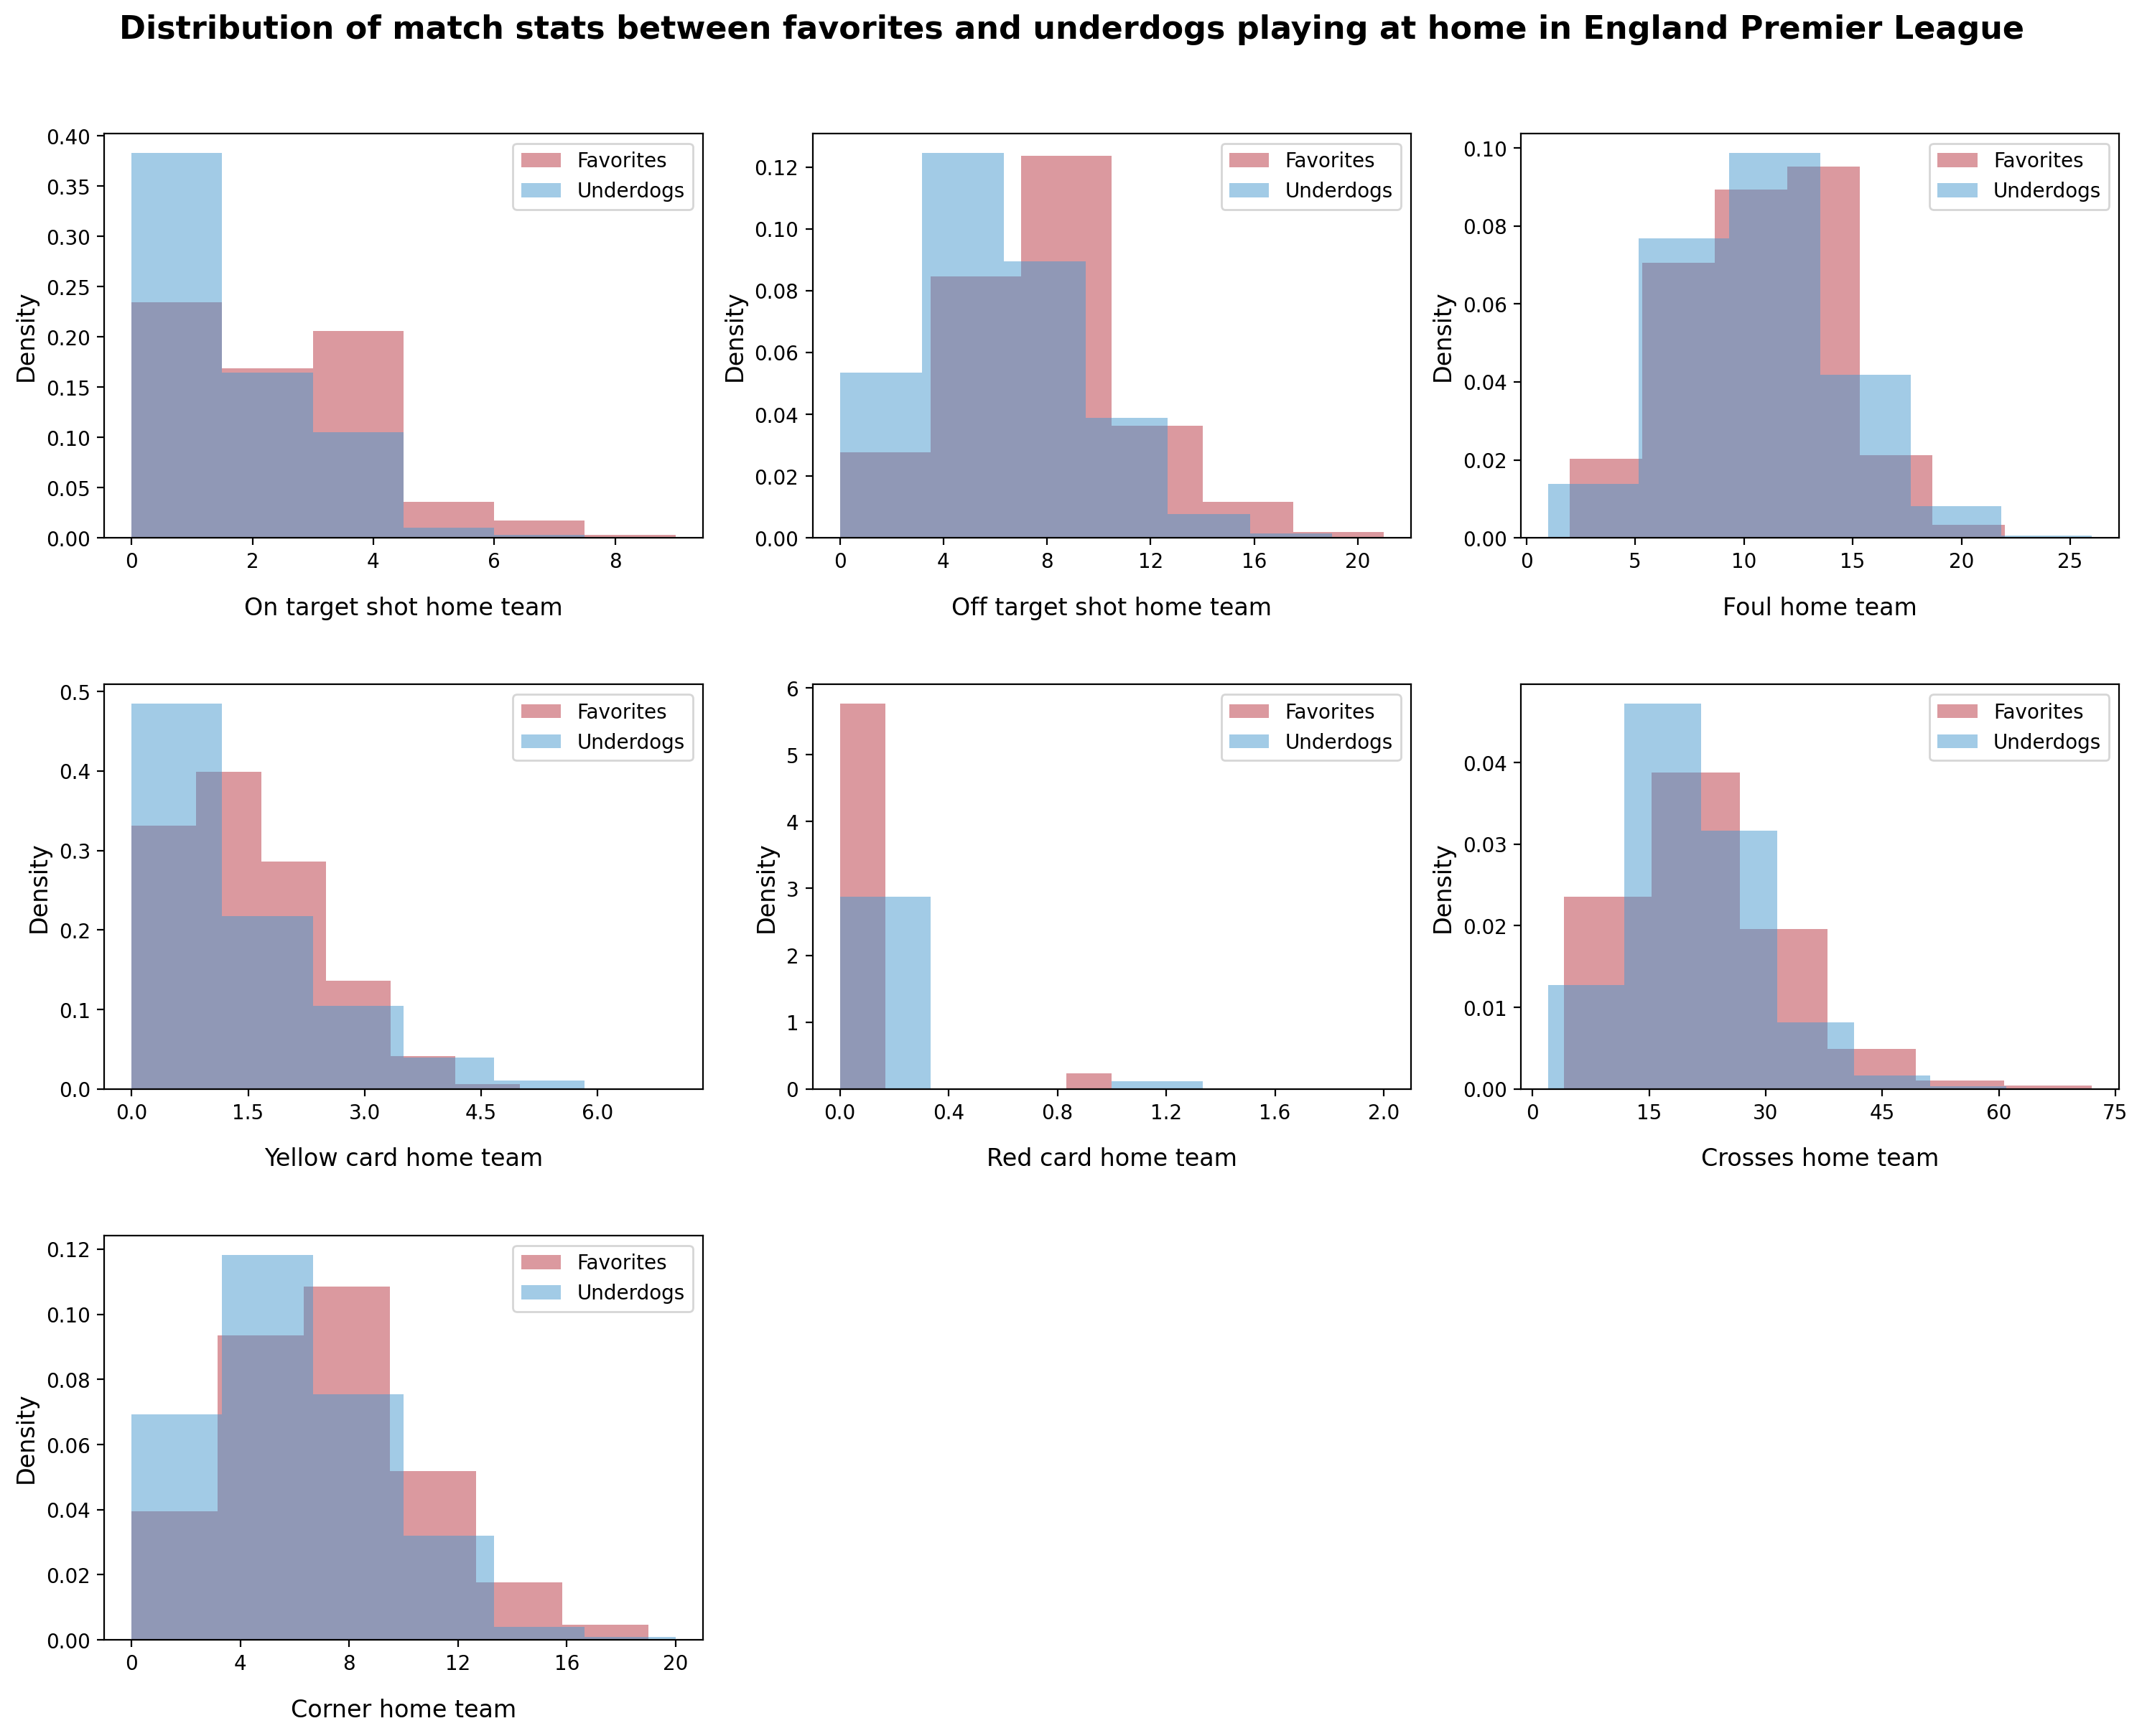

In [129]:
display_hists(
    england_favs_hm_match,
    england_unfavs_hm_match,
    home_cols,
    "Distribution of match stats between favorites and underdogs playing at home in England Premier League",
    "Favorites",
    "Underdogs",
)

In [130]:
en_favs_unfavs_home_diff = compare_means_z(
    england_favs_hm_match, england_unfavs_hm_match, home_cols
).round(3)

In [131]:
en_favs_unfavs_home_diff["significance"] = en_favs_unfavs_home_diff["p-value"].apply(
    evaluate_pvalue
)

In [132]:
en_favs_unfavs_home_diff

p-value  z-statistic  CI lower  CI upper  \
feature                                                               
on_target_shot_home_team     0.000       11.905     0.678     0.946   
off_target_shot_home_team    0.000        8.788     1.003     1.580   
foul_home_team               0.183       -1.332    -0.520     0.100   
yellow_card_home_team        0.004       -2.915    -0.251    -0.049   
red_card_home_team           0.748       -0.321    -0.020     0.015   
crosses_home_team            0.000        4.297     1.016     2.725   
corner_home_team             0.000        9.506     1.118     1.699   

                                           significance  
feature                                                  
on_target_shot_home_team   Stat. significant difference  
off_target_shot_home_team  Stat. significant difference  
foul_home_team                      Not enough evidence  
yellow_card_home_team      Stat. significant difference  
red_card_home_team                  Not enough evidence  
crosses_home_team          Stat. significant difference  
corner_home_team           Stat. significant difference

#### Findings

Hypothesis testing between favorites and underdogs in England Premier League **playing away** could be found in Annex. Results are very similar to the results got from hypothesis testing for match stats **playing at home** so the same conclusions could be applied accordingly.

1. After hypothesis testing, 5 out of 7 match statistics proved to be significantly different in mean, between favorites and underdogs in England Premier League playing at home. 
1. Match event statistics that have not enough evidence for proving difference in mean are number of fouls and red cards. In the previous section, it was proved that England Premier League has a dynamic style of the game and this could lead to more fouls during the match for both favorites and underdogs.
1. Stat. significant mean difference for match event statistics remain stable playing away as well. Seems that playing away does not throw favorites out of the winning course.

**Suggestions for betting**

Stat. significant mean difference in almost all match statistics shows that favorites apply recognizably distinctive style and strategy of the game than underdogs and this offers possibilities for betting on the event in the match (like betting on corner goals, on or off target shots, etc.), aka. in-play betting.

***

## Machine Learning

 - Different features are dominant in different leagues, also the amount of data available differs from league to league, therefore it would be sensible to create prediction model for each league separately. However, to limit the depth of this project, I don't specify the league for predictions.
 - In the first part of predicting the match outcome, models are fitted on data including team attributes and each player rating.
 - In the second part, models are fitted on data including team attributes, player rating and match event data.
 - The same logic is applied for predicting goals that team will score during the match.

In [133]:
match_player = match_player.dropna()
match_player["date"] = pd.to_datetime(match_player["date"])
match_player = match_player.sort_values(by="date")

In [134]:
team_attributes = team_attributes.drop(columns="build_up_play_dribbling")
team_attributes["date"] = pd.to_datetime(team_attributes["date"])
team_attributes = team_attributes.sort_values(by="date")
team_attributes_num = team_attributes.select_dtypes(exclude="object")

In [135]:
for team_id in ["home_team_api_id", "away_team_api_id"]:
    temp = team_attributes_num.add_prefix(team_id[:5])

    match_player = pd.merge_asof(
        match_player,
        temp,
        left_on="date",
        right_on=team_id[:5] + "date",
        left_by=team_id,
        right_by=team_id[:5] + "team_api_id",
    )

In [136]:
match_player_team = match_player.drop(
    ["home_team_api_id", "away_team_api_id", "home_date", "away_date"], axis=1
)

In [137]:
player_rating = player_attributes[["player_api_id", "date", "overall_rating"]].copy()
player_rating["date"] = pd.to_datetime(player_rating["date"])
player_rating = player_rating.sort_values(by="date")
player_rating = player_rating.dropna()

In [138]:
for player in match_player.filter(like="player").columns:

    match_player_team[player] = match_player_team[player].astype("int64")
    temp = player_rating.rename(columns={player_rating.columns[-1]: player + "_rating"})

    match_player_team = pd.merge_asof(
        match_player_team,
        temp,
        left_on="date",
        right_on="date",
        left_by=player,
        right_by="player_api_id",
        allow_exact_matches=False,
    )

    match_player_team = match_player_team.drop([player, "player_api_id"], axis=1)

In [139]:
match_player_team = match_player_team.dropna()

In [140]:
match_player_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17118 entries, 3405 to 21373
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   country                        17118 non-null  object        
 1   stage                          17118 non-null  int64         
 2   date                           17118 non-null  datetime64[ns]
 3   match_api_id                   17118 non-null  int64         
 4   home_team_goal                 17118 non-null  int64         
 5   away_team_goal                 17118 non-null  int64         
 6   outcome                        17118 non-null  object        
 7   home_build_up_play_speed       17118 non-null  float64       
 8   home_build_up_play_passing     17118 non-null  float64       
 9   home_chance_creation_passing   17118 non-null  float64       
 10  home_chance_creation_crossing  17118 non-null  float64       
 11  home_chance_

In [141]:
match_team_player = match_player_team.drop(
    columns=[
        "country",
        "date",
        "match_api_id",
        "home_team_goal",
        "away_team_goal",
        "stage",
    ]
)

In [142]:
match_player_team["date"].min()

Timestamp('2010-02-22 00:00:00')

In [143]:
match_player_team["date"].max()

Timestamp('2016-05-25 00:00:00')

### Match outcome

In [144]:
match_team_player = match_player_team.drop(
    columns=[
        "country",
        "date",
        "match_api_id",
        "home_team_goal",
        "away_team_goal",
        "stage",
    ]
)

In [145]:
round(match_team_player["outcome"].value_counts(normalize=True) * 100, 2)

home    45.73
away    29.16
draw    25.11
Name: outcome, dtype: float64

In [146]:
match_team_player["outcome"] = match_team_player["outcome"].map(
    {"draw": 0, "home": 1, "away": -1}
)

In [147]:
match_team_player.head()

outcome  home_build_up_play_speed  home_build_up_play_passing  \
3405        1                      30.0                        30.0   
3406        1                      70.0                        45.0   
3407        1                      64.0                        35.0   
3408       -1                      67.0                        30.0   
3409        1                      65.0                        55.0   

      home_chance_creation_passing  home_chance_creation_crossing  \
3405                          55.0                           60.0   
3406                          45.0                           70.0   
3407                          30.0                           50.0   
3408                          50.0                           60.0   
3409                          55.0                           70.0   

      home_chance_creation_shooting  home_defence_pressure  \
3405                           70.0                   55.0   
3406                           65.0                   40.0   
3407                           70.0                   35.0   
3408                           60.0                   45.0   
3409                           70.0                   70.0   

      home_defence_aggression  home_defence_team_width  \
3405                     60.0                     60.0   
3406                     50.0                     40.0   
3407                     30.0                     55.0   
3408                     30.0                     60.0   
3409                     45.0                     70.0   

      away_build_up_play_speed  away_build_up_play_passing  \
3405                      30.0                        35.0   
3406                      58.0                        30.0   
3407                      40.0                        30.0   
3408                      45.0                        30.0   
3409                      70.0                        45.0   

      away_chance_creation_passing  away_chance_creation_crossing  \
3405                          35.0                           50.0   
3406                          31.0                           70.0   
3407                          30.0                           35.0   
3408                          55.0                           45.0   
3409                          70.0                           34.0   

      away_chance_creation_shooting  away_defence_pressure  \
3405                           70.0                   40.0   
3406                           50.0                   30.0   
3407                           55.0                   40.0   
3408                           70.0                   30.0   
3409                           66.0                   54.0   

      away_defence_aggression  away_defence_team_width  home_player_1_rating  \
3405                     30.0                     50.0                  72.0   
3406                     70.0                     30.0                  74.0   
3407                     55.0                     60.0                  78.0   
3408                     35.0                     60.0                  86.0   
3409                     70.0                     53.0                  84.0   

      home_player_2_rating  home_player_3_rating  home_player_4_rating  \
3405                  77.0                  82.0                  76.0   
3406                  76.0                  78.0                  88.0   
3407                  75.0                  76.0                  75.0   
3408                  74.0                  76.0                  74.0   
3409                  81.0                  76.0                  82.0   

      home_player_5_rating  home_player_6_rating  home_player_7_rating  \
3405                  80.0                  78.0                  76.0   
3406                  85.0                  82.0                  74.0   
3407                  74.0                  78.0                  74.0   
3408                  78.0                  81.0           

#### Baseline - Logistic regression (LG)

In [148]:
y = match_team_player["outcome"]
X = match_team_player.drop(columns=["outcome"])

In [149]:
X.shape

(17118, 38)

In [150]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM
)

Almost all features in training set are normally distributed. Distribution plots could be found in Annex.

In [151]:
lg_reg = LogisticRegression(random_state=RANDOM, max_iter=10000).fit(X_train, y_train)

match_res_pred = lg_reg.predict(X_test)

In [152]:
print(f"Accuracy score for training set: {lg_reg.score(X_train, y_train):.2f}")

Accuracy score for training set: 0.53


In [153]:
target_names = ["Away win", "Draw", "Home win"]

In [154]:
print(
    "\033[1m" + "Classification report for Logistic Regression:\n\n" + "\033[0m",
    classification_report(y_test, match_res_pred, target_names=target_names),
)

Classification report for Logistic Regression:

               precision    recall  f1-score   support

    Away win       0.48      0.49      0.49       990
        Draw       0.29      0.01      0.01       861
    Home win       0.55      0.83      0.66      1573

    accuracy                           0.53      3424
   macro avg       0.44      0.44      0.39      3424
weighted avg       0.46      0.53      0.45      3424



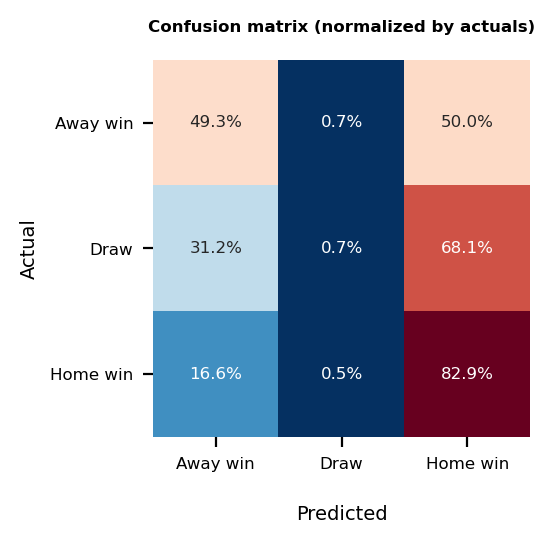

In [155]:
create_confusion(y_test, match_res_pred, target_names)

In [156]:
outcome_pred_results = pd.DataFrame(
    columns=["Model", "Precision", "Recall", "F1 score"]
)

In [157]:
outcome_pred_results = outcome_pred_results.append(
    {
        "Model": "Baseline LG",
        "Precision": precision_score(y_test, match_res_pred, average="macro"),
        "Recall": recall_score(y_test, match_res_pred, average="macro"),
        "F1 score": f1_score(y_test, match_res_pred, average="macro"),
    },
    ignore_index=True,
)

**Insights**

1. Precision and recall are a useful metrics for model evaluation when the classes are imbalanced:
    - Precision is a measure of the ability of a classification model to identify only the relevant data points, ie, answers the question: what portion of predicted Positives is truly Positive?
    - Recall is a measure of the ability of a model to find all the relevant cases within a dataset, ie, answers the question what portion of actual Positives is correctly classified?
    - F1-score combines precision and recall into one metric by calculating the harmonic mean between those two.
1. Logistic regression model with imbalanced and not transformed data, including team attributes and each player rating, mostly predicts (hits) the best represented classes:
    - "Away win" and "Home win" are predicted quite often, especially "Home win", and precision is moderate for these two classes.  
    - However "Draw" class is predicted very rarely (recall is 0.01), even though precision is almost 0.3. 
1. It seems that imbalanced training set have impact that match outcome is mostly classified as "Home win" but "Draw" class is barely hit.

#### Feature importance

In [158]:
lg_feat_importance = pd.DataFrame(
    data=lg_reg.coef_, columns=X_train.columns, index=lg_reg.classes_
)

lg_feat_importance

home_build_up_play_speed  home_build_up_play_passing  \
-1                 -0.000451                    0.003200   
 0                  0.004228                   -0.003489   
 1                 -0.003778                    0.000289   

    home_chance_creation_passing  home_chance_creation_crossing  \
-1                     -0.000451                       0.000109   
 0                      0.001045                      -0.000024   
 1                     -0.000594                      -0.000085   

    home_chance_creation_shooting  home_defence_pressure  \
-1                      -0.000062              -0.001733   
 0                      -0.000284              -0.001978   
 1                       0.000345               0.003711   

    home_defence_aggression  home_defence_team_width  \
-1                -0.000147                 0.000158   
 0                -0.001537                 0.000542   
 1                 0.001683                -0.000700   

    away_build_up_play_speed  away_build_up_play_passing  \
-1                 -0.000621                    0.000371   
 0                  0.000289                   -0.001262   
 1                  0.000332                    0.000891   

    away_chance_creation_passing  away_chance_creation_crossing  \
-1                     -0.000049                      -0.000136   
 0                     -0.000304                       0.000264   
 1                      0.000353                      -0.000129   

    away_chance_creation_shooting  away_defence_pressure  \
-1                      -0.002280               0.004898   
 0                       0.000139              -0.004171   
 1                       0.002141              -0.000727   

    away_defence_aggression  away_defence_team_width  home_player_1_rating  \
-1                 0.001127                -0.000920             -0.005628   
 0                 0.000638                 0.002038              0.002562   
 1                -0.001765                -0.001119              0.003066   

    home_player_2_rating  home_player_3_rating  home_player_4_rating  \
-1             -0.012583             -0.017883             -0.015864   
 0              0.004579              0.010008              0.003067   
 1              0.008004              0.007875              0.012797   

    home_player_5_rating  home_player_6_rating  home_player_7_rating  \
-1             -0.006505             -0.007369             -0.010232   
 0             -0.000564             -0.003479              0.005171   
 1              0.007069              0.010848              0.005061   

    home_player_8_rating  home_player_9_rating  home_player_10_rating  \
-1             -0.010648             -0.004206              -0.003028   
 0             -0.003839             -0.007464              -0.003732   
 1              0.014487              0.011670               0.006760   

    home_player_11_rating  away_player_1_rating  away_player_2_rating  \
-1              -0.008112              0.001675              0.008730   
 0              -0.007226              0.004786              0.001021   
 1               0.015337             -0.006461             -0.009751   

    away_player_3_rating  away_player_4_rating  away_player_5_rating  \
-1              0.007585              0.013081              0.009987   
 0              0.002541              0.001686              0.000406   
 1             -0.010126             -0.014768             -0.010392   

    away_player_6_rating  away_player_7_rating  away_player_8_rating  \
-1              0.006982              0.010480              0.006545   
 0             -0.003995             -0.000626              0.006790   
 1             -0.002987             -0.009854             -0.013335   

    away_player_9_rating  away_player_10_rating  away_player_11_rating  
-1              0.006284               0.015902               0.010656  
 0              0.000568              -0.004752              -0.007673  
 1 

Interpretation: positive coefficient corresponds to higher importance for the particular class and negative coefficient corresponds to lower importance.

In [159]:
lg_feat_importance.idxmax(axis=1)

-1    away_player_10_rating
 0     home_player_3_rating
 1    home_player_11_rating
dtype: object

Most important features for Away and Home wins are rating of players 10 and 11, which makes sense as these features represents attackers that aim to score as often as possible during the match.  
(source: https://protips.dickssportinggoods.com/sports-and-activities/soccer/soccer-positions-the-numbers-player-roles-basic-formations)

In [160]:
lg_feat_importance.idxmin(axis=1)

-1     home_player_3_rating
 0    away_player_11_rating
 1     away_player_4_rating
dtype: object

Features that affect Away and Home wins classification negatively are rating of players 3 and 4. These features represents defenders that have a purpose to protect goalie, block shots and stopp the other team’s.

#### LG with balancer

In [161]:
lg_reg_pipe = ImPipeline(
    [
        ("balancer", SMOTE(random_state=RANDOM)),
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(random_state=RANDOM, max_iter=10000)),
    ]
)

In [162]:
params = {
    "balancer__k_neighbors": [1, 2, 3, 4, 5, 6],
    "scaler": [MinMaxScaler(), RobustScaler(), MaxAbsScaler(), StandardScaler()],
    "classifier__C": [0.001, 0.01, 1.0, 10.0, 100.0, 200.0],
    "classifier__solver": ["newton-cg", "sag", "saga", "lbfgs"],
    "classifier__multi_class": ["ovr", "multinomial"],
}

lg_reg_search = RandomizedSearchCV(
    lg_reg_pipe, params, scoring="f1_macro", random_state=RANDOM
).fit(X_train, y_train)

print("Best parameters: {}".format(lg_reg_search.best_params_))

Best parameters: {'scaler': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__multi_class': 'multinomial', 'classifier__C': 200.0, 'balancer__k_neighbors': 3}


In [163]:
print(f"F1 macro score: {lg_reg_search.score(X_train, y_train):.2f}")

F1 macro score: 0.46


In [164]:
match_res_pred_lg = lg_reg_search.predict(X_test)

In [165]:
print(
    "\033[1m" + "Classification report for Logistic Regression:\n\n" + "\033[0m",
    classification_report(y_test, match_res_pred_lg, target_names=target_names),
)

Classification report for Logistic Regression:

               precision    recall  f1-score   support

    Away win       0.44      0.57      0.50       990
        Draw       0.27      0.22      0.24       861
    Home win       0.61      0.57      0.59      1573

    accuracy                           0.48      3424
   macro avg       0.44      0.45      0.44      3424
weighted avg       0.48      0.48      0.48      3424



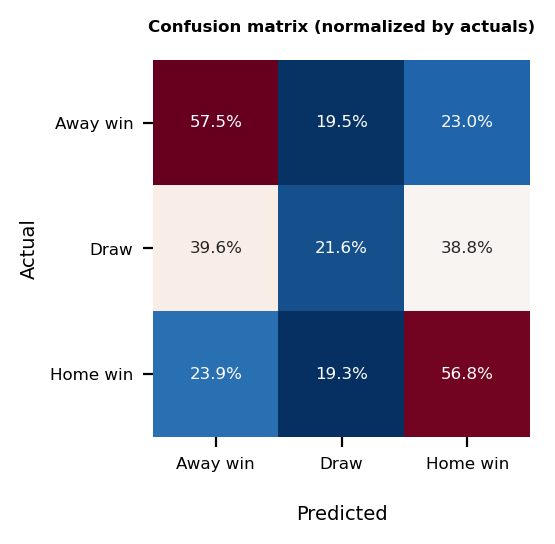

In [166]:
create_confusion(y_test, match_res_pred_lg, target_names)

In [167]:
outcome_pred_results = outcome_pred_results.append(
    {
        "Model": "LG with balancer",
        "Precision": precision_score(y_test, match_res_pred_lg, average="macro"),
        "Recall": recall_score(y_test, match_res_pred_lg, average="macro"),
        "F1 score": f1_score(y_test, match_res_pred_lg, average="macro"),
    },
    ignore_index=True,
)

**Insights**
1. Balancing and scaling data for logistic regression model helps to improve recall for "Draw" class.
1. However recall drops for "Home win" class.

#### Naive Bayes

In [168]:
naive_pipe = ImPipeline(
    [
        ("balancer", SMOTE(random_state=RANDOM)),
        ("scaler", MinMaxScaler()),
        ("classifier", GaussianNB()),
    ]
)

In [169]:
params = {
    "balancer__k_neighbors": [1, 2, 3, 4, 5, 6],
    "scaler": [MinMaxScaler(), RobustScaler(), MaxAbsScaler(), StandardScaler()],
}

naive_search = RandomizedSearchCV(
    naive_pipe, params, scoring="f1_macro", random_state=RANDOM
).fit(X_train, y_train)

print("Best parameters: {}".format(naive_search.best_params_))

Best parameters: {'scaler': StandardScaler(), 'balancer__k_neighbors': 2}


In [170]:
print(f"F1 macro score: {naive_search.score(X_train, y_train):.2f}")

F1 macro score: 0.45


In [171]:
match_res_pred_naive = naive_search.predict(X_test)

In [172]:
print(
    "\033[1m" + "Classification report for Naive Bayes:\n\n" + "\033[0m",
    classification_report(y_test, match_res_pred_naive, target_names=target_names),
)

Classification report for Naive Bayes:

               precision    recall  f1-score   support

    Away win       0.42      0.52      0.47       990
        Draw       0.27      0.34      0.30       861
    Home win       0.63      0.45      0.53      1573

    accuracy                           0.44      3424
   macro avg       0.44      0.44      0.43      3424
weighted avg       0.48      0.44      0.45      3424



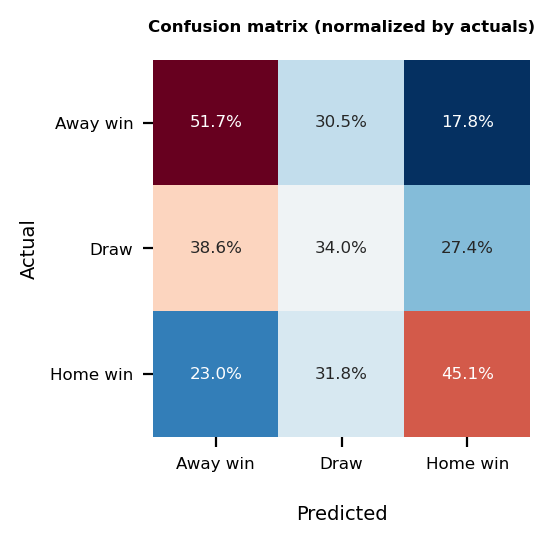

In [173]:
create_confusion(y_test, match_res_pred_naive, target_names)

In [174]:
outcome_pred_results = outcome_pred_results.append(
    {
        "Model": "Naive Bayes",
        "Precision": precision_score(y_test, match_res_pred_naive, average="macro"),
        "Recall": recall_score(y_test, match_res_pred_naive, average="macro"),
        "F1 score": f1_score(y_test, match_res_pred_naive, average="macro"),
    },
    ignore_index=True,
)

**Insight**

Naive Bayes with balanced and scaled data provides very similar results as logistic regression: f1_score = 43%.

#### KNN

In [175]:
knn_pipe = ImPipeline(
    [
        ("balancer", SMOTE(random_state=RANDOM)),
        ("scaler", MinMaxScaler()),
        ("classifier", KNeighborsClassifier()),
    ]
)

In [176]:
params = {
    "balancer__k_neighbors": [1, 2, 3, 4, 5, 6],
    "scaler": [MinMaxScaler(), RobustScaler(), MaxAbsScaler(), StandardScaler()],
    "classifier__n_neighbors": [1, 10, 20, 40, 100, 150, 200],
    "classifier__weights": ["uniform", "distance"],
    "classifier__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}

knn_search = RandomizedSearchCV(
    knn_pipe, params, scoring="f1_macro", random_state=RANDOM, n_jobs=-1
).fit(X_train, y_train)

print("Best parameters: {}".format(knn_search.best_params_))

Best parameters: {'scaler': MinMaxScaler(), 'classifier__weights': 'distance', 'classifier__n_neighbors': 100, 'classifier__algorithm': 'ball_tree', 'balancer__k_neighbors': 2}


In [177]:
print(f"F1 macro score: {knn_search.score(X_train, y_train):.2f}")

F1 macro score: 1.00


In [178]:
match_res_pred_knn = knn_search.predict(X_test)

In [179]:
print(
    "\033[1m" + "Classification report for KNN:\n\n" + "\033[0m",
    classification_report(
        y_test,
        match_res_pred_knn,
    ),
)

Classification report for KNN:

               precision    recall  f1-score   support

          -1       0.40      0.53      0.46       990
           0       0.28      0.45      0.34       861
           1       0.68      0.30      0.42      1573

    accuracy                           0.41      3424
   macro avg       0.45      0.43      0.41      3424
weighted avg       0.50      0.41      0.41      3424



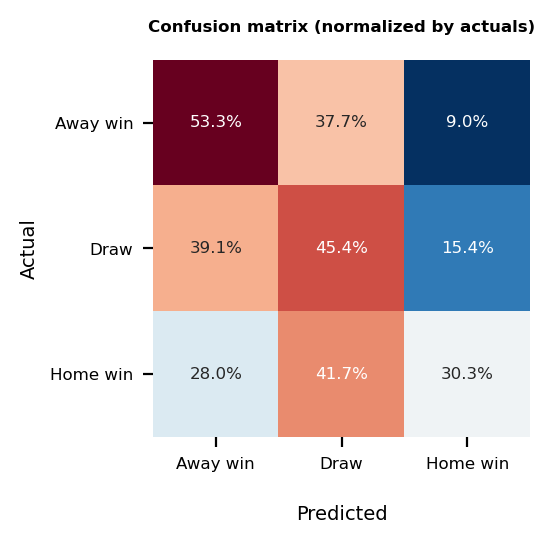

In [180]:
create_confusion(y_test, match_res_pred_knn, target_names)

In [181]:
outcome_pred_results = outcome_pred_results.append(
    {
        "Model": "KNN",
        "Precision": precision_score(y_test, match_res_pred_knn, average="macro"),
        "Recall": recall_score(y_test, match_res_pred_knn, average="macro"),
        "F1 score": f1_score(y_test, match_res_pred_knn, average="macro"),
    },
    ignore_index=True,
)

**Insights**

KNN with balanced and scaled data improves recall for 'Draw' class and recall for 'Home win' drops to 30%.

#### Model comparison

In [182]:
outcome_pred_results.set_index("Model").round(3)

Precision  Recall  F1 score
Model                                        
Baseline LG           0.437   0.443     0.386
LG with balancer      0.443   0.453     0.444
Naive Bayes           0.442   0.436     0.431
KNN                   0.454   0.430     0.407

### Match outcome (with match event data)

A lot of matches are missing in match event data and it represents only several leagues therefore this part of data is used cautiously. The purpose is to showchase how valuable match event statistics (on/off target shots, fouls, crosses, etc.) are for predicting the outcome and it may add a huge competitive advantage for a company entering European football marker (as per project business case).

In [183]:
away_cols = [col for col in spain_match if col.endswith("away_team")]
home_cols = [col for col in spain_match if col.endswith("home_team")]

In [184]:
match_player_stats = match_player_team.set_index("match_api_id").merge(
    match_attr.set_index("match_api_id")[home_cols + away_cols],
    how="inner",
    on="match_api_id",
)

In [185]:
match_stats = (
    match_player_stats.dropna()
    .reset_index()
    .drop(
        columns=[
            "country",
            "match_api_id",
            "date",
            "home_team_goal",
            "away_team_goal",
            "stage",
        ]
    )
)

In [186]:
match_stats["outcome"] = match_stats["outcome"].map({"draw": 0, "home": 1, "away": -1})

In [187]:
corr_df = pd.DataFrame(match_stats.corr().abs().unstack()).rename(
    columns={0: "corr_coef"}
)

corr_df[(corr_df["corr_coef"] > 0.7) & (corr_df["corr_coef"] != 1)].drop_duplicates()

corr_coef
off_target_shot_home_team crosses_home_team   0.779942
                          corner_home_team    0.759969
foul_home_team            foul_away_team      0.835546
                          crosses_away_team   0.706850
crosses_home_team         corner_home_team    0.808382
                          foul_away_team      0.712235
off_target_shot_away_team crosses_away_team   0.753301
                          corner_away_team    0.723420
crosses_away_team         corner_away_team    0.789415

- Multicollinearity increases the standard errors of their coefficients, and it may make those coefficients unstable in several ways. But so long as the collinear variables are only used as control variables, and they are not collinear with variables of interest, there’s no problem. (Source: https://statisticalhorizons.com/multicollinearity)
- Multicollinearity won't be addressed in this project as PCA and feature transformations are out of scope (and not for my level of knowledge).

In [188]:
y = match_stats["outcome"]
X = match_stats.drop(columns=["outcome"])

In [189]:
X.shape

(10689, 52)

In [190]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM
)

In [191]:
st_lg_reg_pipe = ImPipeline(
    [
        ("balancer", SMOTE(random_state=RANDOM)),
        ("scaler", MinMaxScaler()),
        (
            "classifier",
            LogisticRegression(
                random_state=RANDOM,
                max_iter=10000,
            ),
        ),
    ]
)

In [192]:
params = {
    "balancer__k_neighbors": [1, 2, 3, 4, 5, 6],
    "scaler": [MinMaxScaler(), RobustScaler(), MaxAbsScaler(), StandardScaler()],
    "classifier__C": [0.001, 0.01, 1.0, 10.0, 100.0, 200.0],
    "classifier__solver": ["newton-cg", "sag", "saga", "lbfgs"],
    "classifier__multi_class": ["ovr", "multinomial"],
}

st_lg_reg_search = RandomizedSearchCV(
    st_lg_reg_pipe, params, scoring="f1_macro", random_state=RANDOM
).fit(X_train, y_train)

print("Best parameters: {}".format(st_lg_reg_search.best_params_))

Best parameters: {'scaler': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__multi_class': 'multinomial', 'classifier__C': 1.0, 'balancer__k_neighbors': 5}


In [193]:
print(
    f"Accuracy score for training set: {st_lg_reg_search.score(X_train, y_train):.2f}"
)

Accuracy score for training set: 0.90


In [194]:
st_match_res_pred = st_lg_reg_search.predict(X_test)

In [195]:
print(
    "\033[1m" + "Classification report for logistic regression:\n\n" + "\033[0m",
    classification_report(y_test, st_match_res_pred, target_names=target_names),
)

Classification report for logistic regression:

               precision    recall  f1-score   support

    Away win       0.91      0.90      0.91       617
        Draw       0.85      0.87      0.86       578
    Home win       0.93      0.92      0.93       943

    accuracy                           0.90      2138
   macro avg       0.90      0.90      0.90      2138
weighted avg       0.90      0.90      0.90      2138



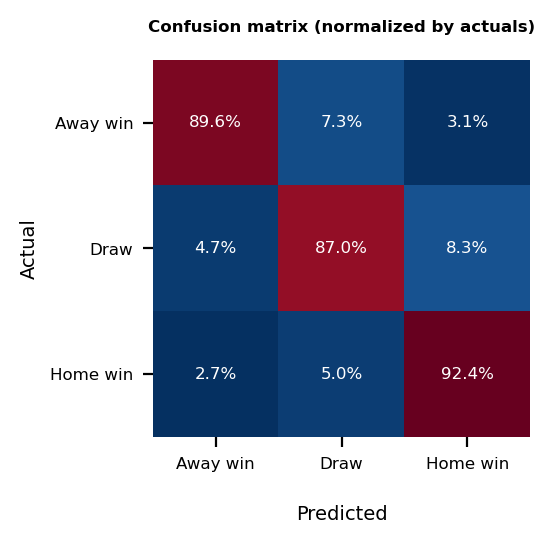

In [196]:
create_confusion(y_test, st_match_res_pred, target_names)

**Insights**

1. Logistic regression predicting match outcome with additional match event data (on/off target shots, fouls, crosses, etc.) provides really high scores for precision and recall. 
1. Seems that adding this kind of data is more helpful for outcome prediction than solely team attributes and player ratings.

### Goals

In [197]:
home = [col for col in match_player_team if col.startswith("home")]
away = [col for col in match_player_team if col.startswith("away")]

In [198]:
home_teams = match_player_team[home]
away_teams = match_player_team[away]

In [199]:
home_teams = home_teams.rename(columns={col: col[5:] for col in home_teams.columns})
away_teams = away_teams.rename(columns={col: col[5:] for col in away_teams.columns})

In [200]:
home_teams["is_home"] = 1
away_teams["is_home"] = 0

In [201]:
team_goal_n_attr = pd.concat([home_teams, away_teams])

team_goal_n_attr.head()

team_goal  build_up_play_speed  build_up_play_passing  \
3405          2                 30.0                   30.0   
3406          3                 70.0                   45.0   
3407          2                 64.0                   35.0   
3408          1                 67.0                   30.0   
3409          2                 65.0                   55.0   

      chance_creation_passing  chance_creation_crossing  \
3405                     55.0                      60.0   
3406                     45.0                      70.0   
3407                     30.0                      50.0   
3408                     50.0                      60.0   
3409                     55.0                      70.0   

      chance_creation_shooting  defence_pressure  defence_aggression  \
3405                      70.0              55.0                60.0   
3406                      65.0              40.0                50.0   
3407                      70.0              35.0                30.0   
3408                      60.0              45.0                30.0   
3409                      70.0              70.0                45.0   

      defence_team_width  player_1_rating  player_2_rating  player_3_rating  \
3405                60.0             72.0             77.0             82.0   
3406                40.0             74.0             76.0             78.0   
3407                55.0             78.0             75.0             76.0   
3408                60.0             86.0             74.0             76.0   
3409                70.0             84.0             81.0             76.0   

      player_4_rating  player_5_rating  player_6_rating  player_7_rating  \
3405             76.0             80.0             78.0             76.0   
3406             88.0             85.0             82.0             74.0   
3407             75.0             74.0             78.0             74.0   
3408             74.0             78.0             81.0             76.0   
3409             82.0             69.0             74.0             76.0   

      player_8_rating  player_9_rating  player_10_rating  player_11_rating  \
3405             81.0             86.0              75.0              87.0   
3406             84.0             81.0              83.0              89.0   
3407             78.0             77.0              77.0              85.0   
3408             81.0             78.0              78.0              84.0   
3409             81.0             72.0              74.0              79.0   

      is_home  
3405        1  
3406        1  
3407        1  
3408        1  
3409        1

In [202]:
team_goal_n_attr.shape

(34236, 21)

#### Linear regression

Predicting the number of goals each team will score during the match seems like regression problem therefore Linear regression model was applied first.

In [203]:
y = team_goal_n_attr["team_goal"]
X = team_goal_n_attr.drop(["team_goal"], axis=1)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM
)

In [205]:
lnr_reg = LinearRegression().fit(X_train, y_train)

In [206]:
goal_pred_lnr = lnr_reg.predict(X_test)

In [207]:
print(f"R-squared score for training set: {lnr_reg.score(X_train, y_train):.3f}")
print(f"R-squared score for test set: {lnr_reg.score(X_test, y_test):.3f}")
print(
    f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, goal_pred_lnr)):.3f}"
)

R-squared score for training set: 0.056
R-squared score for test set: 0.057
Root Mean Squared Error: 1.216


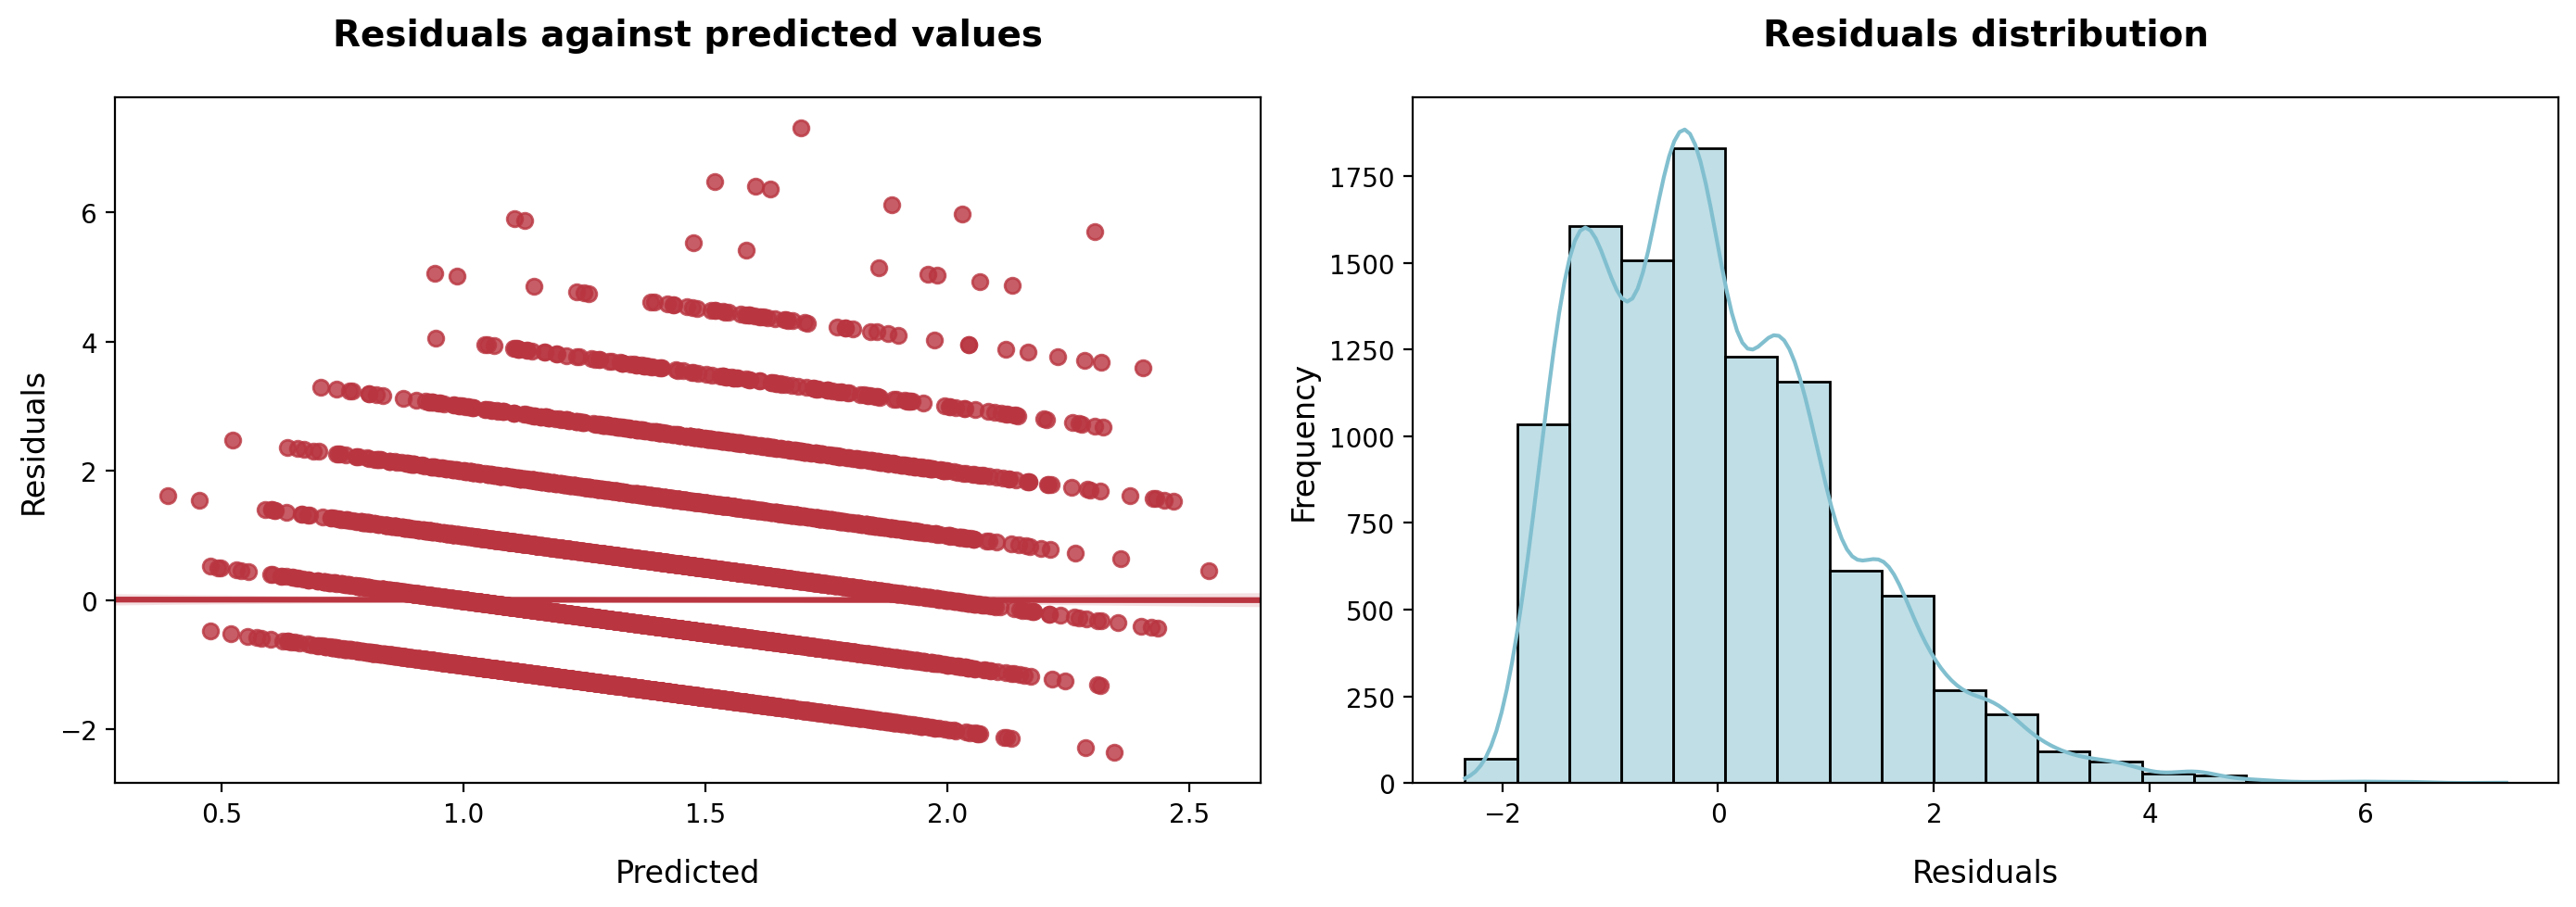

In [208]:
evaluate_lnr_model(y_test, goal_pred_lnr)

**Insights**

- Linear regression model provides really low R-squared score - less than 6% of the variation in number of goals could be explained by variables in the model.
- Expectation is that the residuals roughly form a "horizontal band" around the 0 line in the plot of residuals versus predicted values indicating constant error variance - this isn't the case for linear regression model above. Moreover, residuals plot show very right skewed distribution meaning that residuals do not 'behave' properly.
- The fact that football is one of the lowest scoring games, makes difficult to treat goal prediction as a regression problem because of the scarcity of data.
- As goals are discrete numbers and the range is small, I will try to apply classification algorithms

#### Baseline - Logistic regression (LG)

In [209]:
team_goal_n_attr["team_goal"].value_counts()

1     11344
0      9471
2      7654
3      3623
4      1457
5       468
6       164
7        36
8        13
9         4
10        2
Name: team_goal, dtype: int64

In [210]:
Q1 = team_goal_n_attr["team_goal"].quantile(0.25)
Q3 = team_goal_n_attr["team_goal"].quantile(0.75)
IQR = Q3 - Q1

lower_whisker = Q1 - (1.5 * IQR)
upper_whisker = Q3 + (1.5 * IQR)

In [211]:
lower_whisker

-3.0

In [212]:
upper_whisker

5.0

In [213]:
team_goal_below_5 = team_goal_n_attr[team_goal_n_attr["team_goal"] <= 5]

In [214]:
y = team_goal_below_5["team_goal"]
X = team_goal_below_5.drop(["team_goal"], axis=1)

In [215]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM
)

In [216]:
lg_goal_pipe = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(random_state=RANDOM, max_iter=10000)),
    ]
).fit(X_train, y_train)

In [217]:
match_goal_pred_lg = lg_goal_pipe.predict(X_test)

In [218]:
print(
    "\033[1m" + "Classification report for logistic regression:\n\n" + "\033[0m",
    classification_report(
        y_test,
        match_goal_pred_lg,
    ),
)

Classification report for logistic regression:

               precision    recall  f1-score   support

           0       0.37      0.24      0.29      2810
           1       0.34      0.79      0.47      3458
           2       0.25      0.03      0.05      2288
           3       0.00      0.00      0.00      1058
           4       0.00      0.00      0.00       451
           5       0.00      0.00      0.00       141

    accuracy                           0.34     10206
   macro avg       0.16      0.18      0.14     10206
weighted avg       0.27      0.34      0.25     10206



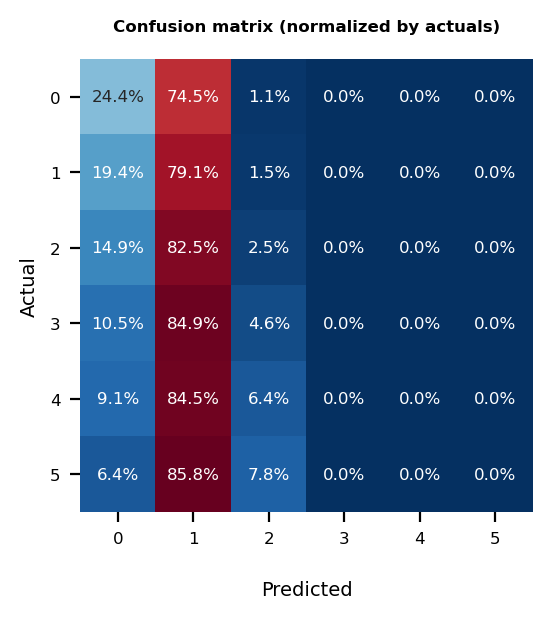

In [219]:
create_confusion(y_test, match_goal_pred_lg, [0, 1, 2, 3, 4, 5], figsize=(3, 3))

In [220]:
goal_pred_results = pd.DataFrame(columns=["Model", "Precision", "Recall", "F1 score"])

In [221]:
goal_pred_results = goal_pred_results.append(
    {
        "Model": "Baseline LG",
        "Precision": precision_score(y_test, match_goal_pred_lg, average="macro"),
        "Recall": recall_score(y_test, match_goal_pred_lg, average="macro"),
        "F1 score": f1_score(y_test, match_goal_pred_lg, average="macro"),
    },
    ignore_index=True,
)

**Insights**
1. Logistic regression model with imbalanced data, including team attributes and each player rating, mostly predicts (hits) the best represented classes:
    - Classes 0, 1 and 2 are predicted quite often, especially 1, and precision is moderate for these two classes.  
    - However classes 3, 4, 5 are not predicted at all.
1. It seems that imbalanced training set have an impact on not predicting classes with low representation.

#### LG with balancer

In [222]:
lg_reg_goal_pipe = ImPipeline(
    [
        ("balancer", BorderlineSMOTE(random_state=RANDOM)),
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(random_state=RANDOM, max_iter=10000)),
    ]
)

In [223]:
params = {
    "balancer__k_neighbors": [1, 2, 3, 4, 5, 6],
    "scaler": [MinMaxScaler(), RobustScaler(), MaxAbsScaler(), StandardScaler()],
    "classifier__C": [0.001, 0.01, 1.0, 10.0, 100.0, 200.0],
    "classifier__solver": ["newton-cg", "sag", "saga", "lbfgs"],
    "classifier__multi_class": ["ovr", "multinomial"],
}

lg_reg_goal_search = RandomizedSearchCV(
    lg_reg_goal_pipe, params, scoring="f1_macro", random_state=RANDOM
).fit(X_train, y_train)

print("Best parameters: {}".format(lg_reg_goal_search.best_params_))

Best parameters: {'scaler': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__multi_class': 'multinomial', 'classifier__C': 200.0, 'balancer__k_neighbors': 3}


In [224]:
print(
    f"Macro F1 score for traning set: {lg_reg_goal_search.score(X_train, y_train):.2f}"
)

Macro F1 score for traning set: 0.17


In [225]:
match_goal_balanced_lg = lg_reg_goal_search.predict(X_test)

In [226]:
print(
    "\033[1m" + "Classification report for logistic regression:\n\n" + "\033[0m",
    classification_report(
        y_test,
        match_goal_balanced_lg,
    ),
)

Classification report for logistic regression:

               precision    recall  f1-score   support

           0       0.36      0.39      0.37      2810
           1       0.35      0.25      0.29      3458
           2       0.26      0.07      0.11      2288
           3       0.10      0.07      0.08      1058
           4       0.05      0.17      0.07       451
           5       0.02      0.28      0.05       141

    accuracy                           0.23     10206
   macro avg       0.19      0.21      0.16     10206
weighted avg       0.29      0.23      0.24     10206



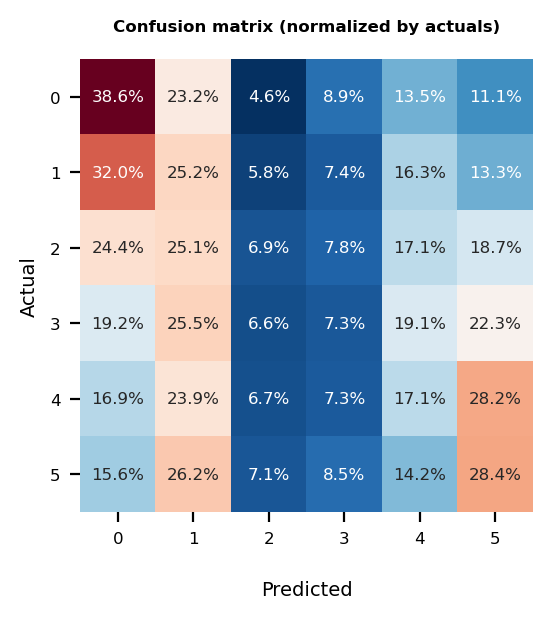

In [227]:
create_confusion(y_test, match_goal_balanced_lg, [0, 1, 2, 3, 4, 5], figsize=(3, 3))

In [228]:
goal_pred_results = goal_pred_results.append(
    {
        "Model": "LG with balancer",
        "Precision": precision_score(y_test, match_goal_balanced_lg, average="macro"),
        "Recall": recall_score(y_test, match_goal_balanced_lg, average="macro"),
        "F1 score": f1_score(y_test, match_goal_balanced_lg, average="macro"),
    },
    ignore_index=True,
)

**Insights**

1. Balancing data for logistic regression really improves predictions for classes 3, 4 and 5 and increases overall precision and recall.
1. However model results are not very high - I have tried other (basic) classification algorithms with different balancing techniques but couldn't get better results. One of the examples below.

#### Support Vector Classification (SVC)

In [229]:
classes = np.unique(y)
weights = class_weight.compute_class_weight("balanced", classes=classes, y=y)

In [230]:
weights = class_weight.compute_class_weight(
    "balanced", np.unique(y_train), np.array(y_train)
)

In [231]:
class_weights = {k: v for k, v in zip(np.unique(y_train), weights)}
class_weights

{0: 0.5957814142020718,
 1: 0.5032335784935329,
 2: 0.7395639209839732,
 3: 1.5471734892787525,
 4: 3.944831013916501,
 5: 12.136085626911315}

In [232]:
svc_pipe = ImPipeline(
    [
        ("scaler", MinMaxScaler()),
        (
            "classifier",
            LinearSVC(random_state=RANDOM, class_weight=class_weights, max_iter=10000),
        ),
    ]
).fit(X_train, y_train)

svc_pipe.score(X_train, y_train)

0.25563815043467303

In [233]:
match_res_pred_svc = svc_pipe.predict(X_test)

In [234]:
print(
    "\033[1m"
    + "Classification report for multiclass logistic regression:\n\n"
    + "\033[0m",
    classification_report(
        y_test,
        match_res_pred_svc,
    ),
)

Classification report for multiclass logistic regression:

               precision    recall  f1-score   support

           0       0.35      0.50      0.41      2810
           1       0.34      0.25      0.29      3458
           2       0.22      0.07      0.11      2288
           3       0.15      0.03      0.05      1058
           4       0.05      0.04      0.04       451
           5       0.02      0.34      0.04       141

    accuracy                           0.25     10206
   macro avg       0.19      0.21      0.16     10206
weighted avg       0.28      0.25      0.24     10206



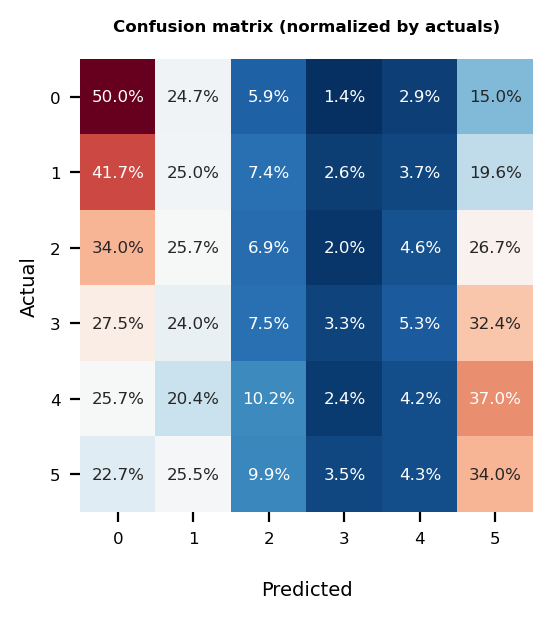

In [235]:
create_confusion(y_test, match_res_pred_svc, [0, 1, 2, 3, 4, 5], figsize=(3, 3))

In [236]:
goal_pred_results = goal_pred_results.append(
    {
        "Model": "SVC",
        "Precision": precision_score(y_test, match_res_pred_svc, average="macro"),
        "Recall": recall_score(y_test, match_res_pred_svc, average="macro"),
        "F1 score": f1_score(y_test, match_res_pred_svc, average="macro"),
    },
    ignore_index=True,
)

**Insights**

1. In general, SVC model with class weights provides similar results as logistic regression with balancer. Looking separately at precision and recall for each class:
    - Classes 0 and 5 get more hits but lower number of predictions are made for classes 3 and 4.
    - Precision remains almost the same for all classes.

#### Model comparison

In [237]:
goal_pred_results.set_index("Model").round(3)

Precision  Recall  F1 score
Model                                        
Baseline LG           0.160   0.177     0.135
LG with balancer      0.189   0.206     0.162
SVC                   0.188   0.206     0.157

### Goals (with match event data)

In [238]:
match_event_stats = (
    match_player_stats.dropna()
    .reset_index()
    .drop(columns=["country", "match_api_id", "date", "stage", "outcome"])
)

In [239]:
col_list = pd.Series(match_event_stats.columns)
hm_cols = col_list[col_list.str.contains("home")]
aw_cols = col_list[col_list.str.contains("away")]

In [240]:
hm_teams = match_event_stats[hm_cols].copy()
aw_teams = match_event_stats[aw_cols].copy()

In [241]:
hm_teams.columns = pd.Series(hm_teams.columns).str.replace("home_", "")
aw_teams.columns = pd.Series(aw_teams.columns).str.replace("away_", "")

In [242]:
hm_teams["is_home"] = 1
aw_teams["is_home"] = 0

In [243]:
team_goal_n_stats = pd.concat([hm_teams, aw_teams])

team_goal_n_stats.head()

team_goal  build_up_play_speed  build_up_play_passing  \
0          2                 30.0                   30.0   
1          3                 70.0                   45.0   
2          2                 64.0                   35.0   
3          1                 67.0                   30.0   
4          2                 65.0                   55.0   

   chance_creation_passing  chance_creation_crossing  \
0                     55.0                      60.0   
1                     45.0                      70.0   
2                     30.0                      50.0   
3                     50.0                      60.0   
4                     55.0                      70.0   

   chance_creation_shooting  defence_pressure  defence_aggression  \
0                      70.0              55.0                60.0   
1                      65.0              40.0                50.0   
2                      70.0              35.0                30.0   
3                      60.0              45.0                30.0   
4                      70.0              70.0                45.0   

   defence_team_width  player_1_rating  player_2_rating  player_3_rating  \
0                60.0             72.0             77.0             82.0   
1                40.0             74.0             76.0             78.0   
2                55.0             78.0             75.0             76.0   
3                60.0             86.0             74.0             76.0   
4                70.0             84.0             81.0             76.0   

   player_4_rating  player_5_rating  player_6_rating  player_7_rating  \
0             76.0             80.0             78.0             76.0   
1             88.0             85.0             82.0             74.0   
2             75.0             74.0             78.0             74.0   
3             74.0             78.0             81.0             76.0   
4             82.0             69.0             74.0             76.0   

   player_8_rating  player_9_rating  player_10_rating  player_11_rating  \
0             81.0             86.0              75.0              87.0   
1             84.0             81.0              83.0              89.0   
2             78.0             77.0              77.0              85.0   
3             81.0             78.0              78.0              84.0   
4             81.0             72.0              74.0              79.0   

   on_target_shot_team  off_target_shot_team  foul_team  yellow_card_team  \
0                  2.0                   3.0       19.0               3.0   
1                  3.0                   3.0       13.0               0.0   
2                  2.0                  13.0       13.0               2.0   
3                  1.0                   6.0       14.0               1.0   
4                  2.0                   2.0       17.0               2.0   

   red_card_team  crosses_team  corner_team  is_home  
0            0.0          18.0          3.0        1  
1            0.0          26.0          6.0        1  
2            0.0          39.0         13.0        1  
3            0.0          31.0          8.0        1  
4            0.0          12.0         10.0        1

In [244]:
corr_stats = pd.DataFrame(team_goal_n_stats.corr().abs().unstack()).rename(
    columns={0: "corr_coef"}
)

corr_stats[
    (corr_stats["corr_coef"] > 0.7) & (corr_stats["corr_coef"] != 1)
].drop_duplicates()

corr_coef
team_goal            on_target_shot_team   0.959503
off_target_shot_team crosses_team          0.772119
                     corner_team           0.748442
crosses_team         corner_team           0.803634

In [245]:
team_goal_n_stats = team_goal_n_stats.drop(columns="on_target_shot_team")

In [246]:
team_goal_n_stats.shape

(21378, 27)

In [247]:
team_goal_n_stats = team_goal_n_stats[team_goal_n_stats["team_goal"] <= 5]

In [248]:
team_goal_n_stats.columns = pd.Series(team_goal_n_stats.columns).str.replace(
    "_team", ""
)

In [249]:
y_goal = team_goal_n_stats["team_goal"]
X_goal = team_goal_n_stats.drop(["team_goal"], axis=1)

In [250]:
X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(
    X_goal, y_goal, random_state=RANDOM
)

#### LG with balancer

In [251]:
lg_goal_pipe = ImPipeline(
    [
        ("balancer", BorderlineSMOTE(random_state=RANDOM)),
        ("scaler", MinMaxScaler()),
        ("classifier", LogisticRegression(random_state=RANDOM, max_iter=10000)),
    ]
)

In [252]:
params = {
    "balancer__k_neighbors": [1, 2, 3, 4, 5, 6],
    "scaler": [MinMaxScaler(), RobustScaler(), MaxAbsScaler(), StandardScaler()],
    "classifier__C": [0.001, 0.01, 1.0, 10.0, 100.0, 200.0],
    "classifier__solver": ["newton-cg", "sag", "saga", "lbfgs"],
    "classifier__multi_class": ["ovr", "multinomial"],
}

lg_goal_search = RandomizedSearchCV(
    lg_goal_pipe, params, scoring="f1_macro", random_state=RANDOM
).fit(X_g_train, y_g_train)

print("Best parameters: {}".format(lg_reg_goal_search.best_params_))

Best parameters: {'scaler': StandardScaler(), 'classifier__solver': 'lbfgs', 'classifier__multi_class': 'multinomial', 'classifier__C': 200.0, 'balancer__k_neighbors': 3}


In [253]:
print(
    f"F1 macro score for traning set: {lg_goal_search.score(X_g_train, y_g_train):.2f}"
)

F1 macro score for traning set: 0.21


In [254]:
match_goal_lg = lg_goal_search.predict(X_g_test)

In [255]:
print(
    "\033[1m" + "Classification report for logistic regression:\n\n" + "\033[0m",
    classification_report(
        y_g_test,
        match_goal_lg,
    ),
)

Classification report for logistic regression:

               precision    recall  f1-score   support

           0       0.39      0.44      0.42      1529
           1       0.37      0.24      0.29      1764
           2       0.25      0.14      0.18      1194
           3       0.13      0.14      0.13       547
           4       0.07      0.24      0.11       213
           5       0.04      0.29      0.07        66

    accuracy                           0.27      5313
   macro avg       0.21      0.25      0.20      5313
weighted avg       0.31      0.27      0.28      5313



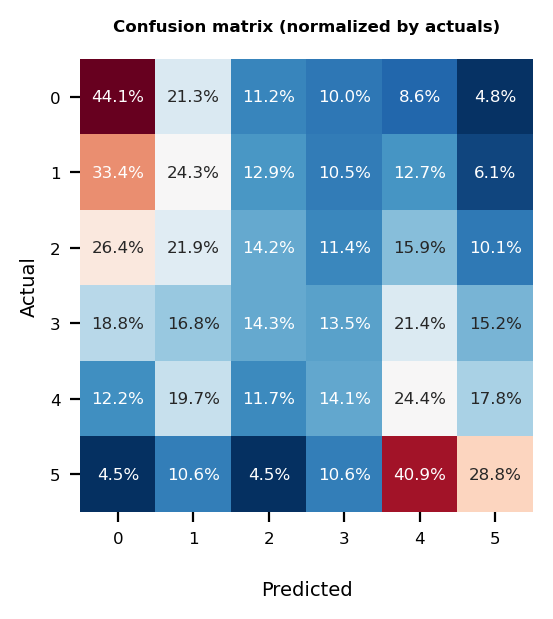

In [256]:
create_confusion(y_g_test, match_goal_lg, [0, 1, 2, 3, 4, 5], figsize=(3, 3))

**Insights**

1. Logistic regression fitted on team attributes, player attributes and additional match event data (on/off target shots, fouls, crosses, etc.) provides quite low results of precision (21%) and recall (25%) for predicting number of goals per match.
1. It seems that goal classification is a tricky problem for model to solve even having match event data that was very valuable predicting match outcome.

#### LG with PCA

In [257]:
pca_pipe = Pipeline([("scaler", MinMaxScaler()), ("pca", PCA())])

In [258]:
X_train_pca = pca_pipe.fit_transform(X_g_train)

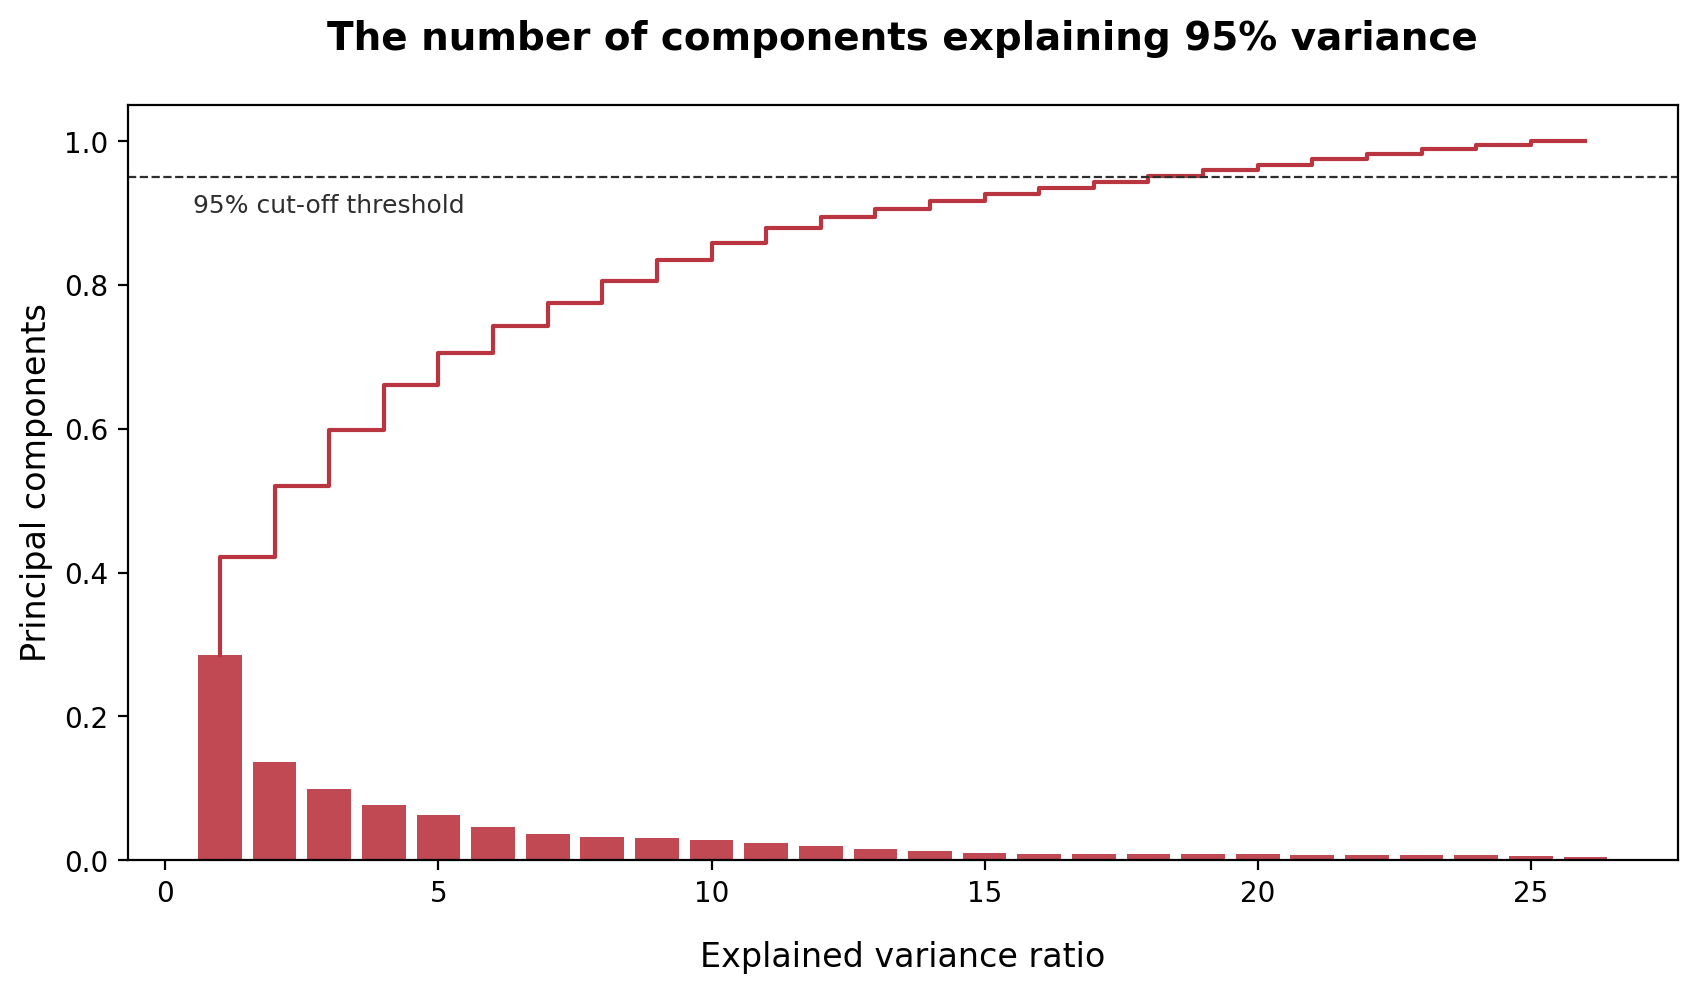

In [259]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.bar(
    range(1, 27),
    pca_pipe[1].explained_variance_ratio_,
    alpha=0.9,
    color='#b93540'
)
plt.step(
    range(1, 27),
    np.cumsum(pca_pipe[1].explained_variance_ratio_),
    color='#b93540'
)

plt.axhline(y=0.95, color="#2e2e2e", linestyle="--", linewidth=0.8)
plt.text(0.5, 0.90, "95% cut-off threshold", color="#2e2e2e", fontsize=9)

set_labels(
    ax,
    "The number of components explaining 95% variance",
    "Explained variance ratio",
    "Principal components",
)

plt.show()

In [260]:
lg_pca_goal_pipe = ImPipeline(
    [
        ("balancer", SMOTE(random_state=RANDOM)),
        ("scaler", MinMaxScaler()),
        ("pca", PCA(0.95)),
        ("classifier", LogisticRegression(random_state=RANDOM, max_iter=10000)),
    ]
)

In [261]:
params = {
    "balancer__k_neighbors": [1, 2, 3, 4, 5, 6],
    "classifier__C": [
        0.001,
        0.01,
        1.0,
        10.0,
        100.0,
    ],
    "classifier__solver": ["newton-cg", "sag", "saga", "lbfgs"],
    "classifier__multi_class": ["ovr", "multinomial"],
}

lg_pca_goal_search = RandomizedSearchCV(
    lg_pca_goal_pipe, params, scoring="f1_macro", random_state=RANDOM
).fit(X_g_train, y_g_train)

print("Best parameters: {}".format(lg_pca_goal_search.best_params_))

Best parameters: {'classifier__solver': 'saga', 'classifier__multi_class': 'multinomial', 'classifier__C': 100.0, 'balancer__k_neighbors': 4}


In [262]:
lg_pca_goal_search.best_estimator_[2].n_components_

18

In [263]:
n_pcs = lg_pca_goal_search.best_estimator_[2].components_.shape[0]

most_important = [
    np.abs(lg_pca_goal_search.best_estimator_[2].components_[i]).argmax()
    for i in range(n_pcs)
]
initial_feature_names = X_g_train.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {"PC_{}".format(i): most_important_names[i] for i in range(n_pcs)}
PCs = (
    pd.DataFrame(dic.items())
    .rename(columns={0: "component", 1: "most_important_feature"})
    .set_index("component")
)

PCs

most_important_feature
component                          
PC_0                        is_home
PC_1               player_10_rating
PC_2                           foul
PC_3        chance_creation_passing
PC_4               defence_pressure
PC_5             defence_aggression
PC_6       chance_creation_shooting
PC_7            build_up_play_speed
PC_8        chance_creation_passing
PC_9       chance_creation_crossing
PC_10                   yellow_card
PC_11         build_up_play_passing
PC_12                          foul
PC_13               player_2_rating
PC_14               player_1_rating
PC_15              player_10_rating
PC_16               player_3_rating
PC_17               player_8_rating

In [264]:
print(
    f"Macro F1 score for traning set: {lg_pca_goal_search.score(X_g_train, y_g_train):.2f}"
)

Macro F1 score for traning set: 0.19


In [265]:
match_goal_lg_pca = lg_pca_goal_search.predict(X_g_test)

In [266]:
print(
    "\033[1m" + "Classification report for logistic regression:\n\n" + "\033[0m",
    classification_report(
        y_g_test,
        match_goal_lg_pca,
    ),
)

Classification report for logistic regression:

               precision    recall  f1-score   support

           0       0.38      0.42      0.40      1529
           1       0.38      0.25      0.30      1764
           2       0.25      0.12      0.16      1194
           3       0.12      0.08      0.10       547
           4       0.07      0.27      0.11       213
           5       0.04      0.47      0.08        66

    accuracy                           0.26      5313
   macro avg       0.21      0.27      0.19      5313
weighted avg       0.31      0.26      0.27      5313



**Insights**

1. PCA doesn't help to improve logistic regression results for predicting number of goals per match.
1. But it provides a good understanding of feature importance for each principal component.

## Summary

The project was dedicated to EDA, statistical inference and machine learning for dataset containing a range of match, team and player statistics for the major European Football Leagues. Analysis and modelling were done with the business case in mind: finding competitive advantages for betting company entering European soccer market.

1. Data structure of 'match' table provides some useful information for analysis and predictions: 
    - data about events during the match is available not for all leagues and some leagues have only several records. It seems that detail match data is gathered only for the major European football leagues.
1. League-level EDA showed that different leagues excel at different statistics (parameters) - the ‘strength’ of each league is not a straight forward evaluation:
    - My proposal is to have several iterations of entering the European football market starting with the leagues that have the highest number of goals, highest number of teams, highest number of matches per season and the most data available - the richest ones:
        - Spain LIGA BBVA
        - England Premier League 
        - Italy Serie A
        - France Ligue 1
        - Germany 1. Bundesliga, 
    
1. Spain LIGA BBVA and England Premier League comparison:
    - Hypothesis testing showed that there is not enough evidence to say that Spain LIGA BBVA and England Premier League are different comapring the mean of number of goals per match. However there is statistically significant distinction in mean of goal difference per match between Spain LIGA BBVA and England Premier League, indicating differences in team features, skills or strategies.
    - Hypothesis testing for difference in mean of team attributes proved that there are 4 team attributes that have statistically significant difference between Spain LIGA BBVA and England Premier League. In general, seems that these two leagues apply quite a unique approach and strategy to the game:
        - England Premier League favours more of a dynamic style of play based on speed and passes.
        - Spain LIGA BBVA focus on the ability to shield the ball. Defending tends to involve pressing the opponent high up the pitch and forcing mistakes in possession. 

1. Match stats comparison for favorites and underdogs in Spain LIGA BBVA and England Premier League:
    - Stat. significant difference in mean of almost all match statistics shows that favorites apply recognizably distinctive style and strategy of the game than underdogs and this offers possibilities for betting on the event in the match (like betting on corner goals, on or off target shots, etc.), aka. in-play betting.

4. Match outcome prediction:
    - Using team attributes and player ratings data almost all models provide the same results. F1 score between 41 and 43%.
    - Adding match event stats to team attributes and player ratings data provides very good results, F1 score is 90%. However match event data is available not for all leagues. So it would be useful for betting company to put effort in getting match event data as it add more value in predicting match outcome.

5. Goals prediction:
    - Even though goals prediction feels like regression problem, the small range of goals in football match makes it difficult for regression algorithm to handle this problem. 
    - However basic classification algorithms do not provide much better results for predicting goals - macro F1 score between 16 and 21%. Fitting model on data with match event stats improves goal prediction just a bit. 

## Annex

#### Match stats between favorites and underdogs **playing away** in Spain LIGA BBVA - hypothesis testing and confidence intervals

Considering 2008-2016 (8 seasons) soccer data for Spain LIGA BBVA, does favorites in Spain LIGA BBVA have significantly different mean of match attributes (statistics) playing away than underdogs in Spain LIGA BBVA?

**Population**: match attributes (statistics) playing away in Spain LIGA BBVA  
**Parameter of Interest**: difference in means ($\mu_1 - \mu_2$)  
**Null Hypothesis:** there is no difference in mean of the same match statistic between favorites and underdogs in Spain LIGA BBVA ($\mu_1 = \mu_2$)  
**Alternative Hypthosis:** there is a statistically significant difference in mean of the same match statistic between favorites and underdogs in Spain LIGA BBVA ($\mu_1 \neq \mu_2$)

**Significance level (alfa):** 0.05

In [267]:
spain_favs_aw_match = spain_match[
    spain_match["away_team_name"].isin(spain_favs["team"].to_list())
].copy()

spain_favs_aw_match.shape[0]

456

In [268]:
spain_unfavs_aw_match = spain_match[
    ~spain_match["away_team_name"].isin(spain_favs["team"].to_list())
].copy()

spain_unfavs_aw_match = spain_unfavs_aw_match.dropna()

spain_unfavs_aw_match.shape[0]

2583

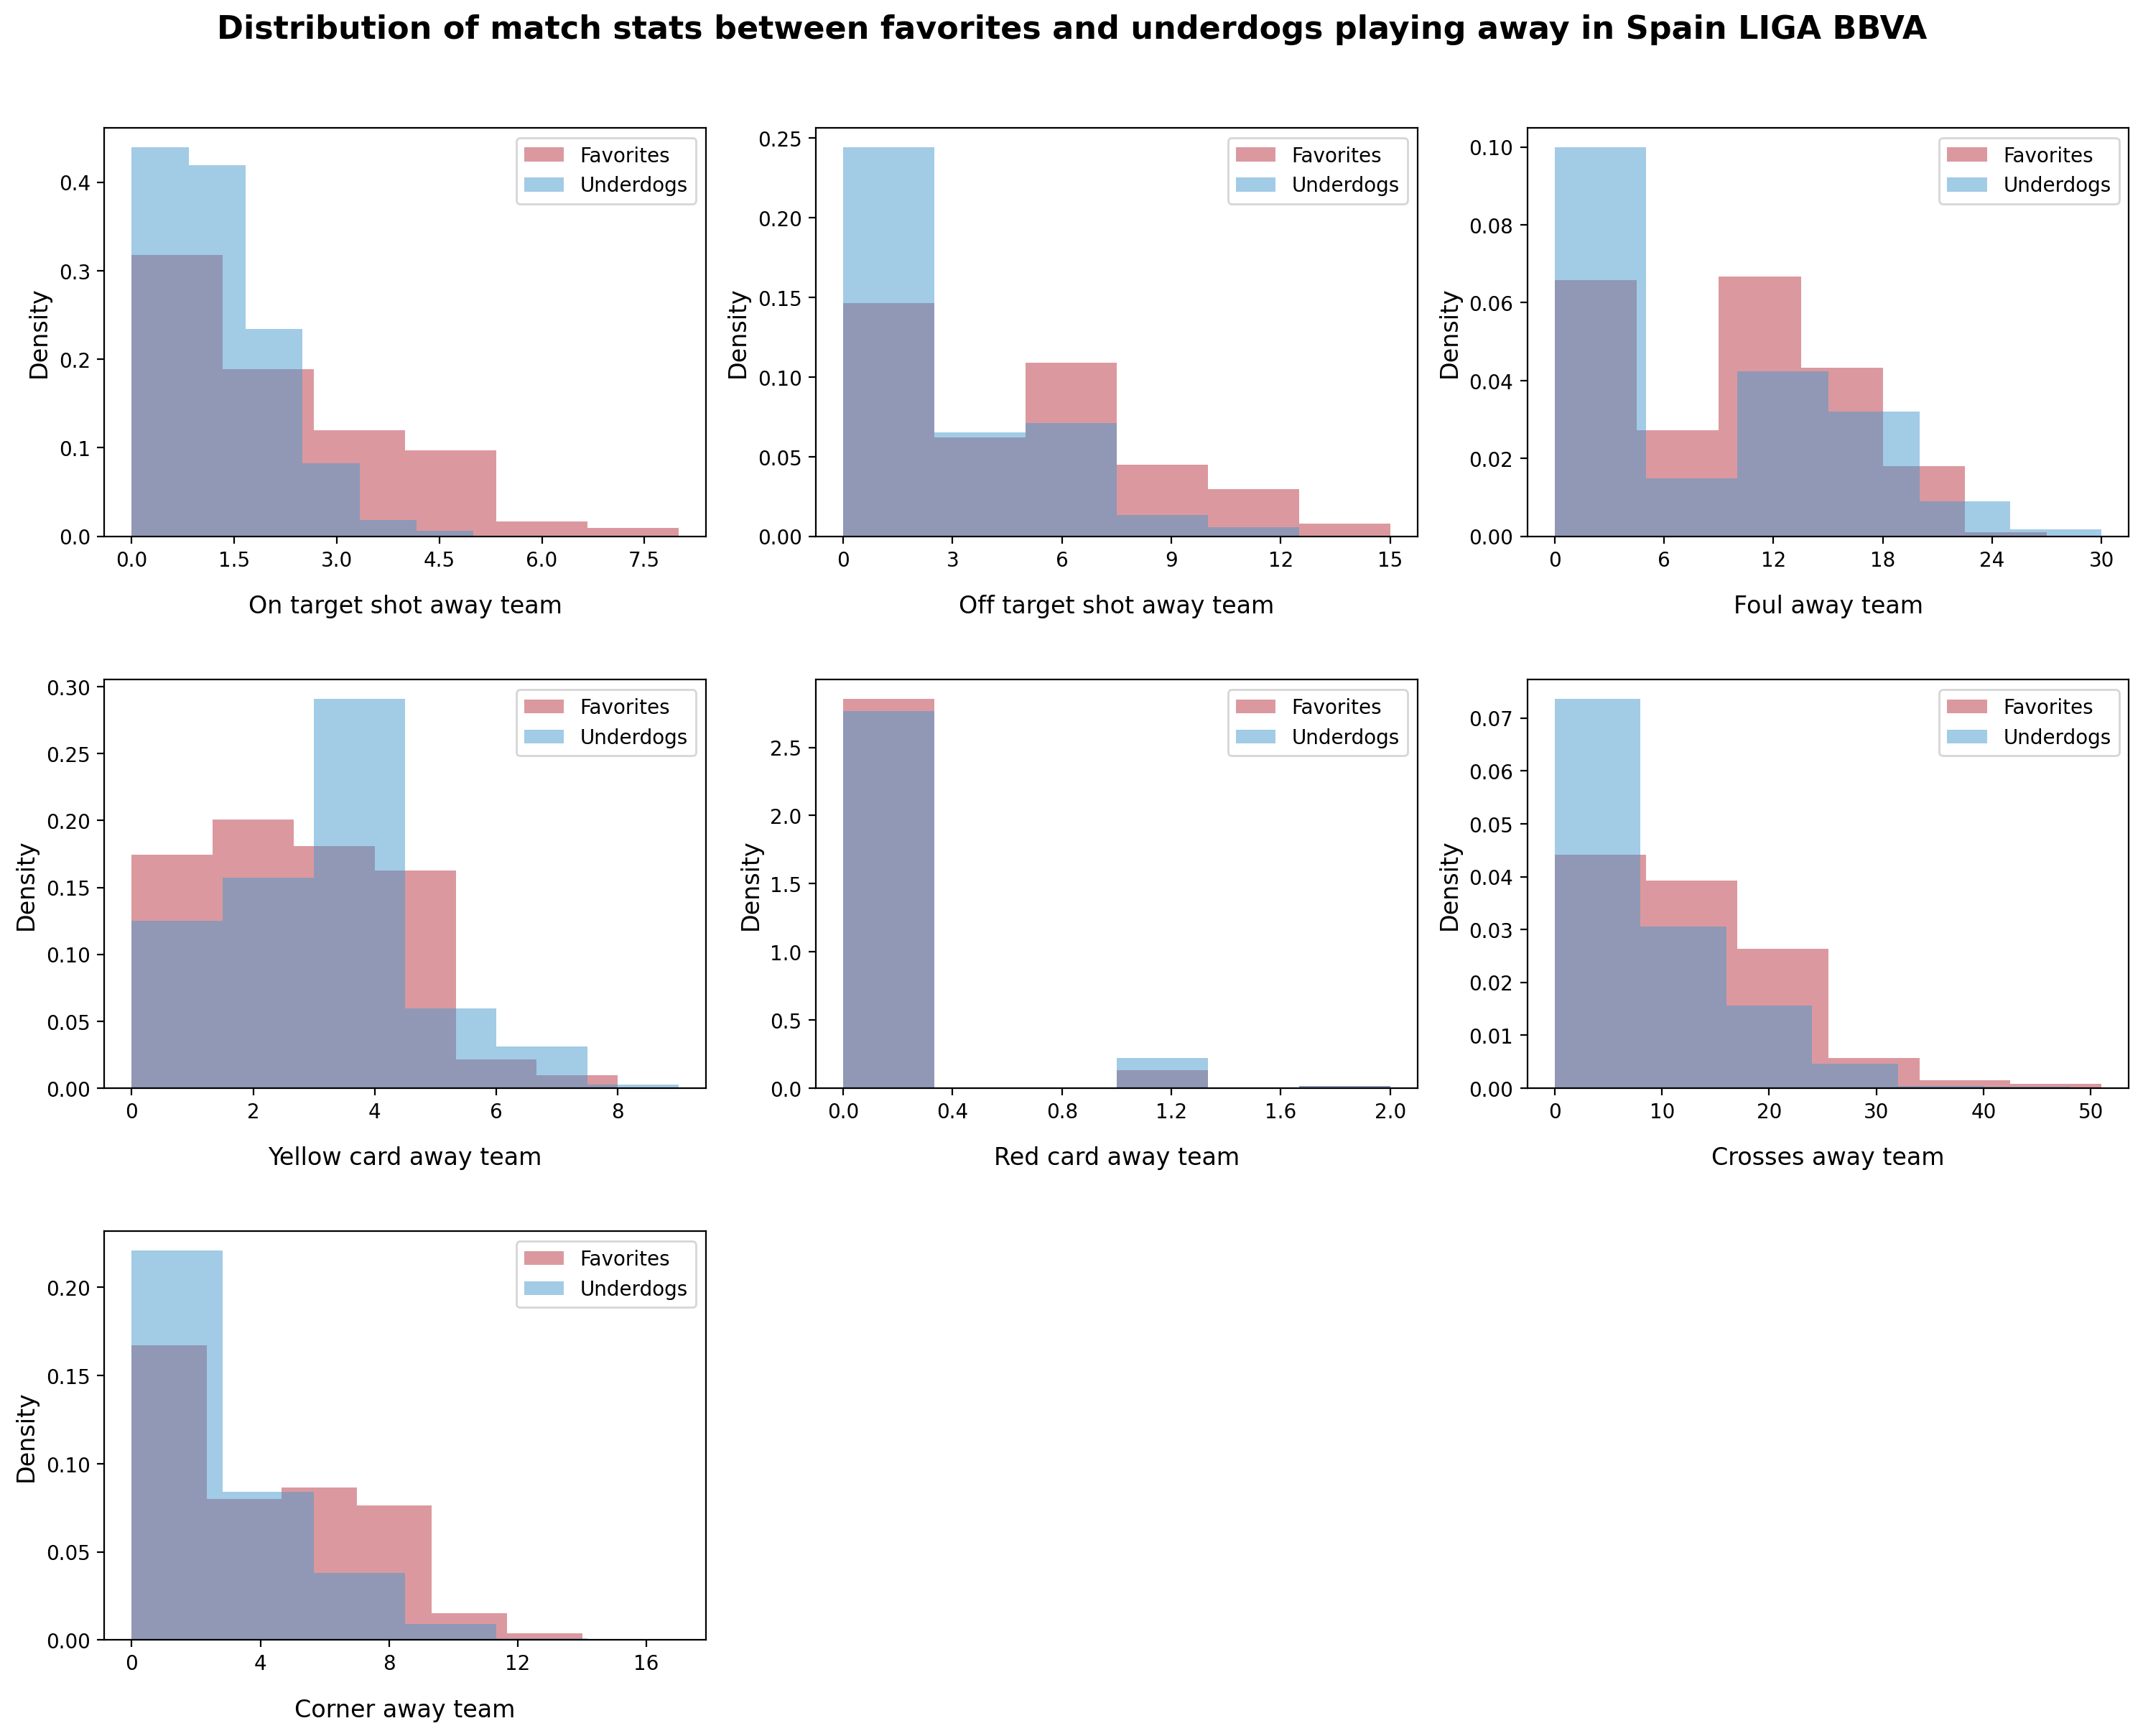

In [269]:
display_hists(
    spain_favs_aw_match,
    spain_unfavs_aw_match,
    away_cols,
    "Distribution of match stats between favorites and underdogs playing away in Spain LIGA BBVA",
    "Favorites",
    "Underdogs",
)

In [270]:
favs_unfavs_away_diff = compare_means_z(
    spain_favs_aw_match, spain_unfavs_aw_match, away_cols
).round(3)

In [271]:
favs_unfavs_away_diff["significance"] = favs_unfavs_away_diff["p-value"].apply(
    evaluate_pvalue
)

In [272]:
favs_unfavs_away_diff

p-value  z-statistic  CI lower  CI upper  \
feature                                                               
on_target_shot_away_team     0.000       12.965     0.848     1.151   
off_target_shot_away_team    0.000       11.612     1.738     2.446   
foul_away_team               0.000        5.275     1.131     2.473   
yellow_card_away_team        0.001       -3.277    -0.405    -0.102   
red_card_away_team           0.019       -2.345    -0.055    -0.005   
crosses_away_team            0.000        9.944     3.871     5.776   
corner_away_team             0.000       10.304     1.352     1.988   

                                           significance  
feature                                                  
on_target_shot_away_team   Stat. significant difference  
off_target_shot_away_team  Stat. significant difference  
foul_away_team             Stat. significant difference  
yellow_card_away_team      Stat. significant difference  
red_card_away_team         Stat. significant difference  
crosses_away_team          Stat. significant difference  
corner_away_team           Stat. significant difference

#### Match stats between favorites and underdogs **playing away** in England Premier League - hypothesis testing and confidence intervals

Considering 2008-2016 (8 seasons) soccer data for England Premier League, does favorites in England Premier League have significantly different mean of match attributes (statistics) playing away than underdogs in England Premier League?

**Population**: match attributes (statistics) playing away in  England Premier League  
**Parameter of Interest**: difference in means ($\mu_1 - \mu_2$)  
**Null Hypothesis:** there is no difference in mean of the same match statistic between favorites and underdogs in  England Premier League ($\mu_1 = \mu_2$)  
**Alternative Hypthosis:** there is a statistically significant difference in mean of the same match statistic between favorites and underdogs in  England Premier League ($\mu_1 \neq \mu_2$)

**Significance level (alfa):** 0.05

In [273]:
england_favs_aw_match = england_match[
    england_match["away_team_name"].isin(england_favs["team"].to_list())
].copy()

england_favs_aw_match.shape[0]

608

In [274]:
england_unfavs_aw_match = england_match[
    ~england_match["away_team_name"].isin(england_favs["team"].to_list())
].copy()

england_unfavs_aw_match.shape[0]

2432

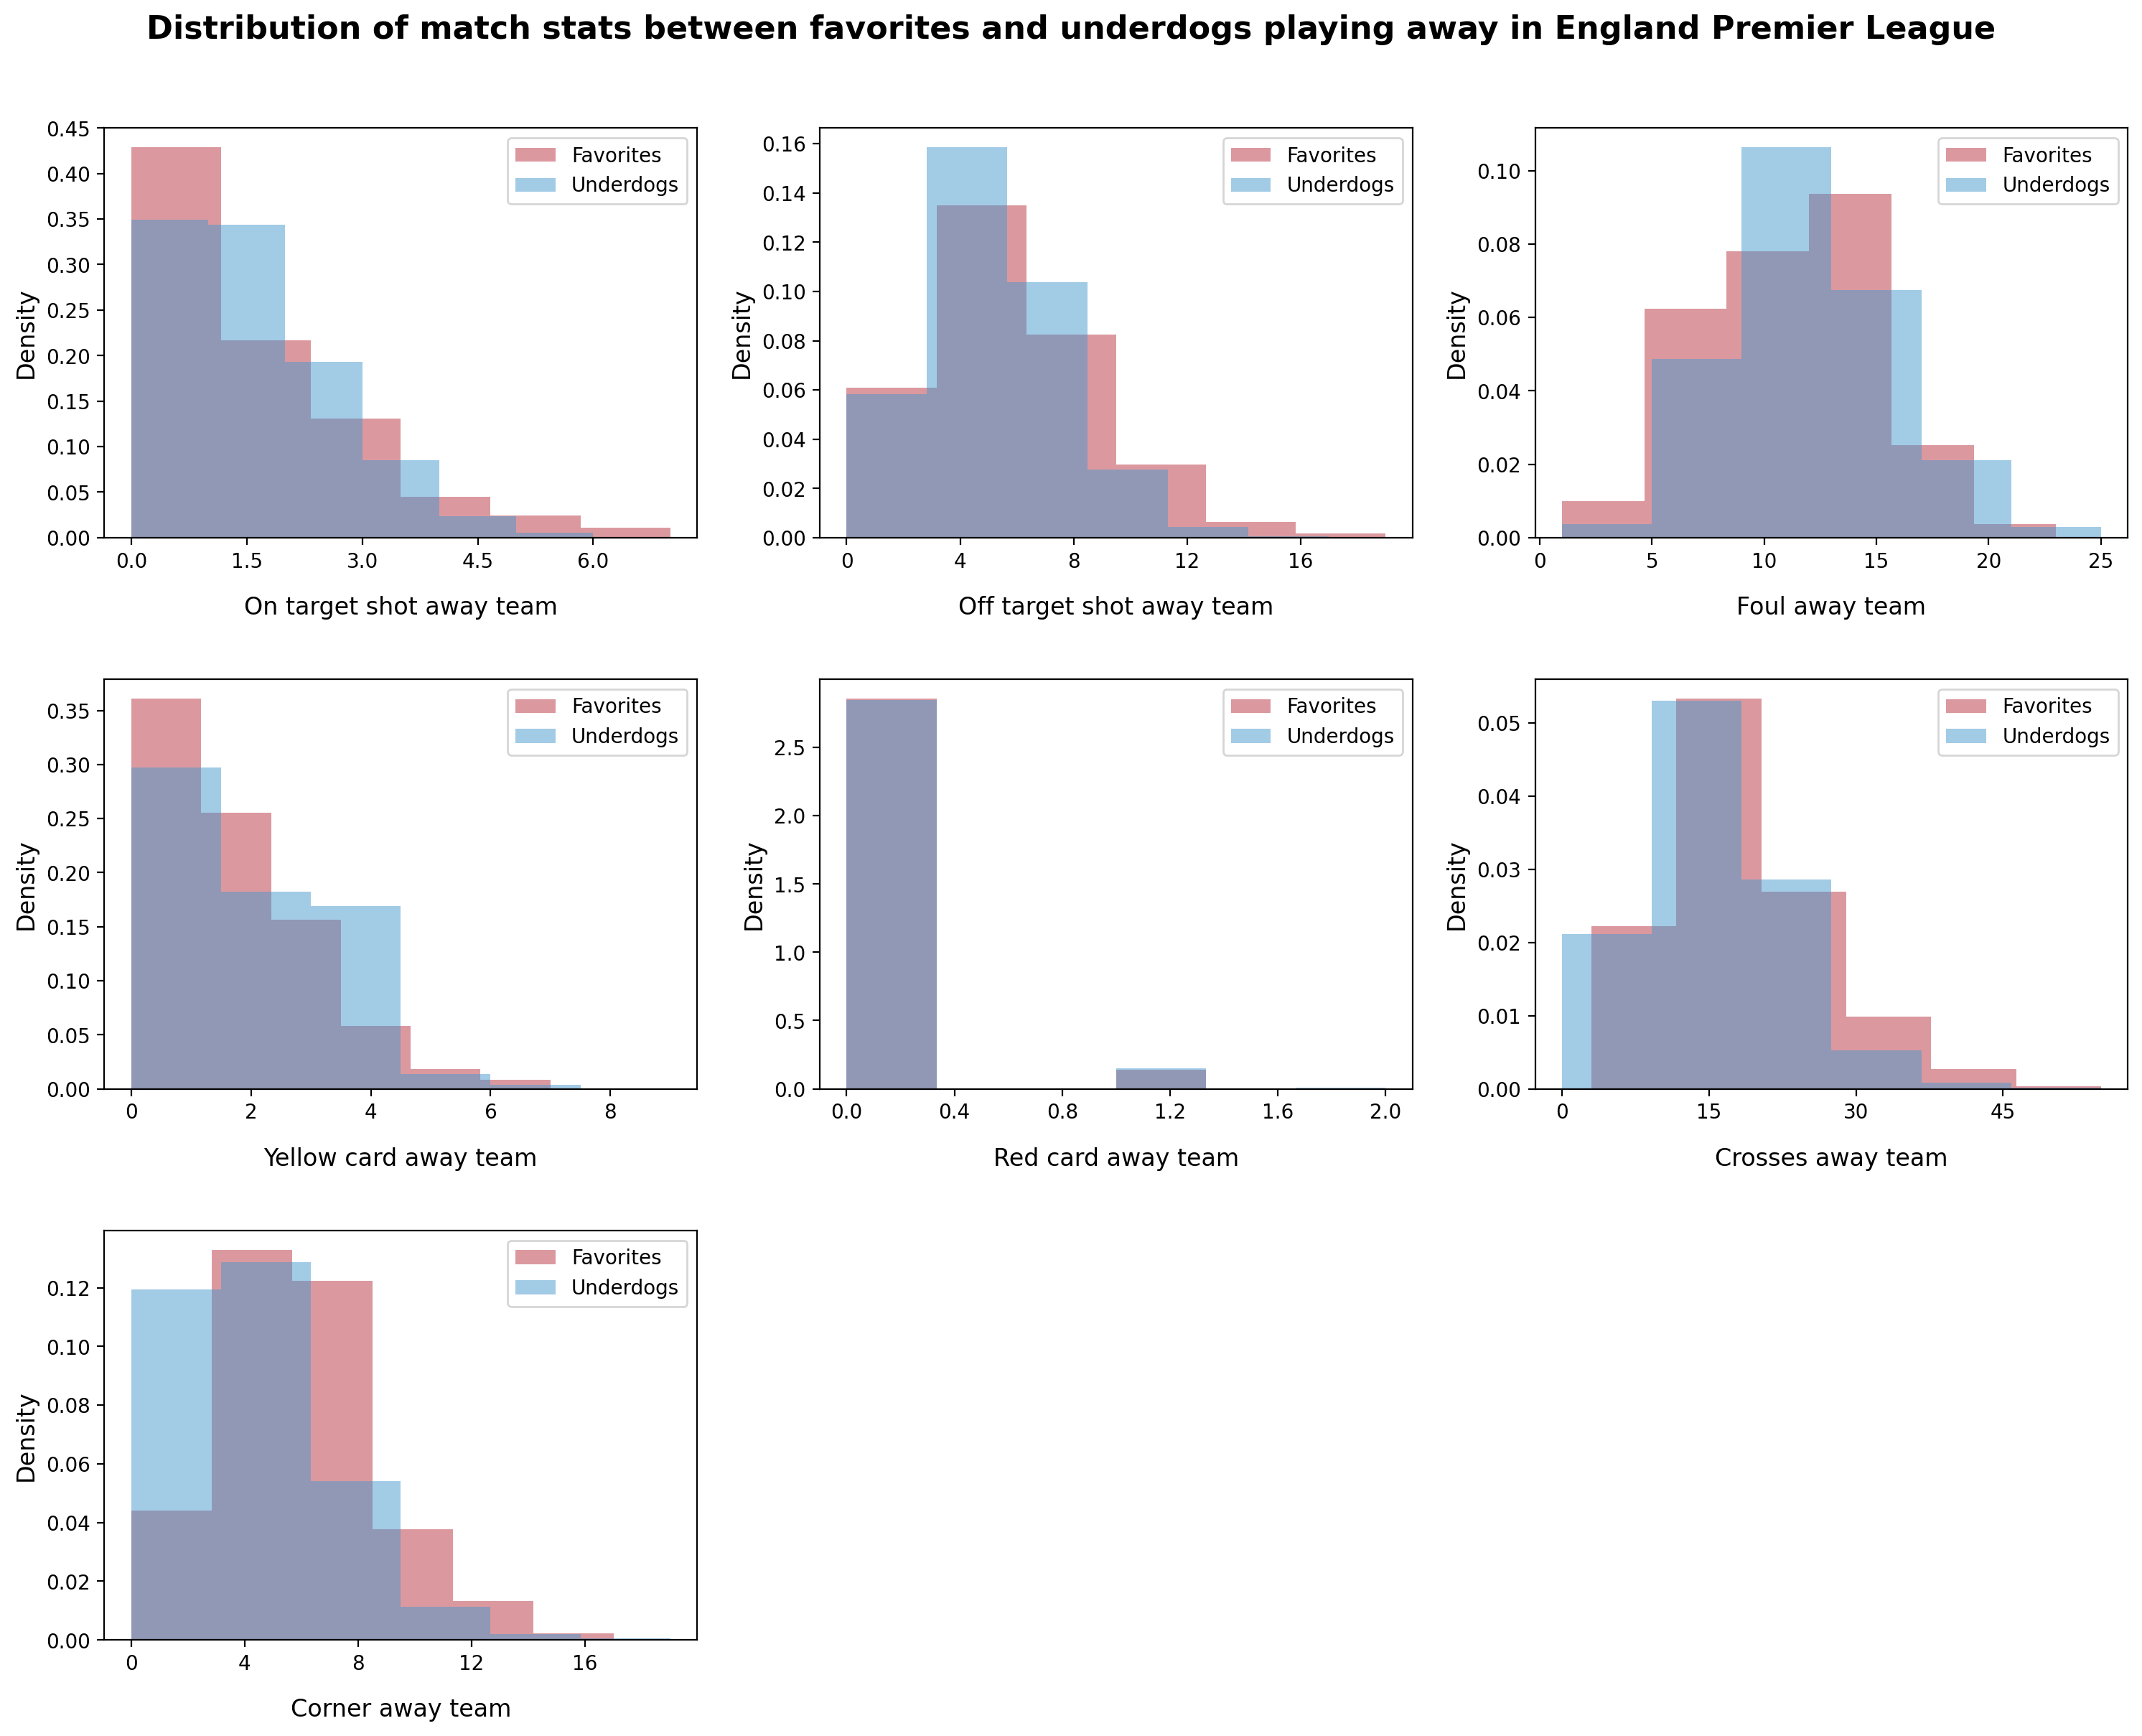

In [275]:
display_hists(
    england_favs_aw_match,
    england_unfavs_aw_match,
    away_cols,
    "Distribution of match stats between favorites and underdogs playing away in England Premier League",
    "Favorites",
    "Underdogs",
)

In [276]:
en_favs_unfavs_away_diff = compare_means_z(
    england_favs_aw_match, england_unfavs_aw_match, away_cols
).round(3)

In [277]:
en_favs_unfavs_away_diff["significance"] = en_favs_unfavs_away_diff["p-value"].apply(
    evaluate_pvalue
)

In [278]:
en_favs_unfavs_away_diff

p-value  z-statistic  CI lower  CI upper  \
feature                                                               
on_target_shot_away_team     0.000        9.743     0.464     0.699   
off_target_shot_away_team    0.000        8.425     0.831     1.336   
foul_away_team               0.003       -3.004    -0.829    -0.174   
yellow_card_away_team        0.313        1.008    -0.056     0.173   
red_card_away_team           0.659       -0.441    -0.025     0.016   
crosses_away_team            0.000        7.650     2.050     3.465   
corner_away_team             0.000        8.781     0.889     1.400   

                                           significance  
feature                                                  
on_target_shot_away_team   Stat. significant difference  
off_target_shot_away_team  Stat. significant difference  
foul_away_team             Stat. significant difference  
yellow_card_away_team               Not enough evidence  
red_card_away_team                  Not enough evidence  
crosses_away_team          Stat. significant difference  
corner_away_team           Stat. significant difference

#### Correlation between sum og goals by player and player overall rating

In [279]:
player_rating = (
    player_attributes.groupby("player_api_id")
    .agg(avg_ovr_rating=("overall_rating", "mean"))
    .reset_index()
)

In [280]:
sum_of_goals_by_player = (
    goals_by_player.groupby("player_id")
    .agg(sum_of_goals=("goals", "sum"))
    .reset_index()
)

test = sum_of_goals_by_player.merge(
    player_rating, how="left", left_on="player_id", right_on="player_api_id"
).head()

test[["sum_of_goals", "avg_ovr_rating"]].corr()

sum_of_goals  avg_ovr_rating
sum_of_goals        1.000000        0.759701
avg_ovr_rating      0.759701        1.000000

#### Match outcome prediction - distribution of features for training set

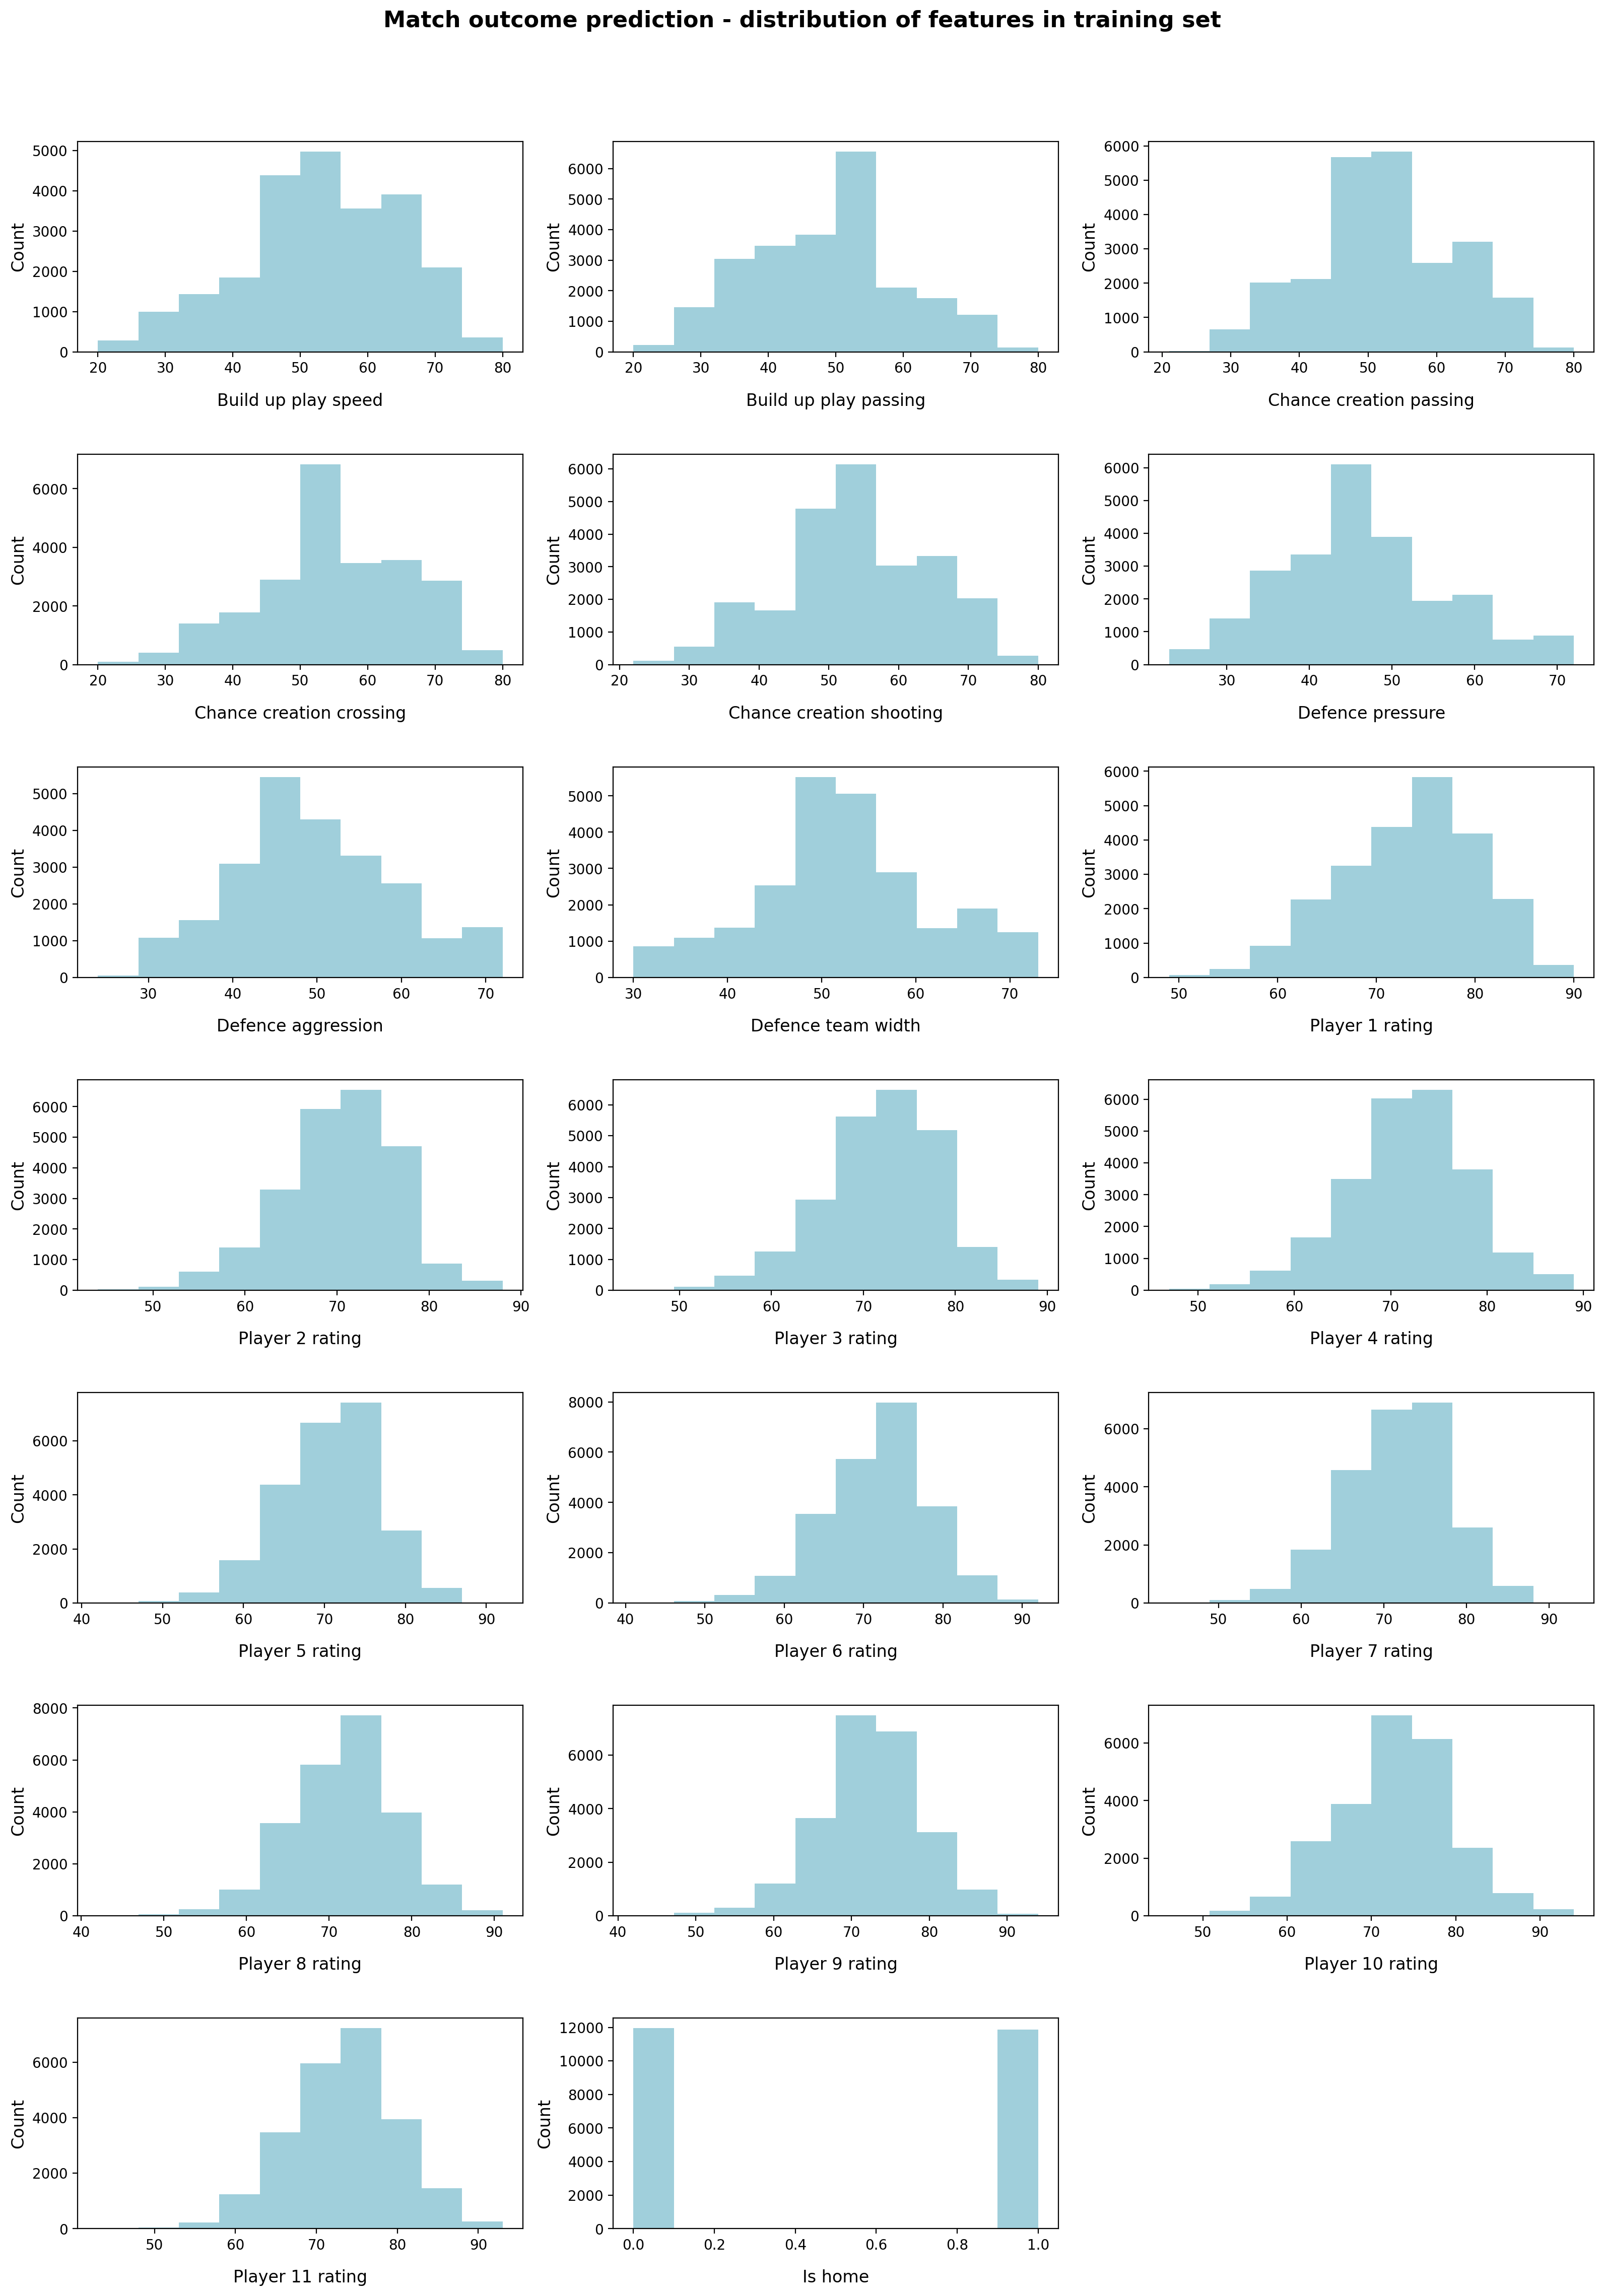

In [281]:
fig = plt.figure(figsize=[16, 40])

fig.suptitle(
    "Match outcome prediction - distribution of features in training set",
    fontsize=16,
    fontweight="semibold",
    y=1.02,
)

for i, column in enumerate(X_train, 1):
    ax = plt.subplot(13, 3, i)
    sns.histplot(X_train[column], bins=10, edgecolor=[])
    set_labels(ax, "", column, "count")

plt.tight_layout(pad=1, h_pad=3)

#### Goal prediction - feature importance on PCs

In [282]:
pca_results = (
    pd.DataFrame(
        data=lg_pca_goal_search.best_estimator_[2].components_,
        columns=X_g_train.columns,
    )
    .round(3)
    .T
)
pca_results = pca_results.rename(
    columns={col: f"{col+1}_principal_component" for col in pca_results.columns}
)

In [283]:
pca_results

1_principal_component  2_principal_component  \
build_up_play_speed                       0.002                 -0.107   
build_up_play_passing                     0.012                 -0.206   
chance_creation_passing                  -0.005                  0.022   
chance_creation_crossing                  0.003                 -0.120   
chance_creation_shooting                 -0.020                  0.116   
defence_pressure                         -0.002                  0.233   
defence_aggression                        0.006                  0.123   
defence_width                            -0.007                  0.146   
player_1_rating                          -0.007                  0.230   
player_2_rating                          -0.002                  0.280   
player_3_rating                          -0.006                  0.269   
player_4_rating                          -0.001                  0.249   
player_5_rating                          -0.003                  0.195   
player_6_rating                          -0.002                  0.247   
player_7_rating                           0.000                  0.239   
player_8_rating                          -0.003                  0.268   
player_9_rating                          -0.004                  0.236   
player_10_rating                         -0.003                  0.302   
player_11_rating                         -0.001                  0.288   
off_target_shot                           0.041                  0.185   
foul                                      0.008                  0.132   
yellow_card                              -0.031                 -0.056   
red_card                                 -0.002                 -0.013   
crosses                                   0.043                  0.128   
corner                                    0.047                  0.182   
is_home                                   0.996                 -0.010   

                          3_principal_component  4_principal_component  \
build_up_play_speed                       0.281                 -0.431   
build_up_play_passing                     0.242                 -0.255   
chance_creation_passing                   0.043                 -0.518   
chance_creation_crossing                  0.179                 -0.366   
chance_creation_shooting                 -0.018                 -0.320   
defence_pressure                         -0.129                 -0.171   
defence_aggression                        0.058                 -0.343   
defence_width                            -0.183                  0.004   
player_1_rating                          -0.042                 -0.017   
player_2_rating                          -0.040                 -0.042   
player_3_rating                          -0.024                 -0.043   
player_4_rating                          -0.030                 -0.043   
player_5_rating                          -0.008                 -0.035   
player_6_rating                          -0.038                 -0.025   
player_7_rating                          -0.040                 -0.023   
player_8_rating                          -0.052                 -0.034   
player_9_rating                          -0.037                 -0.040   
player_10_rating                         -0.074                 -0.030   
player_11_rating                         -0.039                 -0.045   
off_target_shot                           0.401                  0.113   
foul                                      0.563                  0.203   
yellow_card                               0.016                  0.023   
red_card                                 -0.002                  0.004   
crosses                                   0.345                  0.100   
corner                                    0.393                  0.135   
is_home                                  -0.062                 -0.019   

                          5_